# Popular Words grouped bar chart - Fake Covid-19 dataset

We've used the following packages:

In [1]:
import pandas as pd
import numpy as np
import json
import string
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import emoji
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import itertools
import altair as alt

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

Then we have defined the following functions to clean the tweets' text:

In [2]:
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_urls(text):
    result = re.sub(r"http\S+", "", text)
    return(result)

def remove_twitter_urls(text):
    clean = re.sub(r"pic.twitter\S+", "",text)
    return(clean)

def give_emoji_free_text(text):
    return emoji.get_emoji_regexp().sub(r'', text)

def noamp(text):
    clean = re.sub("&amp", " ",text)
    return (clean)

In order to do the classification of the tweets, we need to read the csv file and the json file:

In [3]:
csv_dataframe = pd.read_csv('dataset/FINAL_fakecovid_final_filtered_dataset_clean.csv',sep=";")
csv_dataframe['tweet_id'] = csv_dataframe['tweet_id'].astype(str)
csv_list = csv_dataframe.values.tolist()
lista_unica_csv=list(itertools.chain.from_iterable(csv_list))

data = []
with open('dataset/fakecovid_result_final_translated_full.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))
data1 = data

## Terms regarding Covid

We're interested in the "full_text" field, that it has been cleaned with specific functions:

In [4]:
index=0
comment_words = []
stop_words = stopwords.words('english')
for element in data:
    token_id = data[index]['id_str']
    indice_csv = lista_unica_csv.index(token_id)
    
    data[index]['full_text'] = data[index]['full_text'].lower()                 # Put everything in lowercase
    #data[index]['full_text'] = contractions.fix(data[index]['full_text'])
    data[index]['full_text'] = re.sub("\'\w+", '', data[index]['full_text'])    # Remove everything after '
    data[index]['full_text'] = remove_urls(data[index]['full_text'])
    data[index]['full_text'] = remove_twitter_urls(data[index]['full_text'])
    data[index]['full_text'] = remove_emoticons(data[index]['full_text'])
    data[index]['full_text'] = remove_emoji(data[index]['full_text'])
    data[index]['full_text'] = give_emoji_free_text(data[index]['full_text'])
    data[index]['full_text'] = noamp(data[index]['full_text'])                  # No amp with space
    data[index]['full_text'] = re.sub("#\S+", " ",  data[index]['full_text'])   # Remove hashtags
    data[index]['full_text'] = re.sub("@\S+", " ",  data[index]['full_text'])   # No mentions
    data[index]['full_text'] = data[index]['full_text'].translate(str.maketrans('', '', string.punctuation)) # No puntuaction
    data[index]['full_text'] = data[index]['full_text'].encode('ascii', 'ignore').decode() # No unicode
    data[index]['full_text'] = re.sub("^rt ", " ", data[index]['full_text'])    # No RT
    data[index]['full_text'] = re.sub('\s{2,}', " ", data[index]['full_text'])  # Remove big spaces

    tokens=data[index]['full_text'].split()

    for t in tokens:
        if t not in stop_words:
            final_token = t + " " +lista_unica_csv[indice_csv+1].lower().replace(" ", "")
            comment_words.append(final_token)
            
    index=index+1

Let's create the chart:

In [5]:
fdist = dict(nltk.FreqDist(comment_words))


df = pd.DataFrame.from_dict(fdist, orient='index').reset_index()
df = df.rename(columns={'index':'Words', 0:'Count'})
col_one_list = df['Words'].tolist()
col_two_list = df['Count'].tolist()
typelist=[]
namelist=[]

index = 0

count_false = [0] * len(col_one_list)
count_part = [0] * len(col_one_list)

for el in col_one_list:
    tok = el.split()
    namelist.append(tok[0])
    if tok[0] in namelist:
        indx = namelist.index(tok[0])
        if tok[1] == "false":
            count_false[indx] = col_two_list[index]
        elif tok[1] == "partiallyfalse":
            count_part[indx] = col_two_list[index]
        else:
            print("errore count")
    index = index + 1

i=0
for el in col_two_list:
    col_two_list[i] = count_false[i] + count_part[i]
    i = i + 1

df['Words']=namelist
df['False']=count_false
df['Partially False']=count_part
del df['Count']
df['Count'] = df['False'] + df['Partially False']
#df = df.sort_values(by=['Count'],ascending=[False])

We have used Vega to plot this chart and not Altair, to get the data in a good looking way (already indented) and ready for the Vega Editor we have used Altair to get them. (Plot the chart => view source => clean the source and copy paste on Vega).
**We know this isn't the most efficient solution, let us know if you have other ideas**.

In [6]:
range_ = ["#0C7BDC","#FFC20A"]


bars = alt.Chart(df).transform_fold(
    ['False', 'Partially False']
).mark_bar().encode(
    x=alt.X('key:N',title=None),
    y=alt.Y('value:Q',title="Tweet count"),
    color=alt.Color('key:N', scale=alt.Scale(range=range_),title="Category"),
    column="Words:N",
    tooltip=[
        alt.Tooltip('key:N', title='Tweet Type'),
        alt.Tooltip('Words:N', title='Word'),
        alt.Tooltip('value:Q', title='Tweet count')
    ]
).transform_filter(
    alt.FieldRangePredicate(field='Count', range=[80, 212])
).properties(
    title="The most frequent Words classified by category (False, Partually False)", 
    width=95
).configure_title(
    fontSize=17,
    offset=25
).configure_axis(
    labelFontSize=13,
    titleFontSize=15,
    titlePadding=15
).configure_legend(
    titleFontSize=15,
    labelFontSize=13,
    titlePadding=10
).configure_header(
    titleFontSize=16,
    labelFontSize=14
)

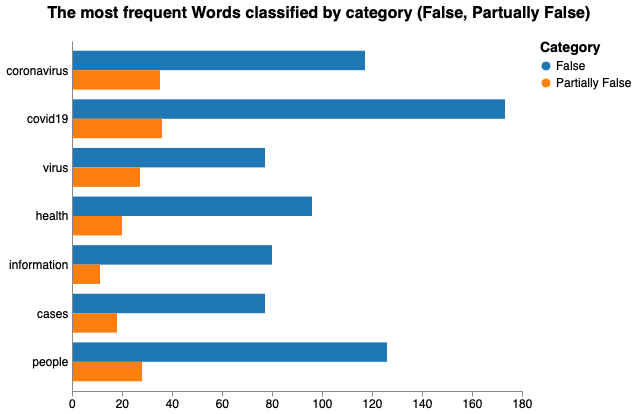

### [Open the Chart in the Vega Editor](https://vega.github.io/editor/#/url/vega/N4IgJAzgxgFgpgWwIYgFwhgF0wBwqgegIDc4BzJAOjIEtMYBXAI0poHsDp5kTykSArJQBWENgDsQAGhAATONABONHJnaT0AFXgACBGwiYdAM0VwAjgzjijAdTaLZEHVAA2SCBBrGacWTqYATxckTHIHYIAKADEkVwg4KR0ABSRFTAY412DY+LgASmkQAHcaWXo0ABYBAAYZeBoyLDQAZlqZHCRZWRpxMjQBGTVMVzg0UDCAD0w0EG04PQMjUwsrGx17R2c3Dy8fPwDgqFDwxSjchKTU9MzXbJ0LgqLjCUwAZRoALzHUAEYANhkbGMxgSM1QACYagBfGSyUIoVAAbVA4iQCB+IEwSCYoyKxDiVggaBRIE2Tlm5iKjzQv1+MmuaiyOTiCVpMgAwmwGDZaRDYaBycT0BRFGRXL1+jIaZCGWkmXcWXl2SAuTzwS0BWSHBT0PoGPRih4YNTWT9KnL0jRmQ8zWg6qrubzUJUtULZjhFGwwlAZtK7agWoCQIzrYrbcrUINHeqqr83TrhSBesY4L71KbI78AJyWhX3GW-B1q50Q7MJrazODEMrWKBjf1ZgAcebDBYDRc5TvBEKbFd1IAYXj6mbZfwtIflbaVY4hXdjf3+-aT4jgxVHP3+0dDNsLuZjzqbrqkgsTsygDgkSBriiHG9pvwA7K3dwG2vPnb8BPyT9rK+h4RobJ7z+FoX3DGVoxLcFfj7X93T1PxrRAgRtynV9I2DaC0H+eN4LPdAmGUOAfBHRsxzpcD2yzD8YJ-U9-xAIi4CQABrSUQODHcII7Wi0EfZdZjRDEQN+MDJytDCKL48dBIAmgEg8BsQD3KiZx+KDuzQCFjwYgcLxrWQc1Ex9xO46ixyDGSoXLfDGKA1wQIncz1JVbCozkkAIBwOA7lEtSIzHYstL+TyDLKECoQCmU5wPHt6L-AcYECHB4EkcifnpCT81c1BgoXPC9KTCRlMgtDJJ4rNxPc-44KKoTelKgNYpcwKfny0tPOrOAzhK0SW2y6c2taazCsSpM3BY9KVN4wapMy6zPJgJBxApDLaTM9DKssmSAU8lZLGsEZAki6KAw6ntPKNRxTrm7b2sWuyBxTNM1AkYl1qjM7I2qkK6vG2ZxS6W7WplC7tM8hImp+gbQY7WL3NqJaVtkUSsrhmi4r5SGVroL4eo+mbMYxoLds8+gvQYJpuT9Imx2fO6LIerHUAEp6k1YuA4BwSLnK2pm3JCiEBE8u9Pu-b7Zyy9zTJx1MTMlhaWdg-bXAYUTypy4bZWVtn6vQC8EH0aaZU2iqBZ1xGwrYVxUc+lr+dy8HIS6yZ0RwPFPoZknmZlzzPW5tI-FXTwQcd7XpZCzV2dmCBkD8z6+fN3KGfculIeOT26Z+M2tcLGTdIB9AIBxZR-MZp2yZjwjuVYrpuQQcufftKv9ZAF4zEaE2A33ZvLZC9Pq5ABBegUsJFBA98K+136Fxaf6ELkBSoCHBI7ezqpFcFhcRaHpBTBoY5u8jXvw7BmTbLb+gVs59f8+n8-leto26AxXlPtzob7-cwvF-gOJ6C+Anh-LeeUZLRzbiXVMwCN5-FAZHBcCVF7FAcLbJyXEz4dmdgIJcQ8zD1nfrAjBydtYIz+v7JAPkYGQVAWQhcesi4gB2DQBAhNCyf3miNZWuDIEezoE3TBmN3JIIIiARyICH4Bk0guBeojDCKCQL0Nh514Gt0YaMLoHFxaqJZjwxhCRSBmDDiQmUE4aqeQlJzYCidaEyT0YvQwoQx6HziAIkxs1hGeSnMYJAvoQIOj7ggz8nlZBWFEgEwR0llZjUXr0MI4g2SfQie4yMdDOpDxYooaxsCk55ykRfHGCA+FkVgQ7FJUT3IQMYWQSmPNPqdkkZGaRn5d5t2KAwZax8KKn3KZlZ2ZZPJmAgAwVwagSn30CY9NuMBGjwGoW+HRP8vE4E6GYQhj9JlPyHlAUw-jFkD08mJTioDZ7Okvow3YChhxSlgejSJvsDlDxpsxNiIFvb3JwrtKpi80hOjvh2TWX8AxmIHucxebg2BQFYm4vJkZnYxNEfIbm2SJkfLAVstuF5xD1kUKuf5kZclArhQXLx7hFAj3GQsxppMWbfNEaMUg8QnKgOdr-ORAdgaJ2IbC+mMkBB0sYgYnqdATr1JZWo2JaJ0wSGMTyh5iDXbu1GMo4maL4WeRqSxWmhZuVErHCCxBMIh4lygMoHw9YVVRL7uqoemAzBOMpU02xLMGEOOvFo254qMXqJoKQS1mU7m9O0l8-2GjEk5MBZw1A+5EZssYqMbVHZCVRoGsIkRjFVmJqddSpW5ih5GggCabRObg0uutoY5lJa4Es1aYwi8VMYD+tLdaqZFyIC3xAj0uV29PxGrbqmXyKEvVW3zb5cRpSOH3S4cI+xojiiZNEpOi2QSYJxoHMgdtkVkndpdNZNdSZ-6jOSiBWGaqZKyMYjARtMK9XyuCU8kEh8wycSXblNJ4ItzkzHU23dVaV0DEOf8f4NQag3qjTatupAbBAVCA4H9kap3opHZAu1JxaBQDA4hiDjC0RvTROO02gad1YSjq6uRmBIWsRwEBaGs5h1Cy6pYFQb8s28qrc7MjjF8FHRRQGU9QakPkONTMlZfhMMW2ww47EYQf1PlAc0+KnlxAMAQEwHqkVdVRtTlHAVA5lU-veQJ99aAwWiI7hieZBL6MLn3bHJAgQf0QiI7e2kzsWgIsYvILwZA8Xidyv+l2Q9SKuPtvsue+0siVr7qc8EnGBxMF8dC+pr6I67Vs+gT0LC0iis9X+1tDjuSKHrOE0BBrPzpa8tJ2jOd+M7tTSFSos742QtZLKlzgmFV4IULWaDIXYHbva8ZwLbcmAMCAj0PoP7k2IYC7WxeanXBsFIPimlmy05hUoXQPrpiwvOjm6InE6sknOs8UPWQy0mA0D2VWob6aBxmBwA4TAsmBspt2hegcuH1DbZUexmSfaLk2G4G1qNAXdNJk6J4JAZBqstzy96qTwqJSfCcTK47N38uiMexKYr9tavtZjaRjbigf2vcQ7dihVooAqAdTc1FRnwH+y9DU9EUW0WzfJp0pLtzDPEesuDqsIInuyec1GmLtIKs+CaKxnOZOLbi8DALg2l40ROXx1GiECvHweYHDeMWsDHy88G9pgqNQKvyBWiDxDZWP2iyQLDwMoCSMLlM4KzovRRLTYtjb2kH2kyyEhRRyzFEyk7qG78CrRFuTS7Zwz3RGqxvYmD0rFtCPREwAMNR7EBHgVe-87N-bjFAHiHYo6-V1nnQVZQSMlbOdNOIfqzZir1yrfLsZ3gxR4b6c7oV836jyhnt+e1pJuRbAMTF7pwGI3oPz2i1XJMHyvoxNir+2ny9lCfK+eLan5D+ik9hFr5vKtCmTOQ0lB6mKJ2GthRmXcWTFeYKeRetK-XMpp8zdnxkhfPUZdcJ31HEJZPVoevC2E3SvJXEAMwNTKAY4IfR+dbIeR7edBOUpB-CGfNBwUvSfLMLtdrBXCEO7JMQwBgWQHLdhUBMAnsAHReIZTJWAC-Waf-AqLxaDJgNgHoBQWPHdVlfaP5USEA3KE-SEHXA9FTS3epUPPA3aQvddICbnU2NAwMRVClBg1VATEfRiYoeAegdTT6AQ0hT-NuCUPoYVMvFPM9NfeLHEXwe-VfBAtuKhZaPAVvSuFmQgqsKDUSXAqNH3SECAroEZQfFfJg+9aZABVQq1Cw+wxhYwHkCbbAscfQ+AkKJrJKFiI9TtJI5qeFPabZZQLwRzBDb3ayV3AceEEwymEXE5NLSGP5KbRQqvTAyeFLQsVlCAiARbUoMwlUEIx-Y1CjUTQ-HWXo9AtuB7dwXHXLEY0KIeVcPwF7RQosLqCtPQ0rXaag0RCgegtg4oCUSeRQ9ox7dIeo+HXfReCjedIA4YqIhjW1BgXFAzXbcEP3WYCPQwCIZfKYm45g-ozRFTLg9rHgoeUYYwX-L6U4lIufIcT47vQEiVRFNMLoB3UXLDeExiLFeRBgJfIYlEiTNEgcKEGoR8OA37aIxeEeCUJPMgnuJ41zDVdETg4I740IxhCkkk4lSwpMEeCEf4dkmlMkzYsbcQEOWw6YkQ2YfBHUY5KtBXUog9XyQ+NgVQXQ1Auw24tuWQL0FZCI8w9Q-EpMAg3kpkvUzkj0NIUIL0JUgmPku9PotuLcEDRuY07g-U88bkNBepPPbWIQnMTyNg0gk9eTENIeF5eQqlNba-WYhdGxNUmzfaA0e4h3Io1ws4rHL0GTceRzRQ9wg2TbCjHPVJbMm-FaMZBI3Ul0009AYwdwMsh8RY8UjLNgOJHUno5ku0-RezFsv4SQsXaQkJBSFnSY2E8DV09ABk5QI+N5Wk1AF4qsiURkr4k0gUwVWsFw1LWlP0sbW2Lsr05IuMjvRULs3ElMx5ftbILsns1Etw8mdg+zTiZMiOXwx8OUqsDwMElo0kgA-NZed6D3Z0uEyskAcQJ7ItHJacmQiHNgYoEeFAf8kcwCsQA0UCmUdXD-FmF8ucqCrpH4S8vE6841awE4fY2M50doq5DMULEiy6UdQwNcvc9JNuS5VTXjH6A4wZZkIdCEhcVIpMXxPDNGac34HMoC70bwakwsqi0YxhbmWsEeDDepB8lC-nfaNZWAaUiM+hZZD2cS8vLivbTyG8H7KqK-AqCC88ZaP82BRSz8neQZZFXxGE5qIs41G2MoNIEVdStFWUzyZAHSnCrIzCcBYSukTtao5WYS4ZGAq5AEmfGtOy2imMvuIQjCkAJAJChwDy7fNsgDbZX1ICTKxcis5cgcMgJbHqcQFjFCXcgFOxFKlMBwZAfiz6JsOXfPC+BskAHAZgHHSKVCi2Z3UiirAkZQbkeDacni2YBSYZBchQySpQrrdwUsuimyhimI2ZME1q4ff7a2L0VXdHaYjYzQksxywKmUgpPeboIZH9D8iS1My9FKb0eAAom00tSpf2A0ErKtXwiPXgxQa6IYgKujFmWckAViBwNTK4za7+U86SsE48gwjcveAsyIgTALYShAA0VHbCuHPuCnY1ajTma7DSlkxeT0b0OASy4ctC07DU3CSoWs9FYm9s8FNKhILMjHFmCrXoU1FiLvAMQGnCwwxhVDBJEeTwGgS7SkvynG9nUcryNIaAJbCEYipmqofaXoHE3C-zYMhw9wIcCWrODZWWwCnxK4yiM65WCrMmzwuC8ndvNuOkI0-rQS4nEiEZTi6Ysy9AbjX1ZE6y1i5WEGrQ0IEuFZSed-C2IbFoOq7PaW0CCg6yQ6son8wxE6naOaiAleIxT6bwq89yFK44aEz63G3aYShLJfZQf422vC4q3i+INgSKCO-zNzOLCHL0GZS7A-GKu2+PPeA0JUrwGa8M7K+atuDWtgBwF6jrEm0RLFQxLuyi6Y4S2IxUVYFQHyHExYq6MdEUqejQ-SI6FU1owSjqu1LVKcjm-OihNQI6a6qGjsAa8ERrV22gQxdmpenGOJZajkmmxhajHqbO1Uj+u43Fb+ipL8yBJUmZB3G6-kiBxhUoVwVhPeuWhbWgcQ2BWB201oJnFhB3Ju9c9yEGnkYEc1Z9auk8n4yDBSfhCQsKtOL2kAAETypcyEoeKEKESee+rMIbSodG4QZgNgX4BAMgJgbMFBwC+AWQGHCR2u2YDPYCq46qoREKRhxBjEUUkejq34BKohEyw8SGME5RuB-ctuDEOAMEgW6dEKOqjBo2uPX+v+ezAPbGxmtFPGyDG2dULmK4rBntJ+ny9g8qjwIm42uR5XXa91W8UnRQpOpMAkGAxqSKf2kPcBVu2YO1chvRqtR+7GAixANO5mVWmYowmgQmj+YxgNAuRhtgJgGsUa0J1GuWo0OOr8IMtwuJt0mvRpoqkKTp9AeAVwOpUpFJzccBDquOSLfake-prEPByKXOi2QnOeEG01GhmJua2ZjIVcKetGm88Qda0KvSmCWZ4k+pbh9OtOCAnAJ025PqwQ5S-GtMLJmUKx6tP2LrI4uG0Zz5Nwjq5ARQTmIIoBsJ+B84+4-QICHp9rALDq7MEDEDMB7B4bOtCQHwclQp1oeG15tJjbNmt5AhwsRvM5RhrFMZI6FWkeiAtoBF2RmGmgtMMq4ia6ti9hpsJsAQOlqhxhC3egRzPx-uRBRhmsNcJF16yMzFbsM4FCH56NOxSXRoRMn9N552Ca728gCig3RQ9JgCY0NgtIMV6e6ituOASYNwfW0gD2kexhuJHqEV9cVYy+oTMY7mQ1-pUlU1lGZQWCkF1hzrNuFrLwSFJ7OAT4N1zHIvNiB3SoC5sZzmtVzqlGRAQ+E4ku3useopPio54ppYveA+I+cclxVx7Fla5m+lB1BuihrawCw2DGg5m+x4uanVuQOABLMISlv10i5GFHG6Kt+istjNO8r2NY6JLxCzFxd+ke4S4gEZVcBRXEJM8arqTwI6F5jsQlqlYRWZlBQF60+2WN35mdfZw56Zzt8EWZ6waPZCqfackGlx5Ekt26geCAwZ4Z+x3phcWZoZHrYFmhOaxh8QQIeS2Be5hGtOWZtgymJoTRs92kJaFiGsFilGj9me+yTN7Erl1DgcLwTAAPYoYtre21JsvoZoPt0tuD4E9amDlDgd7DyFXwTAOOlVuxJaMeDKzOJD8sgC8JwcVaHqd3IYrW6txx0ROIgBxlnzfGQT5ytuMTxQAkNWTF642DlFxeRl4ChAVpgV2FirHEYDqmmu+l0RVcYoZVjdnhmSZ8gy5Ce2Sp-x7SG13a1pwjq+FKFxRUXZiNgcOT949g8N-CtuFnGsRjzzgL1kseKNzD2jyCwwLs7TklEMxLeEBewq7jozxiQyOAStqyuz+O3RZt2tilsjn+9LgcR7HD32yeN582n+ZtrQnqXmqLijtuVcFYu59p4RCAjMpT4WbMtRtILfMC45nKjUtMHjZzuajq6nIrEZIi4dptufQxbwXwaTua4SslorqyxQxhpQLmBJDPMEoT-tqSn5bAXxKRq1lTxhroHoJqzB6cirDPZAGRxKkeirCjLE69iS4p9omjbFRdp1zSkM+4td77qdrqCzGHbFOOpzehoWCrY4QBmKXL3JwMWZsl3oKwIYgVtzWo7co+4FBonyzH9tx16YhNrwNZbuwz0x-ROIod+74bl0LxUE8qie1x2VgLBNnSbN9x3aDq7HQ+B3A9o1+0TyUhoXknfzkTwdiKeb4pkGm56F+C9yWZtWY4SdlT4SuIT11aJHxgrRixCm0n31mjk7xFFbz3EdtOEGhIeToXhWSb5tg5mPc5k+8mBRR9fTpytbrxRJ+QdZA3ppsLxeF4O4KChgN9n34ByBezDZg6-aLmJlYr8B-14W70DirK4PvNFrhqoyxI-R548mNiI83L8PBNgPfFxe0F8LIeUeBUQ13hs-eQZXvOvprqEEV6ajmFrzg9WZBQSx6c5tyv5E6c4S7mtWeQIYkXjxmI7qK48z1Pgx2Y1mliVvtvQCwIBQedZaKFJrkpi5TVIetQs3g-0mswEeFTbvlX0r-3FOnqOOxf5F5tmd1wOd6wqW6X9Ui5fUQPqzOairPkRgYPdPIhJUDBImmIQE4A9xAwF-zT7goB87nS7qf0YbVkkApnffh1SpgowfWBnXKL3mtg2BlAo2FLngLA5gtREX4LwgnTcIJsKSEoNHBOjh6IIE2VMSYOv21qAUcEhrMHH6QciasdsTPUlktjKDGRT2p-L9goEewJI1wwvF2kRxhw6EriBBDrkLGbYexeacgzZpDC5gcDhO7fIeJl2y7vs0un7HylcmhwwNcuQhaOsWTFB6Doa3LRePCBBCKIhkDgjxLf3Mr5EPBAdN6kPFYie9QSvgpftF1mCv5fsCfY1JHy+aRQBWqPAZF1gyC4oeuMnRhBnm8hbZkcWNTAV4kUDKBlsLDHdAFmbZPgvuyHUwVh39yBwbg+vE-j3xD6iJJSjgJTg0hzYC9LkFRHgfbRiIShXeIHRQnewKEE96hN-JwaIiTzIBveowtvuMMYhuDYhr3Bxmw0C7GDmoj7McMs1IpbMFEjKanrlFR65tMU7sRRD5kDKA9e0hArwPIAUR3cTBsVHjsIEoQrQFA0bQvjhA1RMsKqm3e4bMOdCzNYuGNRaloJzYhIx8A-Q+CEMFqNDPMiAFGMgMGyWcrodAGZK4yf4DBS6nkJ4Z0DRHvDo0FCPjnJUnhl8C85aEYathmb+wnsAgyITXyqFVhv8Mg+PnzxhEDgjQmANSp6TxG5EHCTiH4VglUGmV1aSDZkdny8EDMHAXoSGvILMZIBloCiQtKhm6GI1pkmeLIVCLhyq8QkLEIYrl18Ig1-SNhQ1grjUYoiaYkUI7vDHAQVZuorjEXs7G3YKJBiGowVqtVD58FxBlQ89hYkCBdlquSIvBBPWQbV8xRtfXkTfRsCiiJBfvWtreVIG0jQx9IgCBY0UTJ8hu0WAMVfDwYLELaVzJTFBSjENCeOaQHkEnxdGws-SiWGpB6NS4PDv+DiDPPhyKFFiQozbBRAgDrjwhbmvwjfjxy6q4hIRnosYf8LsoBwEgNgJxH6mVH+DGKm6Ohl9V2gJsugKheRDkPl5opvqHVXxCvDXjTiKBGaLLhoNEg8laExLGCAIGbzHBsADXTekz217GwGa5tJKouNJRiAXRDowJgomRpccNcPQqTGsjIAVAQxYeBLi13uJV9smGY9ChDw9hsAt+x-McLK18IpVHEIIYumih9JqMWIYZGYZHT-Gic+OJObEKtGbG-jgaS0G2PEVC4y8BwsRd-t+L-xUsmckKciu9FyFDwMQ+gaVhAKYnAklgpE6mq2JCRhIhxfw70V1ihT6Zd6KfZFh1TmLY8BWZ4uMNqOQAkTRJNPEcdsngBQpr+Yk5rowgIItAWg7Es8hlR6ArRdJGksIegFqBCUzmtYvSWf1EROYagTYL8MrRkmajxRvHRALBK363ixSPlUIOPD3FhjWSn3OIdbzUEe9WmGw3NAPHH4+YHADuRZpQzOQRZpR2g21GOmPHciKspVYgHALdEIkS40GSyWlOsmpU-E9SOKV5IKgdVWIwFB1pg3RG-of4HQ0OFn2KEsch4t+IRuWLlqlU2A4oN4RcNtwEUeax0F0bP0lSOI7gXZGfr31mAb4cca4xnmmzurrpamNGc4VBLTgC8FGCEn8T3RnGA5NSTZVbj93F5UJac1E+sXIgcxhBuxAo3Mc+yfziBzMR5MfqLDt4ssmeCPNYTgTH6zMzWJk6pLoOAlejzejEI7Ft3-Z8CGaqUwhgPFmZO1CwrUoQgQRCToCJ62PVlmPSIhyiWERU41jyyNFdSoZHkRAuSL6TciIq9HfPj8BapRSZEundMJa08mi8nJjEU1vWDuB1gJugUojlxK9DNTCwlop9gVAqwCMdmSwndPqM8jZggJDkqyfpPP7dYW+nM-evKS9BHTGJKnTOr5Fba3D1AmvU-sJQzxF16kzHbhF1BsCts1MYM0PhY1H6Tc-SXoLoBr0O5pDzixACAAoh6CwCtZctRxFaG6LglimCbbMKzkhl1iwp4LWWc7SylmMkIuAhMdGJDLERSIDNe0dtSHiKClqcsxEem3UTegNYNAtNF4mvHQZGBMUEXvgUzr2pC5603iZKw+n61a5hPIQVdBLKTwJZBfWlCDSYySS46ArIbDt3lEwNc5tKWZj52InT9Ymfpb0BRmem4SKpas+lEkyLk+Ehai8Q6LF07mRhQOggtOOPw+mvQeusrLYRqCtqHjDa6cymduzNEfV1J68vKJDECBFIV5smJGSfKFgQEWEXzXufbH7nmhrICbNTLoyUpM8UqZAIkGbMpnCUt+P6Y+eRxnKc57UOJXLgrifCHIPJpSEXr4R0jvUBxhaJTr-PySW1IYKmAFkx0UIJsRaccKajSIs45N3s70twKFK7bGpP5qgMfE4mmHp1IBTOBQLwpXkCKSZ0MgcB4DEX8K1Agin4BQpK4u4KEL3LVgt22Rj4A4aULwBzJVlvyJmGQDgmNTGn8RQB+Cv9htKEl19VoeVUJK1ljmCT45FvL3oEX2HkDuKhA0JNVP0X6C5h0igkDBgXYCUFxysYQROJ8WFhOeL421AompzhzQFdU4qVxm5ghtBOtUx3G4QqycSIaki1TnIipgw5DACC4caTJ+QQBZFjVdzueXPkYdg5gFSxL5DjrTytRsSiySPHfL4zGEeuQsaUrF5nZuoi2KPv-2KbXdugeMK8AxIjl0jxpDhYjr+2HrLDbKZ2BEI70CT9Jm2gCuGi50YShk8OBHN2bEpGQw8fZoiP2R21P4QEKSsgTjq2RU5yTyau0lkeB2XZqBGqSnXLkCUYq+hbgtyuVq9IKjCUZK8gIka-L8WaS245gXpU4qTElBtCcyd8XnLaTmiwVjg2FRUq-lj5oVqs9+fjUwWIqWYszHoIpD5ockohmKRARx2aV4jx+RSJ7MAqTnkqYi9PFjJn0ZUzKN5sI8eBSj1luNExlUywOaWgwHNw5IvCsYl13Fk8vK51E1p33ZkpSWZn4CAj4gnGxcFFMtflZyukXCknQ8Sx8TsvOIKIEk0CC+gr3Yp1CKhfS7mfpC0UJoHciSrmcJWSFohKYak3xcd2tVJh6+oPCkSp1mYbpWIP8mlVgOFJjcoc3E03ogv7KOJsUpfQSowwoAiRt5MK8ENd2xzDSvgX0w5dMkCDnTJgQHGAIti9BMZE5litFJQTyZtzzWXmJ2WcrfK1rGIyAYQBlRC6OLex+4sruTV6xTKy+PUserUu9m+8OJ-AtiW2s4GnTF4i2KFKkKHWqik1mDAVhWpdCzNm1TAExZHKUx8A1AjKQWYbzzapg6ltyDJbC2EpjjZMrU-AujzRYNd-u6EzVX8A6rlFfAUyh1e6yCwANjqDakqqXGfVfqkwbbNQIYDHRpy154KyqZ0Fm55LhKnwSUBICuz1KeOetBRHdPgHltVMf6yah9IaoCS8J5E7ZPcTWRw0ReSkv4LbzoCZA7hzUB1SRpaDo8CqUSp3KNE3WmdkA7AhDd5MwCFSc6ihFKqGRKWOThKwIqBS9L7jfUEe7gFhNirfn+qkSjdeBC3VHHC4CVrStpFzFYjwgHMGG9AI+CV7sb-FSYCxspoMEOFI+QEcqWBq1VEEaA0wGZJnC03DxU5QeczR6q3HBL7YGS-ArpzFAiTI1Vq7XjQCKwSBbu6gVoQaoOwBaPYLw+zdRiYA+JfQsANMKxEARvi9NsKrqiTh81kCXNrsSLV9kPlA0rpeCFTHBn6iLFFePaonkPC-D-ACC4A91Wgq3HpVlA3wfjTirPn1N3AktejUH1P4C8Chc3FuUsv0pnYx8T6e+aBuy3RCqENYUlZasclYDZtOcJRQPJ-ioDIuehN5kIW1wWJ0BvPFTilR5AYlhgBob7FMoyXayJSFylsbTwcSAK-lr6paRlncC+jw5OPfCeiQnJAt7NUeBtBtUXmzFRKQ5ShX3EOETNwRfUecVYqllhQAtK8YEUMVambiIs5TdlX6qfzPcHcbzbykFgcAw4F5TPR9YHknqoq0FAIruKEETIDSEKdqCQOKBOVM8ICxKsQNThOBSbkZ+m2OL5GMBcKNQ5gqHEUsijHrrIZdaJgkDTGX5Z1qLD6QFuDFwyN1Q8AQAzVlbYIv0sAYCotjIBx1ldfKbUZk1ZVnawtPM8QDeAkCVUeJBsrqLDIl2FbJWh2qFubsuXF9OYf04RYgQMBeA3NtyawbtBSr7wD10mFhXNpxWn00wMAdXRmt5XnbUGaQBLPkVXlB6DFqusPS1izxxAFI8e46cHqCmAdJ4GS1Hi0AK4SaKUiM5gZ+GEpbFtiUFPYqlsqnJQApe6-tHxQS178a9lmj0K4DDZjqLN+SwVHtzvU7pMJfpCxuUMz2J7NFQ4FeJ3vq3KLYV48brHtWn0mNZ9w04fTTI1UZyHC37APmCQvHyb5WHva8EbPr33KIsvoCIFdrImbSkwcW-Kg2wv2OSICgQAbvZo0SgMHd12yvNqNUAj7m04PILIdrwxZqhZYxdgE8PcUequaq0IcHal3Un7+iAEnQgcqh3cKXWHgUdYNu6mc05YFjOOqgv-6nztR1OKfqao5XoLoh3kawJdL-3HDsQALWAq3s9Wc63Vb+bVhtloPuVI9hu-SAiABaWDnNDWpaFTHv04rGdEXW9W70m6zMM8PkEg0NvBAoT2eTyuQ3SSSH3ERVDNB7ayJXB58plLS4zayREGvaul5xEvqKv+2b7ESJ29A9buoM+oUdPY6TTtvAM+8c+f9L0N4qAOkGnVXOIzWYPzlfDidGB4uVfvkYb5rAzhlRssrGKKI7RMoutJSvT1T1fCjDMIEpHx2giVlQEalcnJiJZt6ky2jSHuk+Fw1qNidCxGwDsY9aP9ZS9PHEG53v7eyJcxeHAqFVhAlOi0rQ7HCqy+GIVwtVEThM2GCUdh14aHAwKp08chpOJEXoPrr6x0ej4kl1vWEq4k6Z9Cxgw6uFaZir+ehAk3g4fZ2wqLw-M30K1vHUdq66LTKogCvKxM5O87RuI80cM0fwCjGIzmlbXlBa7tuhjByPwVAQkbiFZ2ZQCXmENvyAFWGlnKlEHGL74pqGmGTgGS4wMBWNgkGtuKNkmz8to+-YzUfXyrRjCDNeLlgZsX3svAIGoRaQelmlj5j-Sh2pUCUM95tj7DGoJwxWNL61ji8ISoiwaMnTVGyIpgChuSXYcKd7gI0NihEFGRxGzJ6E7CvkBdVW16Y55SsN2UKIYNEoSo6dXJ6U4VTZu3zQJsIE1h-uVBrXu9IEbMtgTmJtWlNr4QzqbddPFZCGyl7JqcVzeRRNj0R0FwOqtQDk0EatXXM+Rf-X1RvrJkzbA90ImPowkfC0tOZezAZTsDROuNPloExhEMjcVSqBM2O44YttaAOqbBzbWjXVqy2eCYT2HaTBEKPnciv2KMMfDzpwZDxkF48DTT8dMWkb1aFquNsU2bY9RI+8YsHoaaeQ3TKNAdV3VfH-hn17NQIwDUHjgCwHetOg+3hakXSCUKs7gDPC2buXTncqM3RanFwdVg4ICama6KNOmIAyiB2WezRfyWyMzVzlMjqsYHhAIjL91ik1gvhRj8HVjbe9AGfVCBam65go0sIwzr1eh81sAItVvO1NtbSUnROLsYdEQYgeg8Sh9tyIgJDJMmh6-M6+cYMZYvQmXKY4sVmZji1mamA0+bJUq+BVoLu1uaiyNg8gXEux6PrYecHWgkpkqqE0ksqn1omgpptFQEzyIKReVmhmidfvn6UncVkCZc5gGknMWuZHVF5MrNmqDn0hao7PFJwiOhCRu0lN2LLtQssm3znVVcMVoOYknMob25WBAQjxCW1ePIDQ6cvRJaKvQYtULdmouSuBMFrTPA5cyFj-MkIV4+y8AekqGIYeDq-AqgOIjMGb2GiocyHQ4sFnP9K-e3RJYu2NkJQhaezYehksPyrVAI4s2zo9Xo8lIWV0nV4k8AMyuzBW6VXFSq3immBd4irGDUMh8msTBJGkxKZYtUn1ErOv7TkecGDKlSLGE42adHr6IuYF5actcyWC9WPVtKs9cGcvNWqOq86dykYYzrE4zgXZVqRxkIH1gdehFqNUPExo-7lORF7i-OtkvymojbhtgB3QmVIGG9a1e1OSns1Gyz9X4qDRtgswGX9Zju41Az0LC5dYWO3BLaEnG2kmLd-hi8q6dpTXmRkPgfmVtb82bqLUJcCNTiyZ7NsV6UNl9VZYHAUZs8fyvQ34aMIZq7NnMggXxKhT7KGzIO4XdqIJCOJirRTUg1N1RGvDybG4so5or6C3DZuNFibQIb3gwF7iA2wsELvCrkw8Gfy7XWVcfOoYdQvQE85yZENeIj+CO1g0PCMkcM8ztFns4xQDyqAXzWl9C+3GSleyyLwNk1gkkp0pmQJeG0bpkK5u6Vnx0E21DACbk4bTjQPXkYSMhN7HsrXUUYNKgSSRW0LEBDhr8GevbI0gxEPGY2dQEjIztF61m7H3ray2BhjZo4dUkyBGq2jxtj67n39L07QzDLTlLci2Ojs94KyLUt61ts5wQBX+bZQ5eaPLH2uBO2BbjLMsRYURAdvW-4UfR3Wu941qkRBM0uyT+7uACHXFblryA7VLt7vQmyYyV33rUhJo6IiVLlc6Ars4pqeq1IGBODd4kRVBm3WY6h+5gjwEqy3QVzope8PBjDZ1P5z07x1CmuHKj01sjZhM-swnu70dV3AdvezexBQLHWTbOGaAbtV1tD2QyXjeEMA+av634Qf1SmlUZmvlG9FZagTMhM8i1meo9Zpq1zNmYrRgKh27e8gd522oo2xbAK32TZs06zthCmokPBapT1ibyKrJOkcpFu6uqm59E3yFL3niuoHgLI3VakVEFmAAjCgLTfX3VHtLLqk2Yg7StcnCzBmyYGPAgeujCHGpPBgkimt8rMDPHC3FMuiWL3G19K8XdI-bUc70ArXNfRo8fleJtb7VjI4xTXX3EmHyhnvWV3TLBsplArJ8pur8BKd8TSybKcJtSQZKl1vYcXkwGxCNQr7xjlA3TyiqdTUdAZv+JOfGPeTDY9q3LkuvcxG8KAUyrHTKv0SdAM901lNfw9mDIAwayTkx0wltUuy-lvavR2UVG24Y7jBO7UTbZBHMPZVHcTpVHafxiB4dVZ-qwywCf+nLHVW4QOqurQ+WfkAgP6qObFlwP5tfA0ZCuYsdxy0tV1Vu1pJ8YaIbhFT2FbjtxjfBHHmjlJ6LOOdiP9bCWvdvE4uePqtUe1zXGfbnizy4TrO2k+1m+rrcVcHgA5i3pudrPKpybW4byuLs8cS4yQjBxJajqHImwAziAgI1qfgUgp9ht8EE-AQg1GsEZ-58U-1smdNnj59EDLdfsYnOLJT9AKaxxFBsrr9609e4H9ty38BfaxM4y0cCQX-poApsBVa9tRXKpvQY0+TOxc4qr1kTYZPkNoaCvXb6KoxQK+5doWARjY-vcEYSkd9-dvtcS3-bpP1OD0uagCwWqLVsAS17TtHZotUy3TIzj2xNukHxfdKbOEr7vbhcBPU4jxDLjxcNoDYtDlB4t4RIw0i1A7jKVxmCAmyTOjJLje0gePlLMDzOBz5Fn5IYksEd3JTXF2TtTkUdRmRsHs3ZwwY-s4gHAsGRG6FYpvGXN1mAHdoGrk2NnEhsotEHjuUuJvVLanRxKQoecY3eKRETs-ZqzpSPuzB1wLqLNSvRv71i5hDg7lcvQiXlIZa0GNbQVnywg80qHoOvzuz1KE+D668giaKYOPxRDz3YPfFbOL7I9spC2y4If1vZ6rwBUbXfXtUicccdOp64fJK80T7G7pFYwn1pmGOrZmSFNCUjvHuqZkCaAzEYWn3HRE3NcEbW-s6-vcjFJGV13NE27zREgDq0rIcttX0OJMR8J+ob4fOOkwq6vK3K-iqBFcPet2ZlaVcYqDj81kZtkRF8D1G7XpL-WxTB1HWv6L+CIPO88aP7SdBfpzKLKxwWrMbYY+S7BZLhdhQm5JWzB+Ktk6ESIR7y85wC+0tydpPZr2jzy+0u+ImMFXdh5M68MxjpbD90h2Evenjw8t+GO84hh9L+qkIVdZT5LP5MTR+PqmW18fVCVpxzcOo+7cNfF4GhQyTHrHOY9xu9GWaqezD9r2rnEvRH6V12PDb2eVTvgXoRvgmfmxKnYrGri5xG61TmPtz72sor5C+sLOon9Vr1Qe-YDNa1psrlS-raNkEhWP4n8e6sqfeErieaIQj3W-1sw4FECkaL6p6Qb8SLbHz9YoYzSC4nppFrzNBYqMeSva9G+Kc0q73f3YjZSkJDxc5BqkR4iqbi13b2g8DuTnN2iYfOgsZTu-B3JkMtGWs-lf-mGtKetC--2-3xv9rm8vI8OPDTsjtj5l0scKFciA3tIFGzLd0PmG+jWXfN2SpOu2fzwODsuS67o9Hn0WMFnz4xFntGuEnBSlZ7o7vdNDea1h2797bDtWzTvyLIlfc+a+QOIOAWtaBJfod-15Qxkmrw0t5pgkMZmIhk+rZGXA-Zle+Qb5KEJ-vNvJHBWT45NmZFgmfFEDx7tGbbj4VnoL7yfIgsaciJLabxMxUeP2au-HI2IJjcNiMtO7iCgSFyl7k-M8qtNQftyM9193P6wqmcx8L7LQMmxBXpxDEutTtSZvj9XlTY5YbuCDRlc+HEIDZDMs-zTZ5ab7r+Eq3gnr5rzowbGUBHXMf+V7KTHMgmlWUPjFVKG9dWc4utx1c4gxD5U96+wJZvzKUyoZb6B3v6is1XvFYLsB5FyrehSq9eiu-I-eHxAmYD3tDXGzFWKEDmBFNcbbkY8sh9Q2ia8r-RlvkbHxWFRJ++L90xiK3+zDYoagHfnd5Jc5wNcO4B5uPw+ZfdMWYoArfAnQKmiNsf3KVAOI3809Pj6b63NPR3H0sJvIHmdLID+meOZKCDO1ogSpmGVv3JtjFcdvQeTs-v7fEw28EUnLfrLcWY1ER4rTOiwt5oAVeFNl7rIpGWgCiTwzgNIEYVAaZksTh1pAE2MmgSxcQUeSgtGIaAlA8KZXXzoEJ6C91XdT3YvUVd7zQFW3o4AMt2aoUAh9TtkKAGt17tp3K4VrBlBFtwyZlrcORtlUfRiGUwc-FBR-MYIK5XW1cfInw1RrAHqAvMH1eskORSPDgPQBiAZ-299NbdRGsB4NMe0AovQZiADxTzUIARUs3HQUQAK-ZzxRlcGFtSUtDAuviKRRgVlTC8tPeAIos62brSzAfrbv0YRBVDOxAtVIUwMQQICbFDNouDaoXCdDHIH2NdUDC-y5lQTA7z1thKUt1TY3uCiXAlyA63Goce-fj1oBilezS5cRNLRi2Y5kfQGpxp1e000CeOGNjA87-Ff0XhGrW5E20mNfDVYQDuRR3itUqBACEoEAf4BuYhKGP1n8Wg01lQxjjezSh4LGT2w1se3VkhOBvWA3TrsP3cPi6JHxDJR9IKeJVF5UjLCdQOxTAZ02E8BlVwBmQKgjnC0lqPSINx580DPC99+IW9kT4DWB0zfkKsAX1h8yuTsgSUFAoCnQEkAKfV6C5aJk0-9SDAujwCxArByH0KAal228QfRQO3EiXdR0fseOY4EzYu4B4IM1bYHqD+VVrTMUYRgMCoK+VGELfgVoQle2zTg0Ar0FTBxaSZSzsZvN126UIQ0tVr8iPU-Vv0BbMYO2sVHaHGApnqfAJxcKebmmRIHVb6k5CKSa4Nj8VOCvnRB43KwNlF6CEOFDsXWbyF-Jt3At1INFeB7Hms8TbAMeC4nMrzx8dtEKWYC0LYSnMlGLeRSlCzrKL3ZD+qek0Yo5VBZW7cmQ-Jy5hFfK82YlvFewN8cJWNw2eYqXezWGRVoXLzCDEfeYUywztPUXYUqtMb19DRnRigi0nsBENmArSWM3XVSDCvhqFMAL8w7Ahbe-yMIk-fz1ZMDsGAWQ1qfYsVEwg4e0PgdMjecmaC5aMWksByaYsMWcCKVZAZDubSIzBCSgNIFJ9PgwCgxoOiSTWOCsvPvigMyQ700U0rXJ330NQ+O0A208RWqErExdaKh1CgaZXyl0QVeQMl1z+YECuRAjN3x99UABNnYsxQxM30C-OPcIcR7iGHEP8gg88DyoKtAAQKs0gI0Hs05RGCxxBC7dsImMGAJ4VuEewlUT6Mb4WTDeZw8W3iDw6FNhWFs2bTITiUb3JF0dsAfTbxf8XDM41mAfEZUBHC8bC5D5twXSAPzDvJWpnACzAXn3y95PUZCyxZ3f3xxdBNbyy3CuuJ2y1ROfCTwuQy7Z5gbC7bLcITZl7J7CotZTGw3vUyKbpx-dGGZoTwjHDeA1OFSOWXwtc1MVcDIYODcsMAoA+XVRADVA+bBvgj3GN3g9oMO-SPCwA+tEjFPw9YMYgI8LF04jxgxeFzNPTTcJU5b5MQGkieORgFUktsb1mXDF3eYTKABwh-UrES8FyPlstJNIFoBnglcNERS8AGkr83dDT1cYXQnbxSVEKIrHtUXg4QG6Ahg32hMC2zHbS35AgmYMYhNg8Q0FClfGxlDRQgczGi1N7Nfxg9Eg0u2ddQLN+XL0J6EaWjDi4AYnChInCqK0o2PHFxSohkaQQzNuyPKTChFsAezy8x9TFFf1mo+XHNCeWEiG9Uu3WCLQsJmSPgv5oovyOssX4a8WRIOjdMLJkS4IDV8ZVQrkhWhLBFMOzQf3ds1ytTzAfgnI8MDyLfQddDiTKo9oxCU+MkaGqMgIQmDSL4DFEGj0MibQzqxTd1HeMwJNJWDRlM98I7cLyFGuDPxs9U1TyFi9AZI3z58dtYZxwoUecBC2YUEcuRTtm2M+hCstvSmSDsjwNW3s0S3LmDho0w5VyIdOYdXzz850FEVgcwwiL16lCsHSPgiqyMwD9pBKINwsY9vHiJUii8bMQejZonP1ylfAz8ATYOOZmwExgnCAnnR++ASL6tT6JACfMUo86O71M6HHAGNCjeGUo4gTWgJgVmJOyysjvJMwDokawwGNPUZkQtGUj-7e9350QXP7wcR+RamJhjtkS7AmdoQrCPEBjCOaMcjaJfKkmxjo-p0h1l-IUXzk4Y3-QUj08MdChifgVqQCxkTfQAa4uYOOJXdHAveSJAzoioKGwGFAfnPVfjayEYZrfDUPECnkOuCwDFrHHTFBHjcqL6tM6d6GTM5TcyPg4kSVKKmdgPD6UU5Mol8O8lUII0M6slAFQHsDR-WRyrBAEJUmtA4zSrVk5XnOe2T8hXctFEElZLABmQh4kfxeDuBZCIC8DsVwAuMeYqQS75krbrGIliAxOLMxfEQIjztQAjNFoJtIucLHdXQhxGpxV2c1BFjQQmCGbZIUDXm+jR4utELUMqakOtDYbM7HYB5HTWXLi+7J5E+AJAR6ikCcAEiKz0CKJPzWCGYlsO1C5dDCX68kaIz0nE17EgKLw5kTbF4sXg4czgC1zEbB8ctojJjYBWIQIHDjg4oyPg8zWSfgISHQhalljSvPqPfsv0Pjmh5RzTy2kCp4WD1pQUJR6UQBN4pjHcFQY8r2yU0PQilbjGQ3+JdYxxI6HQTOfTd0fNfJMlCgT+oinyyRrQVlUB9JovWy3F2ZFwNui1YtuTGRMtB+joDfSAZVTBQgT0JoUMvF4J6jgBYuN4RcYVsJiDkWdbh38R6Ztg8AaAm308i24BF2e8OnC5CphoDfYMui25TVHVD+aIKKvhbwWQXs1QkDejxj5mFeOzD0ovIwBClEj+MS1rnNuMqcIAKN10SQHQfxLwagGAF5Nno7VQoTv4geV4Tx3NuEakoKB6IDxvWDtxthfbDmPNjZ6T+OLUhSBVRTsDpNICmEYIklx5teREZEoT9rD6LR8YLMZKoTZkwdj9cSrEOKN0eoTXU7iaEyl3Ucswlq1Jo6XfmK-9dOWQAJB-uXWMqdAFTCwwSD46y1sUU49cVTMUEzfREEPQ6pLv4WPDcJpDNQviXcTIHbXhMJlUIYPB9sk59x+QWmKewl0iGTnB-CHojjjNjH433xtccOBWI9UX2BSwcVO-IQN9wb8ALTTAJ7bEE9C0Pf+nyEbkwhIMMbopmTLNzBEYO9j3k2YHMkNdMxJ-jr7F5J9AHkpBKu5zBCcXRt5o+LAcdwjelMIhX3WcIktkjOygMgH+SIICwFWNEFjVfIj2IEcmAYQFegKgw4SJV09KanIjbk3XBoZm5Wfzl8pMP3QejnVJTh4CFTRSJ0ktk9EgFCzI5DwtTRENBhoArPApNhUZkJoAH44UvMkzDrYhEn0CTUzpOtTaJVMW1TyU8FGqdiIk1Ky5RQFnXIA1+IVMgJVgDOKDSJoA0FRS0FCAhI9N40bHGwCo14SkT9o61m6j3Kc1GYS1TEegTYlEQInoSSw6ZFmRIUuCJkRDPYJjwxpAvZOEsnA5hRKglGScJh1zsK3RYTX-RMyo4AYibw+EnkMUFxg44Y6MyC59XUXfjF4HkExCEvU91DUULaRNZSP480groLk2FUlIjYSgzW9Q-VKntQhoi6OVgARe4mC9liQkEYi6bJx1PV3dCWlv1gk+9Q6pPAksm8Dvk-OLbh4WQX3vT7U-uPfN+gnaRD9+LBCL4pz9dJP2S50TAnyTv0wEIZMHotoFHTXXWLHw9RkB6MyRATMgBoiQ5LYOgyO08kiQAmMdwGG9j0jHmUxeVW9wdSuMHkAw9MHGaTTJbRfexNSLwGZGEBRGBgHMBigGdk699bE8NtijEg6KClxaCaIAzyQgr1mAp1E4G-cyTI+zw48MwCjUw0qNQBXpyM8DMUCHIH1I19ZRChJ7TPvVmFqJFGHTJe8aCTRGmSiYoDJABHwTlkYz1vMmhflRI49MewlSNzKUyeOQ7UGjMIyp2rwPSUFIa9epMIzJiQkn5EA4IUy+PA9lVXHTLi84xDNk5ikiTON8q5QtRGCJneuV7CPCW+g0yx-Moii17MijO7Ai4hpKqCscQ5MIyZNNjQBDaIxeGFh-08LxkdmwqhDEBi2WVj+MICCUA6VIghXBYiDQAPDE9qsuWnHoBsg1ItdGANRTtTKZd7jIUcM+zVwwVoSzPPCMsRgCdilsryBiEowirNAFTLBNPkB2UpTi9cjvJpOsAn9PbVP4UqYiRRxz-BNMg5M3IBMbTorB2ibBQwkpMgdrzZKS7h4MllLAsoyZp3JjmscTIayp4lyglBoHQxKSz7YxYyZZiEgWPQyBlRlCVITUpuR6t+MjqiuRV2NtN9T5hIAWvSdrUuJsAcbIDwzRP7ZAFRyNseaTfd-sgcFclTIhDJqznJAgjJyh4GoCLAQ7HzNhUeQJwkgTotJ2wW9Isx1SugpSURORZ2iSURPi1kpKBUwX0+zUJIHo+gV2Ssc+LCS8VTel3uzdQ8Xk74+OQ2PUSfkdNVoBvgXHL-dO+WbJuDu9BHlX5FEsFKxwYjH2IUSU02YFGwI7emNm9eKGAi0UVoNRNYTohWJwgB1M-nLfVHzWABWgJs4HSLSTXN+DbDB0iZOkohcY4gejvMEeOvC2bHwG30wwcHKKdoEgaNX57NczE5soQtbLcBR4Qmyyi+vC9NCc7eKrwwjSgyXwGJBdOgP+MjCF7RzlFcuRwUcsMzrMhCH7AvP-hlAjPJ1y14-QCDjJ4wSM6dq-KDFFS4snJLCzNSEGOrzKnOuFcBiggqP48TCbXK9yXk7xVWCSEgZgep5HReL5SIcLaHs02AfNSh5nc6J06syGBd1Pj10LoGUBsLSQ3pJAczJV4jDGBAz2t202eXrZxc6hPSiZdcx2djKnLFCXDd0yqS4kEQD4Kjypo6zhtg6wJxLksaCIMTPTu9ACKZirQscFHdwPWBSsB8hXxDPd7cRfNFNc4qAr0S7ZeJSQBswGoNdTKpCgzYh4wrlIyRvFMtNWTEUwZ3g97FRwEWyd7amTO4iU0KO3z24I1RTcLwe3OLhYACeh0c8RZthxCzaKzLL1PIXCAhAYANfKHTziRoC4LG4xiFhcFKRYmEFOgEQoTSqBLbO2QyUDQswTnoVQBn8SC0pL-oCYSZRSDg9WZmrIWksDNyykwKizfo2AbMHDNuc-3ItcAES2V3D-EkE24cskV9L9D4sRbEPDOU1gqXFT04woQCRqIcBRDlbEbFGAkILvLSibVCcUagG48wqIJsQJgAItkrcVx18cXCrB5BmkpsVNCx0oGKeRlU1VITT-4JWyZ5VmVfhaLpiZtmShaAdQNWysiyClYdmCiHOBzJWO4BzdgXUQpbYeaPnLnzYVVSWS4oMmIouc6BNDxtzHk0-hRtOklwtuQ2sx5ihyD070I5TqC7S15jclBIomCisB50XVEYr9CHzP8s-CqykbdU2HVlMGTDOzKZAuiVMIIpPP7Vpi3qMxjBw99QVJw5Q7NOtwUDPCwJ7NWjWQK6PFCR8hXkU3Lo9GGQBOgUv-YjwHFhHKvOOL9bNqNlDpc7jQJ0v2JdOFzL-M-B8wDsu6MYoj+FHL8Lj0swGdVIgoQhBoMgFeAQAQQhhKvg4gFWL7y+rC2TY4JyaQL7jmw3oD9RkwoTPGToCqrQF96smZJkSyZFjz+Uwox7I8DbgdPJfzOYvTG8BkSW-0xl3uS2VKlI8gEvKLn4a2lHghPBNJ0gagb8EZMZSwAvRVHsZ3VUlJigPgWTplBgocICYMeHFLFkuUp+Q3c1l0pzQsiYW8j9vezS7hkpBqIrir3IXjfhJi3YDSpCIzIs0Lb81rJZj8xeRT8A2CQ3wlLSC3qSsLGw3Mr-cKDLXIbS0LStIPTzJCeLgSXcwXH91z85Rx9RVwJPztLKpaU3lB9de63EBhEz3NUKl7D1wpLjErdNLiyFWLOsK3smc2WxIqPaxbL5PLDRuAmne8MGDEStBUgNiVJ1zdjPQ5aBu8CymwvOJYC4FxULo8xdPrYlOTAsqD6pJTCxoEg2uN7NrAP5RnL9beuGVJDyyUpNYsUUbQmdI4uD0HYA5RoEKcHAsNKxxXKeRWkD+-D5mmQxCb-NLLyvZtiiLuSvLhKyCoTZQx100psKTcAHaYDxDkE22SeRpg5Muw8CYJJwTSKDFnV+933RiHDNsynkt7L5hYUl9oScJO2xKOqBRhGyxyuf2NQWEQIheFRqdzwPzMNWLgyBW0vCu082lYLU08hSqTOVw1HLINpLNMy10hKE00gFs0gUkkqiCLEXoAUq1c2ILPw1kUAu0tTSlEvXZ68q9WFU4CneLi9ZKtwoQicpVwuszQkDiMWVs7ZlVcA0bSlOoqjy091083nG7MU4kkseFOj4vX6MYQFIG2DvSj8Q803VZkSDgzxoi96N9KESdlLfifimIk-d6ClAR2NocdR2rKL8n-0P0yKqnKTA4Kpv0VTlpUYGHCCFMfim5YdTmz+ygynmWgBl3F8sLLhadr34LnE-cOWg5s6HCQAzw-ouWliAC6VK1DMpzDso09BysjBUQgf1yS-nBjVRiCrEuH-KHVJvlQ8NopJPIAmY5K0okACtbI8LPS8au6RgZCQPf5qvLSo8SQkWQFJziK5CyMYF0+lD4B8quqv0gRkTLHQKcy3csdSdQL7JYLJMpFPDT1QE03c0s4twl90y7JUgrsEfcMOkpqMEFXYANdJAVsrmwtZnHgFc3TLUtF8ERwAqfqtgozR5laCpa8CuD2SZAmcyBEWwoMRzzpy5aVmkyZTM+mwkDyUD3MNy-6UKoxjoYwGKm5vgGXziymMlJX7EeqZcrBjx0iCr6BGKimsAo4gBLGuzBswCiP4Vk4YtqK0ckU35sQ8o0uGitXUhJB5p0-nOWrJWSJnqooAZvNRr5sREgj8VakIrDtbFeE2+1z6fmvK9GGBLHD594wCpwCT8yYuApSAPmOIrcYNQFi96y6szSL61SyuszhzX2uxr7sc61Hgc87ICZZvtZeXODZSzdJZp8hYrI1LCqugBGB4ClOoZFyuMlIud1uaqoQA97UNI5KfUDpSvLvtRTgoxHqMMqDlgixWLspkAJRGlSV0ovFD1fnaQNBKKQzqwlBU6SMuAT+0ALSHyWgH6xlSduNMHpKRa5nwEx1UiiRttMUyfKtz0SYwhTZia17ybkIa5LKjJMK84rU4mC+wPuL-DQxEUZ48p4INqCq2OHEKbYB6MQiHq8IOCrxAdpITTgsDzl68KA5fklZDKnct3ccq2ivOk5eALOd9F4GDV7zMa2tLvrx4e1laTuYA0HCLIa8kniUKMJKwKy5Kx33-rRw3bwJiHo91MLUR0hGskqQAUe3nrAsocy7Jb-cPC3F20WqtvrF4FqgMiEM7mukU0-RmuaMGSL1L-8kGqyu9ocBbctZrz0uSpJVxKjz2CiPdOOv3qXWBku3rT3fmWVrXspRz9r8nJTQkb0STpAF1VK8eVJRnLOXNk1FGub1FAqJCQy-9hKEzktyiGxhBpgE0DzJSdfyG4RrTGshsvdFO4M4W0akwD7nyJXq9yrQqyXEACDN9UhDKnyl7Y3JsajY9MvXrIcutFkAnYsCoHgUbYC1vNVKk4IdpHwGrXs0BAWCDszZiyqVb8WgVv20L0m-SsQChiDuvBih4bMFggOk7mh6xZa9xvK8kFFiD2tsquxoOwVkVaT3qW8j0AKEaMaRrerxy2JQloKTXbLxTHrHso8qUlAv3dib8r1QrLrQSNJfqcXdQUOljGgBqXdqcN6LYqWgsmlwd9TSYtsjiQgPQEa+K5MQ2bKm39Air6-YEFAza6tFNP1W2CengrJq8CrWiIUIqM-r2KjUk-c3Kt0vSrSo-BCmaQmkYtQitIwmNkDw8qiyvEsStisNTgPTwCx4UYnNiFjOkVcFCChfRYkriiBS+qcbwhcQADh6wbfXkjf8gcCEoOWWnOeaWg-lFobiWuWgL0iWmRpaClEbGxhzimXTn7oqlKlR5yCGmkjmoUqYlTGRIlVZrloJ8G-25E0chfAMBzbXJtxdRKUtN7iXgzbE9DRyu2L+bL8hMsdri6+93oB2CP5IFybFPihr9yWhClXtU4pl0UjcCrsq3IyqmuqYq7KWIg6iHyvrW1ajmwppPccAmOybzJixAASxxaK2MNrBSE4HjhmyvEX8J8csZH3yw3MEt6Tzm0bOPT50S7BdUmG093+qYGmmLmV4kBvnRb3zQrDHgV6ruKDaWmr1qLwjVX3Lz4c2szImEoKNxKbqgqxeEUZ44NUol9KnTYIxBS3WNsYhxQWpmkC47MvI4qMgIYqByR820ND0Q6+F2gMsUatSLrQGytu7bjm0gzGUZ8mJPlbe2xeFqZ0PShoiKOYDWkRdkq+i39k+AXtjFaQ1LFGh9R22sPddGgTvP1U+qvUFHh5EVplIb6gsIhxME4p2ryyqyvET4iFAJ-ylb9mryAvrEWiONSKcMLGlKAP676virGILfjBIb2ku37UXgBwt4biYv6IsxSKiJIltehHBoubN2WjJcdymsqMIbFms+NeSwWudrQzPGrIG2KWDRs1ai32k2pkaIWzzAGbAWlO0OI1i1BpQifkMJLuLWm9AFtY53MysDrmwywVjVeVB1og9kEY6ilisfftCpg8YZ-JtbkReWBmbcNaFIuoOlDGvNTPFPeHJRvi930zlwEzaPZcS-LmA1aA84KsJkZkBAC0IzCnVLs9UWn9p9KE6xFENgcRIZtfKX3QiR3Z-Mi1tvK4wq+plt9TdQIfaVWx1Isoc8r9Imq-2hsSjZB0R+sJd7ynj2DCTWdn3MchOxhjrg4lPYOIrCsOc33YaVQxuN4DApYqtVR6za3vCLqy9tQwi2x6rbpyad4hKC4s+nMYgdOxzCocslTdUxLn8-TxCNvaEZDGauI96VVdNPURv+b+bCeIG7J1OVp4a7vL-Ei0qY4DtsbfqzYmHjr8nrof8qi1XNq6+WiEQftb-YJyFiiC7MARtFaYgBey5a6WPR19CtxuHyTu1Dxz1U2rEFRFcM1pOXhV4Zdtga50PGvA9YKnVtSZDMr8AP1RaLtJCyqGxFFz8Kut0jFc2kvSv1tQEupKrt2q5owo04RMjJu6faQvxw60G+YTnFmO1eJhlA2h6NShvQc1r4xpyP4PuIZMJzvnD4EyDnZKA-d6XMknhFHt5bJGXNWFQIejqg1ph4mEq7lVov0pOqPO2cWZ0fmsTqj8zGEQW67WC3cyQAnw-IRlyQMHIOeaaO7DmFRPWs+vQAVUnB18B7wq9ITSBGARml6hKXXvskyigJOZcw0X5vnam4kduvLT+R7jZ6kk9sT9bz29uCAh-ypUvQrF4diDjKaGPGM7wNA3nr6MNKlnrspdGwD3IrnoXDID7h1eaSvA8UpqveqW6sVzlDdWrRyJ0au5qG04wcCrCHiDmDH0I66PDqihBHwI7p7bLui0KhsBezNutyR4HLOszqcfauO7xO3ZTWACe55qu8IwkRKhdMs9VmESBykTJsUjPd5trbYVSoEaxy+2EWGEY+8Dw3tRTL6rr7M-PrUMMjmv8O-KCSIwqlqeOLfW9L46hTuvil3BLCbaFe+Tlxasaq2l372csAvkTP+XjrwbCXRbrxaiCZaDqaBCvmWNklPOKrs7GIZtR-ylkub1GbBeuv1KY9mkqoNhEyIYjPLnYRXmXdgewHsFQFXG7pxAT+3dq8Qii7CPvDXANr3Z64mjvpbZRgTEs096muRtG6Ja3AertdaByjkzB3UlDQHYEgQsT9rW-1s8gqfTBm90+EwZHULIB1goF4fGS70wGG-XwESzwqlmytsXOnFHQ8uBr8LU4veEiygAE2lP2wNa+ovvr6-S+sFUAP+GtqJzdcKkME7FVeQxYGMe8WQsS-rSQaX8nkqaobEnsFeHO6B+yqR3YqKzftyhfCBNk9ZFql4JCq2HYtjwHQICVIpo9TBmh+iFw8-nsxp+-gacdWYzRG4C8RW3nn5pAs8oCxOW5eB6jRW33vBQyUMSmXSK2090iYEmV2vAklekHtqjRQ5zLkqMyYPuV71sg-s-7dfa5h6glB+wLkK8GjWlNZJii8HyFOzfPId69abFAu4MBsQdEQnhZTAnrhM-2LfqDJBgaQdYiquWTbPulQNv7Y4eUWAbLB7S2JUwjXENP7tLedxEaaVIfVSdMGhWg-y1Buuk6JTyixImY-uI5pG7V064RvER+zG1LFf+s73KMuhAkpzYHXW4z36DNXByCLUeljrkQbK06qizaiOIkCq-BmhIzb+c3gUo4AeENqGGDk2DCuGuSQ+HdSk2FPsT7vJa2kFTMejJJcduQXupYCMkVaDgwc6sdoOwdVPB0iC1GoeGbVR4JMvyK3SIPIC1PQs+hXZx+l5ql1TEhFIXteAub0K4Wa1WPl1bdIgVdKzhu5PQ93ml3rm6z44rzVK3A5DtD4LvG7oGCM6npLuTofd4tfqYIbRhlKooYatEMWQre3D6LDccQxqvywQfmxhpEFNGHKZUlnlB+Oqgdh6l3avQQHtkcwft78KhlIMBDoF+387CRxtUOcdePUYAdfUZ0epHEICezf5UhoEestFsBzxpqoBub3O4t8vTrbgh6gdsFyScNEcSHHUtIzhSCNcbiOT6bABVGwyaVMA55KSxhE5huYQIfVLFR56FTBLq34c1ar4NMeKiby4hvSAye2Pro4MQNlpz6hein3FoFU8Zq6N5QN7q583bRhFqBFvVUdPx80UIAS0kR6lrlp5JZ7sTaEGGcd2GQ+pMEqAbmVQB01x8ezQoSEyR2Uv7PG8QCYAJnCSs8b-4PIss67MPge3DD7fJngr3BiAjBofehnp44fARBodG-3RaNeHrKqpLrGwR-G1JssKQzotd2IRkc3LiHY-ODbSDa5mIB8y+cep0TgV2L-r0xlJQIQbHXIeHgfyKAx5bkRypx2cKx3we37BUVDHWpGx-CbS1QgVZGBDhALquQBICyicqk6vL8Yb7XAeCpk6ATLCkPbM8jsmEgiUtZjIYqR68fQBkCVwDUxAm-vPq6lBBZrR6yuOwvwx7ytbLrBCsfIc+Gse6RVcEB6sMZInnoOco0tHK1L3ip+8PNy8SVOHxKgAu+7EfVzECc0haMn9KnqPaeWK8HsDVO50FZil2pkZaD925eFky8YgBjoBFi1-p+zMUcJr9GGWLkeS4sql9u6iq63Bs8a4tZEhoyCoHbqW46UmuKt7l2RfGnAJxnFzI1JOUtK48qm9sbs9KLb-PdaeJqSe4MrDEsxm6Qp+S1nct24ggztwpuZKY6yO3f1imnmwY1hyNoEW24bWzUg1KEBAGwdqHPGonTOK6xozr3KNa-8sFH4sBUm6hcx+5UD9itZIJqK+rOFpDLy28MZtUX4EkNW63x7nwUhHc2gYd6+nNyh0Sum5kclQthm7se8oxw6e7G-+n1G8HkxmxXMwxqtse6aiEiSLoA0qi0eYkWcAye+zGorrCsmHo0bGHB0cxKIrTfunDmi0eoT6X7GJcpMHGIHKd5s4mUME+u2CHCZKC8Bi8ybKtVdOBieKrYJs-CBEJ2zL26HaO43J460OwOy-1KDMmdRmHcuAGWhpOtbPaHOa2JORsLEG-q-6JoAasaHRTA51+dWp5tu6T5ZNENiQika5OsntK0SsutpA4ifCjv+vwE06Sov6Ozr50jdoOx0gZNmJM4ythpLzdfUXziBuqipXemU5WCx+9otOl3O6sZ4KoQA8wqaYtdaW8jQni7m0rP9DLTBWbOqusRSEuKreFOwcHFahRB8iz2l0bD93dSqfXy1LGvskn45m+JItxzWGaccQaE-I7hdZk5sxQf8GI14rrTBASwphx1ViBDegBjIZmxEnQWVIPa1icnVJh+QZ7Hw04VSFJT6rCZ2dUMujyDcHoikcG41uwCiUFl3E7SgAj0uSqNUA8EeCOdYR2YDSbvrbFL+A9-bQNsCu5zPyXFQa87lXmPGuooGii862Y7IbAgkdm7Q6wqu2m-YlaZUptW3qsvd6-d0KaVfx4uCHB0aoYMkDgXCWYFMbA4oawn7Ubuxh8E00qkFKXg8MwRZbStbL294KxfuNH4PGYtn8W+gyUqBLZK8cfa0Zllz0b0RmDIWiI8uOZorvOe3DhTXgdqabHMp05sSrNPI0cU6U5AQJg7pYjqm0Cf8fecXgVUmQUcneJtQvoXH6-NtSSD0+mqenEJnjnHwKxsaaw8JSdInxg4ywsJs6QGpydJpfkAMiPHhF9AGybcpnFXUFagFoE+AcAfNSbAWFqqa5IJACFEDGRJkoElFXSp2fsbESIfPPGFFjACtIvJ5pjgyyB1goqK5y7ZhOBFS6gfwRVM1oejmW2IsY6jVZ5UptjsAFmemHyXaYEoMkOjrqYYmwUabWzC0ZUJhatGPiIV9kAYBva6js5lyzSba5FitoYA3BM-b5mgWcnGs-P3o1j0FojOgX0gPa2wUZZtMiq6fG02rrqgsUgZ0m1Z3ikUBO6BRCunipn6bOsLrZVq9G9Jil1WkE+vhcl8GZRKwGXpFiYQgBhAf8rMWm4gohuq9Z2jsVo10mobWzM0J9E6AJ46md0iBTEEAOG5x66ZaCHsO01Anj07xuwXhmpXLxhPxiNrkrIODry17zrBJCIHbR9Cehzbhn5LHo7gdV15nnihscMXkFzgJ9CxloAsj4LluSp6A6Zoqf+VIRuiHMFllrTpUcyFRlGuXnOpxjpGE0jXluAO3RbB0JUKzu0IEU8jfoWXBUCkiPnWFiYQiWE06HA2r4p6xaeEZqjdPqmZRoiXjz7iGsGfynx12DTADQKld0X29c0vKXL0+3gU5WlwJfIxgXTZK6H9lwrzn1YuQMpjGIcawCpd35gzWQUdp3SYEcS8CifBWDjMfGcCh88lf0gMhfVZOXx7fyvCT5F4SmZSDV1srhFbFYSZBX0ARbFVNxuhQbR9wA0XsFmRFuBTJQGF5yUqA3lQVeTnyMH1rJX5h+gNtRGgBRHKG3+gcA5ZSRyJLUtCXYzwejqgINYjGZbDpMMgcwQeOoxgVgLvf70QDGm-tjQEeCQWS1zEYzJJV13t6TCKf8bQnMbEDPWH1x0pwcgNV2YA60yVtbLrh6ATIGi17MEUYEKS4ZIc9HplwVG8hIJv7k1Ji1wZbhHC0V2fNGCujVDVcsKpxzEhieAaZ6WbpgpQkGN+vZfgTSqB6L5dgByYoUgFESLoBCFcRnS6tnCRlYBS1AXOySNU1ytugFUMZHByG30sdndaS4NpIfnUqX+bHmOGhzVgsJ2oRdPVkJjGujXWe+th+aZ5+SHkRem50OIGEGVBFkBAO03uL6Wq+1f8oF5zJxMKVACoK1wdBLpMbmpF6lZxqv6e6e8gPVy1ZNoiAtSfBaLXClERmC0jAsGFkXajLoCCaxLCgDVAOOlv9YWYj0lD5Ot+R3CGABNbZWDsNdS8Zpm02dmbuHQenYDP2vWmg5NytNMmKzk7NYacvkxpch99oUoFvHTV13K7bhKoxebVNKw3rNrJPd1bQWW1-9RPzeVchedZnJ1itBnu9QPxPYvdLQZxSoItvuCnai5VTcFJihzYxXmq2JAgA4VqxYipClDbp8HbqvDsfX651dKmApZrGJ0EyATGbWzbMslodXVPd-xFW9BgnXvXnw3xoXqyuGQ1UqZUkhRxxJR5LaLNYwbJcgcq8GZAnjIm0cZtjJpfoZn6XpqTHVBu1i9u6A46gJYbXSJo1U6bbOwGPaJj0JoqgpBLDadmoKF5ly+Z6o4gqYntLISioKjpypwEBswOeb23YVJzANa1a5MQ2tupqYaP7OcWqbAUVlzGwz4ztM8qIVhKHSB55DCkDBSb7NPhhyanNwGAW7MGhwFXBHZtbN6ALsLbAvi3Z49LT1n8+addzoGd2r7XuCxinCywV-rdpDtkZ+wmLWtrmXa2TgNrmC3vN9Mru6t58nu63gytkgTS0QUJCSSOxF-R1FzfdDZtjXAAkG-sxCatcXXZgdiGnU7FhpS6AZNsGbMYQWmnAv7oduSrjdTUBgEYnCt-WwJn4K2ViGxm2YZEyFqcJAIAnMBjbezAEAR4tZWhdutGqrA121auhdqEvSGSvEAatrA+dnjjtQkKRJfuUbWNEGdEE0lnKO2ttnEvWqLGQosLmBx9Vi+ZtF0VgTTSge5YBW4Zybo2djdtmwDxRgc5Jf0yqHOa1mJg2dqBtAMzurkQeadQJRmxe+DiGY-ROJL3xBEhNLUAgOxjbBcF1qdbSIAi4AMBGdVqsAbrJFuLeoUmmhlSJ2+64Wllj7wqHikHNqshPpH0ietbFH9IXCIxzJFszZEX95MElAGl+qztJXu1KANTFlFt+WH5rAO3Ug2C8iWga5HEdaOPz3OwnrmoQaatrV27tmbf13JUZNtPM1pznYr34mYVGMBH+MLvZRMFI8iWq0g7EKdBcMzMiQ3OqSmBuVpBtmooltyZVZXbOAxUkWxNe1fpSc8Yb4F4XMoY9YKgoBVTDiUv539auilBOl2+XwPLcTFcJVp9dqJEOm7q5aVoPVWPqENlHHK6UDxvVOGOO4eF8TZJr4egHn1Q0rqmQtu2VCQTciA8uSUKuXP+7cZykL44v9pgHlEbE0EcwH9AJQQqCSNIShp7ya1wPjUv0Ol2BDy96jZKo8qBawZbPIdiGRXE90Pkrow1nBYEtYuHA7S3L0DWgHT3d2hbdoW8XA47xVJEY0r6milaEgr7NJ4Qcm1AezWwEegF-VXsvxJSZR21A4IRu7-gbME6Bpti7tz7cowIDYJe92rebrQ+xRiXHQmhdq958GPEQLosgbvsGGi+W+dWRg4CfMq2TGn5DYJErToY4O5iuDSDw2R3XytpcIw+CmWgm-DSKXj5oagd4RDmmdvyVUwwE00E0qPqv3lD3ij1yPjQcsNUkKUmqTn9DtpuBA-kbIEyxY1DQWt3vJEeBRcvNtvaSHFEeZdakEhJWLWPkD4A5skaBnDahSwNjN1SWsMmBfyPcOubxQ2-bOg40mkwFoHAWq+prK9ATQ0VZYJDmgphsB5AL6P669hh3KUh9MePJaxobIDfS0vmPwEJzc2tkWWhnsDfAeijG5LS-2vjslHyXABphiDARZiJQ5ECFpcuMPsOJ+YvkCmqQrrjRgf2f+TwLRbYwP4sutA9hejoVfkhaAbPGcPCsfDBBGChsDYn4SCI8gyVw8UQxBAO5ByN93kwbFEn4FRpyuaNgXP3PF2wNyWimV22xpMctOiKNKKQpA5IT0Obl3igSRLiMnaviKdjLi8YJxbpdsHid05sMguyFHww73CtEFGWMdn5Z9Qqw2k-DXSJ5KTMmNit-JI2E0+OEkXxtwfaTA3dz1ebnZ6aA3BFjlk-eNPRuMqVB2He4ChFIR93g-BQjoYPyL8FQv3i026fB-f0dumBNI0RxD-+dxkNWwCbUCA614+sDMq6Hr3X5e6-Qstj9qjbpO5ALEkjOfF6sj-2ze+YWTDM8OZDVPMV1SORqXVmtZQWwIvN0GPeRws8c3zjuSe2jm1XToRXBanlnswJE3FCxo4gJFA0RrAaBAsxvp-dfq7bTectUGO1rTI918S3E5QWLwSTg2WHe8zo6jeV--W9COy1o-lXQjHEx2OXuu5KdCPlXtKIdxAK7OHioVsDfMk1MN4sj2XkhdhBnmDojpKXziMdEqPj5xhhoUNzmls+AEAHwE+BAgVwGFghg2pHjyf7FyvdoFt3ffLShQnQQOnhtqp2N1JA+Y8qcQVd6DK6CO0C5WO6lvU3wOjz0H1T1R9tbJcY4adwe3WusNlXIJJuLu2SsUYOOsb2O8AC6Yv0AbMAkumwEYeO3KpCS8O20ZGS+0s5LofuyCJLgQAN7FL-WzkutwVS+8LC+ms8dOBwOS9szRzezEPGNdto8Kqbmw-pA62RdHabmBtudEi2Sps0l+cVRlPwg5bwRk4TT7UP20mL6Ng5hD3J64hdWFLsNnh6AOlOC7loqLFrLmyKaJoGiq8z+8N2FfEJQ9rOaYGNVHPzD+4ba8vU-mTmyrAGXdL3vJe2v1ZvtcO3YAiU9wFUkP-f7dEnfIO6YymsahNiozPgeQFKuKjL3rjqx9rTIJApBNK8MvsPHUFcS2qhAu2TFsGtWIqnCX1dsurLh+wyyi3CaTPOfFjS+enMdjUnMBzARRCpB0uixsqcxaRBIHm+xdfsjFEA6s7g2YC1wc596G0QidKke1DvUmMRr1UUsGNvdbgW1OM1hx9bNvq104Gt6MfYGuoJU3o5+0r-awb8F-aapc-Pag+UBpcAtrYHbnS3S1JeaGQ-9Pt5jqhYlXEgQ86JLeqbK6nkSDfxiVSmDpSJWRcr-WGF7rd8pHgUT8mb-j-ZdtwTSyaTfIH3wLokZ07lp1PdXRIYUSxY25ei1xjYCt4q8qcKMGA73WWgxWlwjbE0UDWqiDSdb6PY4ZgGuExF-+dqQcxMUkkE0DK0+6u2Lh9daFRR2SHzlvALQ+bGKLHEVdLhL3kSpwacZa6DGmEb1JvrdjxNK+YzTksZ63x6iu2IvVMsBM04-KtZdZG5Bgy-GO9QChPQZbuByf9T-5olOfzohvJ1JoFJ3HvTJq-EEqXY3dAzfqSw9lR1PPBdsM4MNEzx64wWBwWpj6E19h3vsqzbl4Khn4xsa55knzZ1ajmbbo5HunJRRoosv7z9ADk4zlg2cpO6uzG3gBAgTmb8PxB1Vx3Uv9rC7fPu5RLmkYobyE+v0iA+2vtuEb2mOnVmz3DcUiKGzADnuv9mULDl25ig98sp7kofvzD4KZPOvfj9ACZZfLtceLbvRuBRXpXx7K4CETs4KRgnWZ5XCNhER4i-MZMJlVZEW+nfu58Xbdq1I9PQh5+9CWaD3diNvso3U6Sgme+dgq3ljnEbCJRMSuaeKtwkGhlt5AQVQnieryrD-KQHv1bbvCJHlQ6SnqbxZtuOz-M8wGLJS4h+Pp70pzSAeZta9tPwUEC5tPMDuyhN7CTwzJBo4FNyk42eRhMPYe-JuUfzaTVYR-S9OHnvrAkScJ843q51A44DPBUDbLjy6V-NiT9b-Z2E5bbwe7piO0hiMc61c3NDYTGXOm4Qiymr3X0d2BKgVY-vtpb9futv8K0DOmfFsWczVezrnc46D3W8FUA8Y0oGvEridR5jum4gRjVUZrxNev0FEEgi2aSoZe69X40d4KivB5lKG5DFidGgsFQj+HcBh52Vlooxmbq2mAqn0Erb13s71Y+JlYB87Aa4wyjHXjyrxOdPwW7dItU4TDrzS48tj7FZ29moHoghLJER0y-0y4UvWnMlotSUSeixL229UAL14irSWXgyi4SQyuzzdl2BeFh9Fu5aSjIYB1duq7kAPAO6+GfWIBgCNBSipp+oVFATLEvOBC7cSHAqZl4I-VCU4ivJ1eU1E6aHcS7kdDO6LwVAIRqbl+9SpsV2oO5FmSrkqgvAYgGTjdQjvW905GUOlz8ABrwO6FPzMG46evZgFoF01SjyqQoxtfMc-oOtpb0KAiko1D2ieFHgkmtKv93mW5hrbml08h+bx47qGX4VcDhWLr6wOzqv9rG0xy9zki9IgPjzLeKWduMBIURswII6-3a2EFonaRN55LdCLhjhPYbq+wbyb6mI+9R24KzIw6OvvJNnq8tQN6zLHEf2H1VYeRxw1dbn5Hxy-SiHAI5qDCoFzQjU0TUqiMLRKJPGKHiJnK89RWdxN5OGe8HdIDQ9k6qsas6EgQ6Fj3rDhsZ7thnhyGgM357+yIr8uxyWu4SKxo9k2UlJm+W2HsuHL-c11PeJynxnpsjKr7NBTnw3FnsWuNamAqU+syHsfvd2zlMZJoIJcYhNNtYD+muVGvM6rTIwnpuwW-RVFEPop8WsW9gGrPsH-QBpKc35sIUZJi74AtnHngO-VOssuFe9OWb+YSEMprzbLMfHJQAS6BOqhNMCEFIMPQhfB3vUBRhPntZ+sAP+5y96XbtQ+cX3u9F-jjSk8dAc7e8GjEGkDsH9LTvu5nm-DODOzqLcRQJeyzddXHb4XDObGL+V8qdHaXbcYe2H4KKk6dX9a8YQac57JlKaXtuE5crSv041fu73063B-gH99Ru7hveBXYLB0+5ABeweFkQ+YPiloEAmwVa6Q+WvKbmSH9gEm9JLhMKCh3JIItpGf0szyjDJsbu3muotopj5YV6s6NUqEp9Bg59IBtMvh6eeEH3ZXYIBR6g58gCVjwDJYFEYNgyGAtVt82Wx0fbxDOB3rs7zbxH3ubISIRrcObZXJY6NJP6x0xr5tSUxxay3bUFVMU-sHlE2fKtm4BvM-vNDt9b2BPz6IZWq5lr3ESGqtZBgDotCAFkAiIYi5lN484W9eF73ly-cfjTeJ7X6IA168rGObx1sr2j0avZu6VxGAwejX6C1YcugPhlgDXBzr-Y3xMLduqJPiNtuvnvlxw1TDANW+wfmqlWyJ7UMxjld5KAQum9+aWcz5z-I-GKM7hZXDNzP3e5Ensj7UrDrH7x6-4m52bPU8YkR4aoQl-B86o8n0ecmLCZZU3juFSClD620vnU+FLSL2LhwGRbpT+qavFes4SOFWnMLVbEBPvzoCC6bzOLOTWTLj4+wj3F9uuSyc6ycPVKnrPzE9hGqX82-gRhgn92-M9dTz9gLu4rDnIuo9rPO5m7ugBDB1pMmUjPwEviSn-AGbXXepARIfrT3zxsmBL2PHsE84zszEyQHxUwjruSXjAg5W5Vk9cWx7ah6OCliBAVY6LvE1XXV10MCzpffjYceDMAwvyxrKnmPmh5KHuae1A6j0n3Ml3Xrv3V9kJhwT6ZqGX9qhQf8heFZpPgeNXp2mptVtpeWlTkkKoBrhnoPMB-eSrSl8+evLFIJ0Ki8eJ-WHbtQFS3vry5sMFb9y3gk2+rCyYBaBWwku3o11fVp0KCdBNhkzYN6G5C1qxe8OaKMfxiAvEcnsEQXLCfmssUWQFuX6lXGITQ8ECtY-XxD-ALxhGlLvf2tbHzRTrGp25E8H8+szTY3yCYONXvxsUfiy7P4zeYQqi89nTtIDZWA-ASs1x2Dgx80msABwU-lAC+jpOmefbsmiduXJoL53eDsH3O1PwPVgVLi9NiaG0kbNwp7o9GdZPphf87ua53uHbxBYn+Kl-d3iRdFDv81e8G+L-O+pdC4fnYtbh3p8glSFSrZPrM7uoVIYqgv62-gvqp0sXJnnLxdblb9L3hvivzYhO9jfzr-ek8YdBMmKbzHRcGvZgW8Z5+mEc1YT+SYCLAD0TgqpP2gwTQyvAPSkROWjzn+szGAoGNSg2lOHkUVt0A+TD2gsEUhu6CWF5ytb2W+f7zHoRqhTW0ozMwQhVQBP6UP40SSX+9I3suCFUyOqAWoUjiAicA-xEWToRY+6h2O8qTnT+zYSos+UTpWpqHd0Pf1kaRmTwQCkHgqf-1GwFmDTAm1VncAgJV0Ekmv8yVkCAPRTLORp2ee2RVoMkITr+7zwSAwBX3ehxxUUCuipa-D3vU3PBAwHEzWyEIDMBDvSUE7bxdkZnzWywjH8uRoDXUdjwGCxLxfeHpksBPixbaU4lx2WIRkW6QDnYpsWAaNr2cmTTmIuZgHnIkvylerBWjs-bxCBH13iQ6fma+vXxo+oR2weXThgAhsBq+ynz0m1ahkeiRx6GzJzT0MlTrG2tWN6G5wrODuUaAWGXyEszxw+gFHAWsAIkCwSyAOz5wWmvjwEBCuFt4CWhMIX-0heM2mXeOQMK80HUbu3Cw-eqL1uO4+2Ti9LSreIAAQ88JQFOS3S1sA30wGs7mrANDHeWVd2kUAYSzGkjmX+py1eE9DzmQsPxDe5MGHaTuwEAxACfAF+3bWJQ3oIeFzTuBF2pk5KB4Ogf2-q6g0SYAf19en823em52yKBo0ABGLQxI8Nko22DzLeB-k2+2DyqKJJ1CO5t1ZIBMWduTPFZiTH3Sy1B1SuIKizuqgIhw+M3yekIK5mhtySS3IDCcnAKv6hVhZ0H7VROO0T-mwz1YijjxtuFuCuIbk1Z8bvSOgWJHISw60I0KwMsuHoFqOCQ1yCW6wtkFRl12+F1YK6ghRudb0qk1ZAeuEwNhetUQnmNl1CeMYTfos+Wf+jM1sm4E2IkzyyR+1i0ywmXWGeDHiMG0syNeA4H6CK61Y2dJT8AWJAVBs213s2WVj+RqUCAbRmxQHgBtGWwP7On2XIue6SQATwkMAnSEmKwgC3KbwQdOkLxtskxT28lrzKqYVTP+nfy4wNYjWenQALUiWmXywMzhOmSHcWrHzuO44xuyI6gB6Dt1TAWpzeBDTR5kNgTgkBnXjypQACO2oItkvkBSS9oPT2PQRH+Dn1PchkCgQyfyh+wtH6CMgPfWuVXa+tFybBzWFBamwNmB4xAqBFrgy2wsQTSk5n2BctHtQZ2kRMcXQGspFlD+E2zm8LCFOm04JkiRIMH4fM3Ic57lx63NGnKmyxoAh0HcOrsTyOHX23munChaJAPC2bPXnQ9mk+AIyDMODX1RWDIxJBnjRZwcK3nBxoKTAgqglAd+2yBD719mzTRou121muEpBpYO8T5+8QLnQJZHTmooM8gtQE8BNt2KAmACiBYEMVBxcGkM-l0guWewm+hXHAKrGRxWxHC5BrdyxAF4G1wsgAOYOAGzAxAEsAdjx3EpAKpOx4VtMV21+YgK2Zca4OyGuWwd6NRxY80WkaGNRzZerkTDsO7VVBxK0QIvIKC2oeWMBXiHnQYgHHwgRREiaz1Kobz1Aehd0aAst1rOU4EmgHPW3mKVEdo+lzhBLc0sehjzYBjFDJQ8y3bS3-lhEb3g3BMISgOaqxABrpRgheryiiON2KWrMU3y74OsWALUmKlLUMBhf28kW5XQhuAOYhvnlG2gEPP+3kHYODyzA27gB7Ysnwd6FAE748gBZenoOYm-vHP6vhx8W5r2qK6-0VajVCCm+zzr4oJAl6wYNq+wUkoMe3xbO+kCcGzfjPwq0EPBO-zDoN2Ui+2D2EccyA58zpTG4dczzu8-3xaj4FiW501EsPu3eeE2ECBHbkZs3P2oObrV2AmIP7BydGam0bUss6m2PBY2CZGlQIwstGyrBQ+gis2YJ7YKzmweRQ2NgpiziWJw1+BLQU+qsUMbB+BgtObpCqG9kJScaqz5B990YoTWjsiw8USM6XVIq30OGel2AD4w4yGwQdATuTALdWXuwAKovxc8EWDyAKRTCsuRixI17xh65kNGijLxKG+ZEp+xg3lO4JWDyB9h3BYRE7o4QNTEG8ULB+AwKU9v2JUWkO-+NkgI+yMNmBptBCeEb3uwkPxEhvIhXYFRHghlMgTYzajUMQbzWeN3GIuvYAEBSuyXkKQiA2viRWsqR3F4MNxwBHzWWK7DxPaqzxKhmKHlEi1AWyhp2weGJBMm3ezlG8AAyo+vzaBlZ2FIC0JsmktmR2Pi2mKE8SS6gyFqYHbhLIEQOfefZxEWUu28OMdS6Owz0yq0mFTuEoO0s1ZED2vrwpyTZA8h07y5uLDTrBjECH60HyChQBWxO53UgWq23dEcwWtBLBwmkQWiW+0YL+BaMyjBZ5RwUHVDNwUcIzhLQX1K7Mwte4cPxaVpWSsUAAwECaX+AWTVAWDvSvEEoVx+L72Cwsam4SMU1Q84DyaB1MjUcmgNAeYkwNil0JDkNOjUOw4JGCTMWIuPkwD4RzWMhQFRCiQ8IaUtOmWgOF2Ge+sQo2183pB-V3XeysME+ymAoe3ILHI2Bw0+7pV2UN8DBhTCEPoin2theCG3BHEOIy8IAoAbn0mKcyGcBPl0OBlxTpidK3Fog9QEKtBCOB94NLexuhtg9PWCuuNxL8cQAcwWoPs+28xfYPUGbWO8PC60kIvBEkJQwxUN-e4UPmEgQCHAzUJ8WwGEChKgMWh-6kkCPgAaWL4IuQWCIP6sFgrW52Dwe4EIAgRqmQhRi1XArXSYhuf3XQIyDy6azwiBmgkpObCJnuYoDVc54LIREU2GkBzBa091lqBFUKGBDKQUg5XAvea2VGwk93Dep+2Yye9moEvUz8ISAKPuZKDGhoD1KoygNnhi9Xco-t2Oh+bRyOor31BF4Hq4aYG8wxQEbem8JcYwFE9Cf3GURRTyJGymGBONcJsGhiJNB0NWTYGQXhqBUK7+26jxgmg0bMzvE0hiPyJmIcJG0+HAc2XYKIBONWvczkK6yjHy1I3VQpBgpxaMGdghkwzw6UjQCjBPiImazgX9ubT2dAmylsU-10Nh5lBcQp61JhJ8yEgNymIuPIAWwvgAJA1p34+MCNFgfClda3+F9AZdUfq4NDKAgMMnBZrDtCcZW-hpCIwhTMOcaJD2IuTYA6WwpEqAoJAQA0lzehgn1baYZWmegwKAhkRTPhRe2TeY3WmRKiPjQNUIm6snAERrj2v2IixVSeEz7BpsOZUS4LvO8CRkysp0uCB9XKodn3lCWMLMC76huEUQ2pS5tXgBpPyhaVHR9h+tjWRhHzIBrHVXEKpnPhaxz72Rv1uhis29eA+H1hPkL1CzzBL289nbBahWL0GKIoQwoOER4WiKwnvGEhRvR+QivzYhUX2M+rzQbqfQNq+kpEk41KOwepDHpmazwc68n02hbGzT0knCuRct2LgqyGH+6yLCy8jhwMjQzSo-QlXWHIQokt8PTu4XDPGV-yP+N0OQRpN3r8fvyuiktFYRVW14oivwX694zEa7MXG+dCKmKRL19ouiIm+SEAxqRSNmAPMIXOky27hTSRYQGIEdhbjyqcMFmZ+lTitRrrVNcuBT7GzcKdhY5ELCVxGvh2M2ze0CJRRzLlIAc9WRRAcwT8ASLUhE3wZBOUJtuab14249xa4DJB6+ZI05KfP2weprHHExXimhIZUnhnSXGKpky8Oeq25RLmSJC64TsBDvWzk9iU-aLwDRau0MdsE5EZhJyMxsh8C+0ZcO2icSBiMC8LBc1tTbRYxFI6CCNnohu28qfm0m4VtHQOybB2R5-0F4pvnahCiO3SjCJfejAChwssNZRCWFrG0SNVq9zQ+uqr230tiR9y3sOjhUphZcLqQnRtkIFktiUOeQAl0+ZQJviXDR9unviphkLwb8K+0-RtX2lMJ2l-R0iNMc1YUgarrD7RbpH+4b+lHRjlhqe4GL1ADgFSgQ6JScyjWThbiL-ycdS78iSM9iUiN2RhXlFKBSKwecSyIORxVvRNqnzW2YDZ6tCMwhcwJR+5g0o2UoyiWKG2FRKe1pR+iHEKZKCCBcVyiqdQM6RkaPVkAIOjed0P0BbMLlR96nUEz2iiOogNmh8jnY6TL0mgg3hNh5XhECu7Ayh2lm922qIKO6WztBwz3kACOSRR6CL4R8jHBELp0pkXRRJ6-lzPoRyJxRiGCe+hglqO3YXWKpmKfwpKRlCajg6RBCK6RfXxM8vgNiO7hVgkSJF0+002ckLOQUuIqMdSNAHlE58Khg9UOnOwnWtyvjwZRQGMqw9qA3RgaKYgweXcAXmBwRNt3a868WoBiAPhyvkG6sG-WSm7k0OQElxtK3wQ3eakRJOgIO9o+8LIh7JgFul6Mqk+j3AO-MOJG-3HeaI73ykS2B30yd37Q4TwBs5sJQhrbBw4gGNwxpTgR+Lb2Iu2gPpK58LUwqIgkemn2s40TG2ekTHC2BNjRhWEwn2KNRKGpsU3uItDSe1B2GQTTVZe9L2wSPkBHmjqLWo0uD+edm1LGXMGow-KNrOtuxNm-ULJ0PmGuuFriSaYr2bCmTEj6uYKxqZdBQaH2PVocqXGBBmJ1Ry0lQmMkOi+QgMCSjh3Thf-yzohGjhODJEpOQhBSMFs2EOiL20s572QeotTBcgjmbuYOKlKpP2DRRByYhd60vKYKLChhmPfMFsy-u8OJSeLe3NBclXOskSwyWMo0UmOLwF+1QlIgl1jqxJFwwmE5C-2tLXSOvCOhxQaLmGbvylRMoMn+DuQkAJ9yZe-QTVW6jjgO7wN9OYH2oOrEBixW4UgMQGjge0QOauhyFMBc03Q+ozTVSQrzZMWYIP+zYQGqasHtkOP2y+pyU6eQLzoCzvw0qZyJieekzmkrg15eVF1aqzOIXuJrBRE21UbM4vTFc+91pq+cgH4j7jxxHuzDeQG1t2Q+VKxzIOIBdYEvuWE2gAkgWHGJQnF4DI2i03VEXeGqLMYAWl8QcdS625SOxk8qQDRbqOO05WR0xVOJBO+RD7hN2xWUnr2Ge7mC5xobXH8LOVl6UKIwR0iiQoq7AmcPWKH0miUWBoDyfAzWMLh49jGiSGMKSEy0IOdeOOiXfS+RYWPf6xHEiCnjgtMaSldqWXDRAMGjxiesNcaxF1TAqmKgcRsgxqoaLdC9TGrOmuKLB0ikXei6JjBLjhdk-b2OhVEQ0xFxwPQiHjSRLGSB286EJ2CuIGhsyM328eSAgoBPQRsHwdyMdisxGcK2hw8HBE1L2oOOaUAO2jyCRpyNoAJUDGK-lwESCzw8xfGLuquBOFIbggmx5-wtwQOIf+B4kUA0Lyb+A52AoowS3xuqXkAkr1-a8MPmwsNQzUJqzWyawydWx0TkSw72o+daDIAF4CYAbOWGe1GB+U4vhE+JeLIUUuM0xOAUQEQVyHxDOPA2gSLJxgSSKBRXxkGJrhyOyr2bCMK2gQG-T-+2rWC4wnyZeNYE+AoCWCW5L08aNNlZePXzq2Q8EqAtMN4xcaOqQcQGFMqb3SOnqIOMn9mbcn7TJowIGXBPp2FWQG1xW4REoJ7+KTAQXFiJK-0cJlEiAQBKICEDkB9xN3wmObXXLuuwkSJLQUrqEC3z2xkQLhKOKcy2hLTsvDyoOTL0aoavxDB2eR8um2F0+BZ11y1tG2x39yrIRZwPRtwTnwwyDXU+FiehXqKA0BTCvxEzDhMHSX5k0OHTe8+IaBNsGMAwIXrx1yNEmt5HsEcGKxAXJTSJ6bnGR1O3egaq07RUZQyQMAhq22BODSpMTXAmxJ9Q8uJFBFzhRsu1FcRK225xpATbYugMz8fHiVqWXCShTbwMAl1iihcRKVxZoNYJxUEMQjV3EhaqMH82ACEueIgBk7xK8OQGlcY8cPc2JkOO0CAOUm9j3O6Z5XDwDrghEsIJeCPoDD0uII9uZVQbONtwKY+OVviDWPgSF4C8qZkNmBMBHtwpEPgS0CDlSugWuebJQ7cFuKZeJBBoRCE2umyBPtqLoPgA8CNgJfLV34nMHjW4sMuo5FFaBsjzrQjiSUJf+OWknWNN82mM-esKgSY06NVJSL0QAKXS-2+gC3KiPUTx-zA8AwgFhxwpM3B7NiRhYULgJ6rGNxOf2lxIACwR5BMSxk2Iws8-V-x45xmGFZhex1MP-+8oEuGaxKhmZePWMKLyhxyhIHAWTS2auaS1qvmM50LlRcGL-VIx8TFrAwbHPkqlENBYCIcIKoQzBgMH0C-pODegMRYiYtHteaz1Gwi2FLmhrRKkz+DqJtX0CIuwlhqiBOweymFTGHbjSB50I7c+c1lhDGMeJTrX5kIeNoJA4EOgGsO+kQWUVE0OHvC+GEdBy9QTSmQAhAj4D4YB20ZM+l2weM5LnJwsHhYp21GRuWgGReSNnep2XqR1zADkCgGqWTWy5ILMIpR6ANQkVGJmRgMBGQZgCKunhLJOFH0UQQpPuRJBO9GKqSXxUrhKgonymRLWO0s49BWcNqMZxuAGCklpJmJPHASwrEC3KnoXcAzu2gxsdxJw2fQGGskL3gbX2Yx4KMfUN-2SBg30raJcFHM51jLWtpOsx55MYg6J2eRQfxoOJpNGJ8M2U6Y91zm8lmhIUoMTRJqPn4kR3YIARMBcseT7JBQOJyDlGDhjph8ou1jApd+Ld60OAARSmxxULV0XOrFwd6amB8iwuK5a5PwxqE+L3gXWhMRa2RB2jbQt+dHmbYc5MHxGFM5wo1HhEjmJ3kkHQuQMGgpgY+CA4ssIJu523WJC7HO6QFJAAHphEY2QSJIP20dIixIFRBtliq7LXxC4bmjUmTBIEe2I7mi2zU2qJ2LhZwVP++aIBJxKNWWQVIFWwuNXAIIPUiOmIno6QHYI6VOdKCiHyhcUOsy+MRdkZ5IexNBGFMsTXgpmxHRA6PzpWQzDne2FM12QWkGJ9pUwUFxNiQFuBapWOANAv5JpRuKOgsR0DOCFOnmWGlK3s58OBA8SDzWM8UcaeSK1SgWLHBpO3umRelQxWIOWkeuUsCHsLQixqJxcu5h6wzSMfGzO0aa2ilpWwz2xEkX3MJ7Ng4pqnjKeKqLipNqmwAG8KMWRSRxAl6wSQ6NVIeRi0uwASMJmoewzm29EoQmni7JfeLsuC-HTOn2FqYN63jBzWkaprWKxI+FInEknAjxuUIVoBkH0uf-06QNyk-JgLmgwKziZBM5z3kCAGTCxAHEANQFkAW1z0C0NQeiPIAumNfUyJaNwh4GyXyB-+wIoXoFFcpAD5xyHwTsVz1KBMZINgZKCqRxS0D8cIllhf-woaqgC0JROIVeP3ywpmpO0srFIeiyaxu6dIHrhN82OEhzzAp4H0csENGyeKw31sC2FGA80i-2lgAIBXr0ex4fi-2ZCU6pz4PqBiGhLR5KOKp7iKHWDNwdmWzQtmUSMTJpVQ1pegTBomtNXhIdCywqkgoAOeT+QTO2zJY5H7oCZ25gayEAc4QMo67pLReSYHnQVEK181AOBe5ijNwy+WJCVLnkRDvRI8vxMzhoPh7OXlNrOHs0EqoEOIpttL0iuZjWqyqLLun7RckitJtu8AJaOJxOc2e8OYp1GLVsHDALh2DxQQsZW0pmflF8qX26prMLf2FlheJaFmV2RihGxRi2ayV4H+K11KIINQiEeU1NsJjUGT2BlMZpGQVZpRHyMCRBL-+6M03peALOswFxux5ShLg+9KSJ2tKIpg9K36ANO2iNgzVpzRkwAvYA7iWtI6oRKOum7138akkWfqdVIPhoNF265V3lJHpOAyLwPD0sq3Kp9kD6ci9IqJlbT2e8DweRH13TW6NLUxl2JdeYp29W7UQNo51Ll26gQvR4FMl82U2KB9xMIRscElAY21EJkqB6AUPCVhoCOJmFXw0YbYKHpsSCgALs1daHIgSRUSwow5dAMKP9LIhjN3rOJwJxUpLE6QRzVchtyz6AeezmoCbH3GGVL3GGXVXR552wkTkKAe6FLQA0dwds2M1Eu0DLOUAWgCRsmKvuKhxGQlVxfpxfFqBupJwEgETPWzcTWAKOGNE3YMwW7Pxzxt8Wgw98Ru6DKDBpsaL+GKtlCx6hPtJFhKgZ7OLA21ZAtp9OPtJ9wKG8RtOGOMdMmBY5EA4XYx8ZYZOqEBzAyOTjgK4qIiT8fDCBqiMFwsJfBjU1Cz0B8hVvm2AFQZrGLd6JBA4Jf5Ll2gQGAoifh9eazziQrqKWJVTkOew61SxbqOkYGJ08mkxTWBhsB6hmaH76aIKVJrQiEWUh1765VEQJbmybSO1l+kzkKiZsoKqc3jHpqG0Q9uFDXKA8AERm4nHtYSDLl2rYTg09iKMWNkVwZTlIRsGvEGpUZwixvSNegY2D-uNtzPydK3HIYZUCEDYMBJQkBAo5VCA23AFkRHZ07KIAze+IzN4QlJFJ+RWENCaxMea98wiZ0FlXGOdJaCp0IqO0pJ4pn2GyxRizYAUPUhp2ljve58LLe3mPtxdQxMIB8mdJVBJoYA6jZxhaRPhiOEQx+LIn6yMDD0QGweeWVznpmGluRbgLSxSiFXIqlSZK70iKU1ZKSxfLlJxrtLdWDmFbRaz2JUVZLghAzxCquDnap6+FqZHjL0+DiCNAScOopNikZZWzIF4QcLupL7ycws5IQ+iTX+AHhLwZ+1zoADD3pZeoDdyoajzRa6JLwnjy5ZLpKFORuMAZsdIyYT3FSS80knhvyGMIb+PPpFshJ6ULIXxFeX2JS1OLghFB56fLMTSkUT1BoJJa+EwVsJsBQOYCLiMZwzxeA7WJlZLRLMwowHkcXWjIOr1JfeSFlOioILWy9bTXA67ibpGTECmE9goAAeCPA9mkfALVCeZxrPbg0XSsJJQyDBeMLvh9KFNG7DO7JA4HU0qLP1sMAThW2Dw105TP1ZsKl2AYz2kJSwGSZ8OLq4rbEmKQCgaZ3lNFxKRy4JaPjUAs0X7Za2R5uLGJ6pvFLoqo8NdeMiPAC-qPwpcO2oO8rJUZw7NYsysUnhiVJxWuOI5RoSMlZZRGWgdcFHMKmASwwlJduS7h0ZnCQe80yVEZ1QmwaVtRoAJpLwhFQxxgdPzSxBgDYgHrLFuyjSC6+5Ofg0bUWpxDMUW7mFOZPi2zA0JQTSTYH1x7z0HyJ4Nx2acQOed7JDZlPD0hethBoTwk+A8AzWejuO8YMeI6JWICmC8eU3wRDPgZ0FmB2R5EwxDDGLILQILpPpIVIeFIQ5+ciNUMI2E5kCHISxxLWe-1WmJTlIppCtwTe-jOeZBsCH+kywEu5KElOEbJSBbhkbpeVObCpVEk63pMheOwFXpFTImY1EXC2CHHuxP12JwIxkre+7PVYJ5zER-rJQ5THIskXzASAALCBYH9wUgOzklhrRUrEYpN9yjB1PMdRA7ZN9IdyWchTRRizEOCUXusgIgTJ6CJuuCETiU5BwduVZOpp6X0Pi1ODF2qJV+CfAmtZLXm14gL1mZiuIGY8V2UhATOsyhbCPgx9LKyAQ0U+99OM4NHLFpMcPMx4LK4wFZg5J+2JWCyXzi5N3SwaFqLA5E7kzGxjIyQCXOG66HwDw03zG5cyjiQdXNIpj4HQ5KEI6QJ1OoOnWlHp5Xm4eLU1162HzM5IigZJFFMJeItIcZjHMPQ1nJN+kCB2uWz265WE2w2kxX4ioZB9ZNbGzGUO3jBW9kVZKjn4hA3MgqAjNg67Tx-+xoA-Rc2QaoKrLsoZz3cx2DxqAKGRxWKpJDZA-E98i7xmB5A0JM-rzTyfBJ3+NRzuRdpISZXRkowQZNqy-NzrpU9NOSVtUnS+gAJ5GYyOhcSyqw93I65eJzKGnKzIAnLPCJo73xalQH0pVpPHsOVJoJ8LLkcOIiSBUtLl2St2xZnjXy2OuNoeGWHuIYJxmply14Gf3O70yJWcQfQDGwihK96wyG2ez8IkAzanPh5CXx6xXTOS2LVnZChLmp4DOegPKwEKDdKN5WZ1ZO3RLNyxZFxZJqUSwkJObRDgH+oZywx5PiwiB1oHcxKlJTkxLPiZCpLdW3h3bhwdIwAiTw6WsBU7KjAR7ZFh03MFvLD5t4HCZZvO2iQh0VEsVJx5QfKxALECNZa9I9KqWSJSqmGgpNvOEAW-AfRpXPAJ4QjUAtj3p520WUwcWlVOwKXw4xFy8wfZjBZKfO52yUldBswM04K0ABYlPK5irdOvJ6ADBo9qETy9FPZWRBOwepZOKO94WJMF+LuJQCGOifsPXSynKFOoSBQ2mdIth1Tjfp+3JrMweXVZaWOOA+hTVKT+LJhPMiYwNzDh5a-IlorTMaZPnCaGsfNdgi-xCpjHItwNynq+efNGiGe0fZCOzaRT-N5sALRUG6lOShaBW6h4nMYQzampZPmN0eC0z5+RzPR8WLIjRXhLZM2uCXJa2VssDDJIpRZiU51HRG8QEBqQWWFbJoAocgEHLdRCAAEAxF0ak-sK05OFOA8L102+5pzU6ptmipcn2keJQKFZaYA3Kt7Ni2eCTcSImHKupNi1I5Vzpc4bJDZbPUMgeKxgFu0yIIDpSwFZdLZEamkOpyAsfJeM1G5q8I1Ykymi5LcNSqmXLQBKSmzpRnNq+noDtaegoPpSQ2GpN3WAWEvP2xGe0JxoZKz5GZAW52Xm5Un-IfJ59IgIe3P5+WXKwSRlP7eKOPlEsDKHx1pNSogSk60twKwmRjQTQjTzX5FNP3gAApdY0aPnZr2KdyOjxkFg4yek1-MD5QDNDZz8xu6FAHIxm9y9qyOOoOAalJ+loSA2r61gGmpwY5Dt2EJ3FP2+EUToI2eMY5pUi2wTLOp6vNjKALBOCFqDCiK9rOiZJFzEqm33MJRBm+J32Jh23mme5MIXlE4aJDZ+hQ7QaxNXA3GJB4RgqSxbgjdi-FJ6JmigXO2X0mRLeNr5pTm38XqQ5EiLJfeQeS7xHKM6SBJwe56wJoFYBOwcK7GYoYPKACqc2W4S+DV0otLX5w7TVg6qyA2UMHk4OvCu+2D3SAOAFNQdsP+4tWLpWUPHAcWyMxI1x3I5yLGW8hWGGhPi2aKcYxzyTiDgUCQtMaAZXThl7xiMo93rRuUP+sXXWIuRgn3aN6mIOQewyJy3KMWuMOSFPpJHgn4MK5fxJH5T2OIuWJ2sA5gBwAyFw9SXgvM+luwGFczPo2YgrgZblgi5bdzBFjTlWhRc2DKnQDYIGvAcJ1izKc9NNqh5mxLpV9NqKzeHPwcLMaFemElRpvK5qFrkR4BpKF5ecOeyBfRsFseKpK0yVv831A6yhos3uaovORs5yu+f-0b8AeNm5aNUsFxbPceqrj1F8tWfgHSn6ZTL3qo0rIcFOQql8fQEQM83whBZ6w6IhLmtelvLd5+WI3ZBzHjgogzIhYbIr5Driywhpz-+HeQxqFviPRS9gM+V1MtpljUxOzguGBhbVf56XIHUmooCFeSVl5fDRYQMGAHwimJQF7KBB41DLrZSiB-wFJIoparzv2A-M+wBkFsZWGI6einxqWJgwzGNtO1ge+JdY9KI2pw-IwAvqFZ5unBg5ctCwatQuqRurEKKZxzX5clCds20g3pwKVesnCQrev-IZSrbEqKeaRmOrIs9ZyIjEs6OVbF0p0O0wRLueCoiNFMrKCxB4gcomnL-F-hTT8VHwe2lXRVULnPY5qyzair0CAl3wrOcyHM8xmaJPxRe1-8eABiFdbP3adxJeF0RhTcdItYKEVErqn3NRY2Q03F5Gx8B-0PKo6vTWJBpQrGTlIBaTaIipWf3LJdlJwc+FLFcsVwZuaQHgqTlLYIPFjDK74usyyqRwAlQAnsaXTyRn9nvC+5n+WqqMjZzDQpZudMIg-AjWFNrLaFwwCzZkHIaK8qib+CVM0ZwEuPSYIF8+B3GGkTok4RMrNR4d7DYACgHXZJdzGiJ5XXaE-MdSp4wsx6KKGC0mxcJXNPWJ7E1J+FlNPFmnHiU2w38FJ2Keke1ylcJBDPpGhNhC8gpngFZNhECeUDxmbD2BX+0MoehP1FBml-Kg4N55DNPtImDUsmhrHK+e8D8lFlUNJ5MF353gq3pXWFoAPdNKlfdEO+YUtYs+i1+FTYuoOR2k9miROQJMN0vAnxIoickOoBf-1JiDkwV5Hqh24tu2Z5GGMf6CIHkQUDBxF5-C0S9sz8AKjWGe4gDtxJZPZmdRnPhNkXcxDErPcqG00lnQv7Q2GnIpWuK6MnFV+Fw6yhQm7K-5o3S6AQ4pOlwGV9s16jTJwKUPqPGK1FNnMQI50ogF97l3YjIsheXQBm08NJEq8SQCxukoA8qkvP+6RzmFoXWXZIzR4lnIpiuJ7zWejCmBET1PuevLLkl2nJ+QmwVNJ2QodZZ9zXUdrGkp4uKYhyXKkqFDihFtUsOlcwRdFvuOv0GwrPpIQuuUmjUnOu5wPujLBgJMjQ-pbkNu5jHI-MYpTQJTL0QYH-Lk6vrwPcphI3wQcAJyWDImYMyAJAJpOLxygOwe-wF2IblKA2aUvVFk1C8KVwLlEc2Rf0lCGIuwywjKflRY8rANpJFPLahncG-paz2cCTri35wMtRYhzwMeGuNyJBSOxRF7LUxLEF5lDYvhF1qJeCa8CtBtuTOiAgrWJOXzKoN4vfM3dJJ4s0oSq28UUqyZMpFaZMnhkRyqGx1A9ubuNhpuYsD6XpRwxVBP4UjdSAeeWMApLwSkGENC12fBT9suErOsjLPPhBlSH5KcIjCworK5IADwRWyM+mf0sqh-dA04fYuORaGNkIfAN8keb1LixIpJJloRrFbMz+mT4paCVDwrG-7JEWm8zWJTWPjyy0E4k7hKHqpkArhxEMgS0wpRGb5BjlsIh8QZATfhBflXFXaPnpzHIZuJ1waFmssFR2EmS+G0OBK9ctilU4s7WfAMqFIqVM5FUuhRlAj1ZTArKx2UjpUXS0ZlfLRLSoUK-l59KFa5rD+F3ovBYu7C7F1jElFqVALQZwrSxwyGZ5nqQS+b5GIusYWJlNvIIQdIP2ZFNAj2NIPw4QMrx+2swZqaQtr2VZDYiSsrWyepmxAxAp8Wa5TQK2grSxHWg1J8wsdcKgH3+Kgo8FIikLoraSHJDvR5IqIpuZr8zT04iNGRyvNlFgp1oIlCOPyz2PUc1eNjegODZofVL5hIbI9yE+HPhh2krRfiWlRgjPiowCKQlSmJYG0uCG51GJRMkYL9ln7WNgKYkNOfEqPFeAuPSKYC9Fwzx3YBCvOFTNIjlNGJ2S1zKnprlHJJY4uqE5Y0UlBwJBBh-LaZtgOK8xd3-uU1GmJ+aJkUHbgSMmtT9F9bM2+c8s6JYorrZ4LiG6+0saZoooNh-ZMH+26WRqaqnJFq7EWoaCLrZ+gHhAlJDOhDvS6AQT3Ux6zOs+BeU6A7SqsBXst8Vr7ABOaxO92syCgRIbIuF7jLX56IFp0pP1NcUOEA2sAykacSvrpkSKRlpHMbEyPLQZeHTssJEqSO5qCzlmvi8+-UtKFXQFrZ10saa7ZUnpL72hw0yRRxQkNmx-Njomu2RTEjUHyJC+LoMUYOwee2XO47zSOZAxDulz+KIR9AFGAwOHne6wPCV63TMAucrZFnVGl51IlA51GNDks7L4M58N8uKJId6XEm8u-0J4ch3PulS8GPhYw22QQHG3+XgLXqP8LD5WKAKiRaM5k3Mv0gEoFlxTL0qAevRgVh8URhDUu0sO7FP+UMOoVWIGD2rv0l5iaVMJa+MZV4-jLAX+x8QiMNx6JeLcAo4OPSyN0DFK91XSOKDxBA9yaE3vVlV4RyRoIySMJOLLQS1sta5ZRwgA+8mFhtS170wwsteDaDIV2bIVIZBOSuj1JxWPUVPlfcomgRegD5Jypbqh8y2V6DLglK8LWl85DfotwtY5lrwxYvAs-atYHSZJ5OWklk0yAO0PjBJkvBMX4sFO5ABSgEDwzJuymsAsem-sTUixVfyonlVtR1Va-JVMEKqUlYiEoQPyp9ijSq95viDbygCMVWU8qGySUhvB05Nuegp1qAAoq5mQWnbxw3NGKAnjIFhSrLgWZxvg8jIthkblnZ3xIhlkKovqXirSxT3FX0MsrBE0Bzth0eJHlRi0OMGiGxFviuII2+mGlaCkYYRZM1F2D39kMGBLwA6ptuToMsEi6ouV2ACUp+8tkIBiOlaNQoluDh1HVhauMAL5Pu2TksvQDXCCAjQynRmSPeeoJ1Eoj6rFuPwy0ZfARKgMmPP2pb1ClveLT28wjdymbCSZ7qozQ0KvKqazzZRBaqpV8RNxkZaptujSikJazzJQMOHTBKMJK+6CrPVaWJUIAGrlokOCKSZ4EUqt6QXYtysJlHrymkoyKDwNaprYKcoLVYt1SMyfL05eDVbhOSpdVz0Dvwy-Polzg2d6e1MjYug2TZmAw7g1RJKGZzx6hxwEmuCbN8gbHLfJ7QJ7OwyETK-HMhelBjgwO8sqcuICDEENB01tX1Koy2OQcATxwC-StF51iykuxPPOFkuPwWhkCqxIbN2eKKp8WRjU6Vgi02WgJlsVqJ0ewtZJnVhwWnUoKpNohtxQVbqOugm33+p0GuDSOJyc87QlacdrCrlRtQ6BN3UPlPcr35iRRAReMsGFDABrA7h2pwwuK4lHfPQAOYErZ3R3k2k9iL29xAvAUdMkVpipa8ZFAP6WYvgS1YAU232GEVzCvoq87ns0pbiYlgpzqVYFL95o0T0xZguHxp80g4WXxB+TjLTmPMREBwCuUy+0Kne19P-lY9B0gRjXFxDAvwWx5lX5WEoIWuBOrOWSs6o8oimE8CtlZB2BK6gV2ouORJCJEqoKe4ou7FZ8X2RKvzcZnGspqnYQM1bqVbCm3JW+2gxL8bFLkWYsqRQQkr464gHkcWWuIJz2u84Ztmp550we+wzzpALaqaVgbVzW901343au8po2EvY48rHIeKTx1ttxa5kYvxlIAH5cXn3sxSFME1Goqp1ITNx5nHQiBxlOkJPaJzyt4CCFRgM+af7ioQISqzqi2HaFBSu8phY3+mAdPYmHt0jEwWqISC8rK1NGKqGAkukFnKo4M94Qi0YL0zV5-NokUuWEcV6qIIX+LWybQHZMrmrX5xKkW+U+NM1SWLxJBzANVtGvs01wJu6LvCwAALC11DuQmIu1LD50JyoFFs1M2G7I+hqVOA13BlZ2+Io3Zqj0VVPiyIF6wPYJ94UzQDQAQ12HBXlzysAoTmE95Ntwwm9xClVEuz01inz4l0mx81DvTpAuGpDZTwh3RYCwgSCjFN1NrKjaMtnv+fPMmoiF2LR0fT0CTQH5sBErSxCiF6GXvU5gbwXdhazzD42NxGpBoFABhhUoxtiTPUqWrbZZCQ1aL6Pg8DVSk5hk23ZA4FwgvwAReaz2ZWgagkAiHEJVNtxlCT4uQJEnyZYxJg7lSWILkEupiI9+STpHcLHoePToVDvVAS4Imj1syJJ8hAMYxB3GFx1gFL1S6IJgL1MolNstli7YoNyl8opV6Spu4V1Dj1VtNfhq2rsG0+wyY-bQORGml8VE9noqR+tqyVpQc1aWNIgrEETURRRLInSDAp2D1XUNe3l+KvXBeYWuLEJ2jSVazwqU9kQ-u2WHQOyoriCmBFplWRO5pW9ghOJQ0vxUgQ1lrov8Br4tI1B0uZcrmOaJmA060hOtKo9Bv5xB7LmhKmOt1UIG8Z1Osw0EGy6p+aPiAkXycpCnDcohGLslxsFXE-mppukCDm17wp4upHOaFiipAq++ptZw1B95h5zqZZSzWe7Ih6gXnNMuNlIk1n2DfZeZL4V-4rm8yoOSu45h6FMhsc5TcgF1tRWg2ypx2i9s0IWa-MG55E1v10mQhhlevSlCER0MzBptF-zSJeX+2GClRFNpxuXJp1fJF5vupQWAu3IlfyLYNThMDxYxWm1aXP3FTCArmEyqINJVyC04OyHZYIO2RKYKq1bNGLJIyqriFmENlcOuANHGjMRUsq31Frl0xRWKv5b3IeFYUHuIL6vcFbhqIIUfLpW3uvf+05Kz69nPWVmNkLQwpkd1yuHa56StgAdWsi1jTOXMjOq-2x1JDguyrxmkCPPFxFTVWCyqYRFOlzuIbIEAgQG4NjTLAOTgHhKYpI6S+mLrZqMrWJaYJsIbGs8y99VEWaqkJBzfO6Mb8LIJk8OUAZ2OOiQZlp1Hsu1pezItVkU3tVAbJAALbUcVeCVgKs2IaG30oOw14i-kOmzT01aLkqiPEoQr0LrZl8Ka1qgt2UU6kWFDrxPKTcsr5GFnzSaHyZe-AQhohOu3E3YEJ1GiBPZTL3qFE2o0JNYDk1WEzfovNP0JKsKTBIP2l5T6IeiaaO5NZo1GNyeX5OWGUpukUvtJqYD5+f-yyanPPAVIQpwcqpWnmgqrY+QWgeingUwlGr18I1R3WBUOr-+h22KNsFInVPBpERflkwasyASNjHMuwlYHuuhiFMArwC2RwFAIQRzWOhpbS9N6SrEO5kpJ1gwtNi9gtfJMOvlIh+mqNhSTLBtEumKU-ILy3WqT1A3ADGjaveeWAPFB2WsE+9dBdUWOtrOT3CgY20igAZjg+10tTTFDaKZibCuiVmaBCNl+p8W1YCPihSIcSFlkUc6GoQiEtHvyEIpxQsrUOg7gHWNw8AFS4VMFOdcFhVa4vISFlmDovSKm6m3w5V+Btu6k5l5N6MOd532sBcYyJO5vONvBHSgFN9pNFcljLrMwupxWt+BnySxqMmLxTely5MIkmVy3N0tJXg9cAnNv6vcoahJ8NcwJMN5-0MQBGoU4dYHzNcJtoW9FQ9u5gyglZip4UevH+CvGuI6R8NV1DSJtJwOpyN5lBwcR+nusl32pFYsvHg9WvRVyMpol0hKuoZJtfV2hwmEy5g72dK1Uws3Cu+TlMOgy2BLNPpPc1+Rvehh32yNpHOxAnevEFcs1eSI+v3cWmquNjmuFIkGii60+Im+0ljWZhwrPun5wAY0gj++ymSbk4lq2NBC0W+Hmt6luVFFAEMJSlv1JiNQYuNQ+gGd0X+wew58WvlHBuy5wbN5ux6UmWA9KFpGySYhIQsmYsgDAMRpuqEhWtol2hH9uTlJdUc5wX0rhrGyt4A00Fsz3JVEuFqRalHNaVEDk9u160QjLcEmz0sN6Mt9ADZsaZuEUDlSPSTSSq2n+oeLvqPQEkFMaMjNczN2JxlrVVqOwMAMFE3uXOnjJk3N5VPUQKtDBq8gexP+FLqPYNhVouKbxqct0mS6Jiptt02HRn1xpXh+0+rNJMwv1chrjhS13ONFx6SzKHZ1ktWjixRh5vp1S8HStMpMNUWqBENPgtjGE5LZCVMvSEOrhPyBan48-STcFupsGkqmXmxrVrHI7mL-+dcs5Wh60FlTbMWwygJWiYGyAsl4ENc7wRREtlmsp2Up0tf0Wja-FtzqIikfF+C3dlKOKy4s7LO124prYRqzTqdFJIt5dJqAbJN2yuo1aSWjzO2HI1kF70C-ir+shVJEFLSOsPb6v9JYQhtNs1wlCgpShsEaLrBxlIlpNR75pONjsu+5ABrGKx5IzR+iFIZWP11JYCQwme4oWtp7lEsgeNqsgRx2yG1tJoSwGXErwIFt8qualUStIiJKxl0WGS94viDVNs1rcElPXAtcZroevQASt3lPOkGgnO6J2tSNuAt7lKJpi2XMCkVOmMJZdZVol9xESmviuQVt4AmNQFpvIn3GRNrnJ6AHBDQ13Ax6q1cVgWMmq2Kv-zlx0Mt6FYtXGUZRpKVk1Cha1NplGcCnh1P7kQsY9SWtp3IN+ahkJ1VCAwmiKpOtXkBEwm+PJNab0S5tSogAWBI5RReklAzwmQ1IyschxYyRBw9g7g-1FPBS3F++iEUdNjTMrtZbRxNOASKxFGsHmiPKaA2BrWyTwmQAJHO+FYcPSVAD14leCS5JlMrqZiYuQACWEiNeoC4qiZvWcOfN-Fx4pFtyFvJcEJhpVPkEX1IbK+O6Nrj26GAxOLL1DFJQ338C+zWJZgC76cZVOS7CxpBk6UCuE7W45nbMq6FGEOM8dxYkbB2X+PZoyw+TXH1Xkp31FOVkVTjmt6TQFkluSoaAUFNsSoyCPVb1ML1qKoIpFZRQGW1y8A9h2Ge8S0UATwj2sIlP8iopiwy0AR4cxtrWe0Z2VtVJvvcFb0pNl2vSiYcVvGo2tu0d2LbtEFIE8tZqceIIHNekdptuyb2C6LEuOlWapDpiBhAqahp8WpNXb5PlsMlvmy05rhKrcDAAb5Y7KEdfDVLhKv1Vhld1mB85EmmMFt8hHzKvaM3x4JYDJUdFshGMYkJDZDAGCZdtvU6SFiht0r1Y4ZZKzOjO20tJlvsgK8DwNYfwNFYyGFxNXLFNsRpU5uMJY5k73NFJpQk0H1rlVvs2+a2dsrFFF28A5qGrSHUpG8zOCANLKv1sthyWl3jt+I-b2XNDjsftbjjXVQJzHtHVt6EFRnkNYCx7R5qrI1FeO9CVAJI1j5t7Zph1yZ3RxlhSAuk1v9NUyy5iRV48NHNZbwDgampVtwfPPZl73dIvQFb86AqsBn2k6AJl3-mnCsxldAvH8OuobRcnH8m50l8VrfkElJbwxVBM30Na-ISYcFkJ1K3gKdbqNQ1VAqakZTrzhXTK9ArerpWKyD6N6toCNguUIkezrrixdpJZnOouQaFPgt7RBp0+lrpWgHC4ko5vnQIhPAl54H-BYCq7pDVNfN8OPykD8s2FLHOeYkrX8NPpKf0eBR5JBZobmmAAQukDpfeM-NNifxu8kN3DWVJTIIkjSh6hRYyKpTSzHogcmJJMXJvZKv3D8P3lYthuvRAcRDDAE9hdBk-BG+qG3ftmAyhAuxu8pX2oRNaWIlqRJvZONY3twSFlC5l9LEB4djGVdbNRpyAHdlTlLiQ7hnrOebPOmxQqDtVes-tiFLNZ+eKNVe0wxoslCyF+ttc5BUjZ4Ab24leI2PyQfnotkL0AUXjqq54OpCRtxvMtyDXFlPUE08f8ozx8whcqHrOQJEIFttZ-IQtTCGYASfgwdmSTP0M31coNYEe1tSq4SirrcdTEHuIuJmFu2X1JmqqpqtuBsY+nSWWt-2s8avrjDtaPg3xZhPQ+2OEkWTXONetqSydpND6teWrmZZNHZSUBL6AEQsY5O7Fstg0if+xbs2IcUyOpEWM0QIRv8kIsxwVHQsaZIpWxJP1rdRJpOWgxKn61cQABYaLsKSkfFsNPEobJBeW5A7UU9CRBP9d+LRlOkLshei2G-NmNuowYgHdlVDrkQh+gT2xt0ScXQG4F0uuxQ4TTmyeerX5LvGH8weptuGlVlGWzyakikuQJZyXKIYNpt2NAGugXdod65TVPRaxM6pRbrzVoZXl1K5p5AQ4CkFwz1p8g2veea8IxluSvnk8d2oBy7u2i+6JDZkblbCVzp2sfCFBIWHrbgKl0aJMGGNm-HmPy8RCvJZ8olIFmSwyu9VHNGQhUtRiwYu5yrSxJwECtXCI1k7KJDZKXQHp2D0fA6ICbAxyrhdcbWHA45OFu8bI5REr0J14IPl5cZTdy6oGdVgnubaEipkpXvKDEhOpcY25OkdYG3EAtGlttl7yItpdIJd4XC4ARwX6aW7V0aPFrxOrEHWxmIpy5bMqwm4ZmFx1GFQG4fmwVHrl8Vt4EyVAhS6IimUmKutonie7u9G1EJqqxF2v1TerdR4t26NhSUyYvQJxtVwrpU42NMugLGaRhElPd4NIqM8qmAdn5o28o1Ey9Cnuw4FYNfFn8rBBh8xYweHsgF5xMmK+mXgqAXuw4Jgo4ta-JayjzqCkhAs-VX8M85kPN81Lsi3q0hJGQ9du8psEvlUZzp9JIKnoeA7saZX4GtFHpt8gYXt7dB7jvd9IsIFcOmSE9sqXVK+QQN+7onEZ6xRwC2H61A+DGpEls6oi1AYJUXTOJpnB14NztqVKMDvCvAMYhDJpXUneDHdmzobtD3s60l9MvezxztC4Ao9hEiw6ZmPGKVSrsqwpmjB1eDVKkCWk+AQGmgdPWqeFGgKvNs+v-UO0W8t3VuwFE0DVWcGBDl0utF0yytytzcrWBTRul11GEAkqYmIuXOXltWfJWkDRNxtZELZdtZyvlcuTv2nLrdRcQGOAPbGcOmQDntvLlvAkwBtg1bMEl8oCbA0hry9q7SeR0uoGq5Us1h8LVFdxFqPdj-0Ik58PWB+2s-NFLnLsUzTXdtX31KjtugllxwqakXthUo2ElptTrIhaAjztIbKQdVwsMA3DNitNR195YauAxWGhpdtDqrFTBMAtxXq6oUFVedECN-1WFtXYEtoXZJH3N+YBr6s26sr+YsqCZsZyL2RqId9vmQ62FmAxOLOAyAV1wYh8n1slPi0GlJNs-a9aC6t2PsZNjvWvEieqMWLwHKlJ2ok+qG1wZ0-OsAIOwndhqySl-3sjd2YCbATlk7p+bNTenupEVnwEr9rFjwWN2T+dYO30myzs+NQJyKNHpyEROruQlGG0BYsmtHNEvAE1gvvkYCjoc5g4EIi7yndNDtwvOnoXBEVQuWlABJ0x9kqFxcoye2n0KRdaWL1duKBYwWhHhGI300QJGMN17oXNR63vD+YErfVJVAB8OJM-ayCslAsbubtGru1d5ZxG8YVJ51tUWXsGvvU120VpV+jOqEchtIdUxrNIn8m-9k7Wl9O7P7mBkuhW1-zPWjxu8poPzgKxF2ld7BCtB09u-28e3HJFqDMtWEsqp9+SYV4ipbNG+vYxQHrrZPkHNNM-poVq1SL2F4FDYdTCYAIazIAOvOYD3oFiIxQCNAo8xoAAvqMdUHVMllCFs0pPyioNivrF5RvHoIcEAtf-1KAttrEBBMEFMbwXb8M8Wt1wAIIOWFAc2Ht1+Qmug-dkvgsYhjs1hUomadlSPm9L732UEWzwDdqJZOejKwmcbL8dTVv8BGfK55MkUzdKSn5Vwpt3u5mS9VuqpoKFsxZ9qdpzZqSjMZ1blTd5gubBM8QemVVNFt8wlbCw1Dv53lJSs16FzOh9VvOKvwQxzsthNl7yRmefGBFa2V-4IgyD2aUCW2AfogM8VGaFT3vqOJmgHEWUt8Vl8KYtCDAHwhDrIdDPOEgo5qhg57Lk5CQHglsZqIdK7NXsZXsNUgaW6O8jgEW1ZuLErBHYpuPQgGTXo4knlhXpwuKzoK0OOiCAC8weVCmDesUCmaIBvAPsTbNQaoC1H3rftCwY1IZwFE1n7SwuF3IzSe0OqtohtXezgZqtNti6p91rsq+Sp99tZzq9MHsgecWv-UKWJ8QefsIl7FAldkXxO1LaNYFSqs0I49Bb9RKso+05oo9yuBKNzsoCVL7ygFnntd1SpFLwWwvt5jtn4UxFyjwLVukJyhSixxEmzm--r8VIVpG+WqBYwrf2SgExGBZWQZsCDlGT9VAZttxRQuNwBRxDlQc+sevFDVjZgTYwGBm93lNKoyQZp9UghNNN3VqAwodrORYBlDPpMoyXezv9e02kETHrdRu1QYq7jkcNRBEVOmsWKYp3xFayPk-ZZ8WoC39gZVUHrwDtLWIu7mD+2Iyp4crIT0C9YAGCBipDZOhEmCxF010aZt4hjypzNoD3wQfhvsKk4IPcwozVDjTMuw4Pvs0TYE3ta-IlqMZs-N1gxaFDtwxIbAUiDk2vPAm21yVfCD45xeMuKziql9IV2kofdoGD7QYhwOxvtD-9tAe5rw+N+YeTVRqW3uXqUhFBLwo265sSNx4WHljbNbDjqQwV6St8k-t2UDp-1spKNraaNQnrdCFEEy9Lzc4LLVgGfAM-lQtK7gehullZjMnOL9uAumDUgJKVqtaFnrjpfpoA9mLSVC96qyD7chZRvmtjCkxVYiO51INIyrXqmMNYKd7FsBPKn4Nv9OsAJum+EPKVuFPAKg9tCQtYgjpDZYs05FZiIdmY3u8pL8Ve50-uEDEwWrcbQagD20Ootkz3RA7Pv0q5pHmSM3MJtKlFeAqXqQDYGzHEKmC3DHoAJgYlmTi57nzaobs-Nqvwa1-1nPh5nXKDtAswGockcpLwQQAz2nHJP7q95qSgNmgLom+tAEcAkWLWJBgYOY5dRLml8rcyVoE+DPpPV4P9mVD7SxRE4+G8NDAdRNWXDF81SkkjWdRKg3aiG9kLzrt0ySOZjmXuDK1oM0QTvcFKbPv9L7sid5NAS1mEesy3wBj2YNAY13cTWD87ziA2vLApCAsgDY4N5ormQQjvbKie9s25DK5QwUJgeUm9tOl1zuqmhg1oGS-5m2tj1r2tlAbepxCPyem7sLVirxGdZbublNMAliHw3Q9IgN8+TAEsDR-OsIIO3sdK4P55QBrwDauNrubWuHF3svKNZUbpZmfJyFxwCQ5ukf0F92G9BG4tTtFAF9dIqvDaTbozQskbgDvwdUVbYcSmeAZHg8IB2BDyr8kXypeCpAHHgJEbkj2KAZ9jTISQF+IAMu6rndZtggdPbvZdfgBHhfUeUNVSrzca1QTyWAbW+agExKe7OWNhXjkNmoqcpopJGDciHPe2wcqcxcMzQykbPuATQTdDwaYYIC3wR0-KKyXTNPFt4yOZRMk9dJcott9wttdD1vs8bBETUnQFqpCTpM0Z3GquU5tIIC+UxoLer90iPv6tx0yuOLJrADJbM1NaIK5+zkNZ4lJzJlWIDHwkonHRWfv58DgcY5ncHi9E2pCFLpRmtWfK8spVAFKuarDdFb3uj+7jSh9fB-DN-JFM-0RxW2CNV9SWKbWLvLuetqmKZcProehxSgjbGzKAduradgwfq64gH+oZwaG+tgUPowPuI6TZrWJjdr0dNMeLccyHQOs2InMIJ0uQesZ1Bd8snBfiNHNnrEXyS5yZsC23uIaFzfhA52IDn5qKdkM0Wmb03ht0B1LRhz1np79Noj2IF52GvUDkPnOClTLxAjOIjxjnYZhk99WOUzovdFpQs45n0b0jGLS5+V4DOt6HwhDZ60g1CXxOm60ty1wTpHZFd0mtz0KIE6RBS08QZwFnd1x6Ck0J1pbkLtoEqzjlUt+KjVpqt03Kc0OhCW1a-QqMR8obj7SzjBPUaSgE7J7jNNOB442ElAZNC-2ijCUETwa+juWNMeK9q8gyvMMDlTk6D6kb-RLsmx5kxpNF1wvMjJsaeYoeh194Gl5yocfmj5xO81T0fWcOAet5PDPgSubhV5xEjDBxoBuDl4IhiE9EaGBK0TD5RpUNd3olSRq2UFE8YhwulhhZwyuxjlTnQCPWGK6rrVu4virVaDaCep0pmqhrIfIV01SJDS+uslIJ3yDGLDwDSwwz15d3Y9UdP1hwqgxthaqM18wQul3nNsS3oQ4jJqJkJ8HOl16nvo97gL-SKStkZ-tNo1psVHJxaOVID8calRxiIhLd0pJ70CP2htqK9a2SnVFxE8jH9hD5XMbqjpOs31nCd+twJFEC+duYAVtS6VTb109G7KbAb0ZbY10cj9sKjokUgQzNq3rGKeAE8DVhCiit1vI9DqrdId+AddZotdDN8Gz1rZs1uuEYlEQIeb1JEBhuKpz8TLbBXs-RrGt0m3PhUGFmV19uBCCkAna51pOD+nvAVGhKoQ7AFP+KOLPcKbs7j38s8wuMLSNN3Q3J6SqFhIPwZI68boa7swsDyXy+EGdtUTgwtnBSHpSieV3zd1B06hLhogTKXJ3DYZrdG0xL-+ullYgfyy-2FdJu6vtJoN4vFcdN8taCoAawmmaGX9GVuIykEZAT+NArVuSYgVX6BAZetvcDx1zhEqp3mTnNvmE1JRzdFbgt22XyITFUexVE-tbjiiFeD6H3HEDJB2QX+3-Btyd5VCXpu6lRWfdyXxPG6Rq-p2aLsZjwXbEnlkJ1DQCuJKUez9E9i3U5gcZZvMekUC2ER47Fu3jHOXEA3RRIsfUfeVhovoD4EeId2NhMTFNNaVj9S+AiKcqkkHFFkrrIu9n5sUEm6rQsr7WqlbQYn1MMhnCs4fQ+PD0F5AQf-JRXiqjByZtUzQ0s+qdu5dAaQeB9SbmZign8+aBUJ1kwBGtbKf1svQBlMmqs8abZXSAdSaPj0qvUsuRV8VPwpIIoSb2ythv2thYo1YbyjeV-BI8lNQN2oHxI6IJif38uscaG+pJf1o5s1ID7qTu4SKRWnSEFZ8POvg6unLqC9pcBs0T3jSWJ2WoXI1ppWpQ1NrrrZ+4weGEiYopyABB4auyGCGIHvJWKfYKgUwvlGgr4Zz8esNUZJV+dtz+hZBuymT8pRNwey6DCKfiQGvDnObcsLay-2QJOu0VIF0zByprtq+PiBLcRKelpO5qEqHbnzqMajAje6rFjK3pfenOJStSQtCTDaYLQM6V+13xrdg8VpMTbtUl9dOqz5dSunTCafXwaiLpWoZuRlUwQ5Nq4hMTh0G49yk2yE-52p9PpJoAzkav+zOBm1yDqfmT6FyD2tyFNisZcyuMFYgbkjn5orhvTclXqdGVENNL8YopzKpABPBl5e36tTDGhKFQIaaFTzcp2i2QBg0aybstKWpABmSBXj2cfkgrilGQqerA2571FcqYfJjx-IrVPuqlTHVEAkyX06QTafFacCnoInCS4k6rzkj9Q03w2+l9TNrIvABGevMpaKrtHp1NtR0uGecCgSQuJm8T9IOGkviqo1eadc5aAnb9qwzo9yAHkui8foeVyvQ+s7laTTLy+OPCN21ZNQ49sCdhUjSmrjUXpQuFabHBF4CyaTAHMAUACDAAgGKAqmar9bbFTmbAGKTCMccsz3EtILEFb8pRILjtCrcWJie953UB5d1fV2lwVPMTlUmAoHXvPO-CnH5tAIRxTNT+urBqAzckc9NYvowF27TRpsiYd6vkD695zt6k+Utt1n3s8z2lkl2HHzYuWqWUtoSck07nqCTCgEvTTSra+MACmj6m3uqGWfOmtomC6EOLtTMosKuYZUPTp4JUScEh4hrZoVErkbGtCiE6dRQfhGBSMUTbkUQDMYZxAF2sKlJrDcZ-Wa0TpVGIuCtI1GLwQjwYiqMWBekhRn5okuPtyDypcQs1eKrbgkwGQNbqLIAsIZyxIiZOK4dOZN2Cs1y8WZ9JN+gRDLicQgD3jBDXnp1ErVT0CFNuoxqUtWplhpeAMNTozhjBIgmNyL2FNBR+FeIGeMjN2yQz3ztbdQJDmNAnEE2cgQVTPPMi0ex1ZfigNH6exVGKiKOIs1NcLyabZqDuJK3tNw5oDwxATQHlZ+ss-Fl8cQjnQDwDNkTu+VOdgzzUe11RtsdjPDn2TAPokAjGbe10Bk4zRi3IAIswG1aAdLNbpulBZ8Y9KgItqjckZkoi7J3ij1mOi7BgSjLQUlTQuZ5YgJnPZCgcmCpP35kIbv0lSmZoKyUguxhNRdENON+I+voVzf8B1cWyYOtgFCZYUzEp98CU2DWGnKlBbr0mGCfYSTUbyTsY1FzqSdCZENqWikDQ0NZXRr9n1pwwAY1Lwo4esiv3J5ipPNTtWKGoTYt3NID-TD5OXjqR0uofNF0axdbuGwkMKfiJAWmU9KENQJLfPyoMVosjXb0okHodzJFYrkj+RAzzlIEKuokche+pPhRt1qS23zpH5T4WxAweQ5BjHDU5p9pOzBo3mNqEYCEVnoWddTL4DsgEHzIbI1N2N3R9az33GNgx1tYAuuzKJsj4eAcXzZuZQ9rxCUK45PqV+tGcTKJtnJrEqHDh8JZCEyOSEk7hm+OvHcoKEc094rxdUF2ugjyYETFwvsvzzYVKa9006eVHm758-rcA+OfwhKFwlR2eDg02+dc5iqM-a-5rbhWMfJN0wAv4ARDcD70su53hL+ukxSfAKOs81ujugLTiv1VsnJeC0dB+2WHOGeHPI7cIBZZ0UJT1ZyTqKjswA4Yr7KKwzvvsBjJmSanLmLx9QcNTyUOJ+ffrph8-rrgbbAl6MOboiqIzwDAeDjVeHIsYJUsfzZ71dia1VhdC6evVLahMTC+vlDkL0ew91knmEWYbhtRvsCq+dXe6WvSVXmBp0nboO953H-5h9qwmDdXKIKUoSTNhJMLwyBYL2ye58iACDxZuf6TuxJkEspoST5f3pekJpidzFU5eu2owD6cd5VJsQsZVCpXN+sQBGGOr6NNecZRh8YkLpSv5kjvMGRtsBb51AXKJ8wrCp-Qay9nWr+pNvsEKkwTd9BFtMlrElpzUQb4CYagRspPpyFTuaMzNBWYA+oVZCMCf9tBYUi0X106TEolBycfAZ2vj1dZMe2gcdsNOFkfD8qCGb7D1B10xQvF8VfcyRyTLuchn+saLdX2jN81vFN0lFjj+2MUMP3LwAxinpeF4BqAPtt5Vn4Iuq32ZE5KME6A94VNoRKUA0DfOkDXKZXAQvBqAQgYdz8TEJNdhbuTMQnnIyyZVhhjuuLEx3TpuDKyTzCxdzaYeTElPGB5qduQjuqdmhdKkuITMco1QyAGJX+0LGeRZytYKbV4QJaZeAGhrdM-1HT6Sv-B9iYVW6uIAhqWcfKUVBsA8PUXKTQ3iI1GfP+D2F69oSY6Q9xACjbQ0WLuBejz49jiIEPzDK9YB2IsuatWJKl5UajPj8cf05cerPM+40uDOGnq0VrPFxQtJY3jwpm+LaSYUmCLXwWYico2-SZYQEmd5VXmVHNGNEEOPDiOzAmQWqABc19aM2tA8aacpcQBXlANglAS5nome8pNl1fkKzPi1YQ1Ce310uyixWJFZKHIY8VNGrDN7wQl6YoZ9JaIFREAlyPTn7SyAcoioF3zjmy+pe+0t+GugOxfg6QnywzT2rVjA4AL1z8MfdwhY-BztgIOoTu0RkpftJyBBBJkxe2Yi2DT5BtBDzesRIgPwfwhrQZdp17rSD0upxA6Dj24psRYdU9Ol2nwB41pHIvAIwCZ1KkKU9JJcpZSnWXtIbI9jyQLEdrJCjaCgCjLwtBqQDOyvAnBT0C-pdROI5kMK8+tszxeO681+aH1drBk+virbYhOrkooVtDUKPzwDw7XKohOuXLB3opcwqFazSeoDDXBc6sY-RftYQEFp63P99eGuIAnwEmAShcHVDpb7VD+baNdSsvAp5gDG8IBDdOeSsAbJa0CdaYP1UMvqNCiIqMxseLDt+YR5TbkrzGWF2A0dR8u1wt4Lwgs4daupXA9LrTpwuLnJHSXVA1dNROaIB0Zl2EmKrEHlZMUtgL5JHodQnOl1P9mW4FaxNJ9cDthH9yqGSGesyZnWDyweRYj97t79FVvRhD1iNW-Lyv9tRfRd80jBLgFAaLxucPiA1QLVyBIEA0Ya3ZjDIejZCSADabrZ5-uBFC8TuwzFiC7NcweUefedlELzvSVr-Hf4+caZes9iKFoj3SVAcDMAs6VjMYZVFla0p8icqesWR0Q9OiHE2qSIT5zAnMtho5rPofoLWJlu3taxodXBs0d2WJctErFuupLaIsyAEsR0+iMJxLQrXRqrMZyFrFJDJYrtmQ+RC9LxnId+3wLrYujMEzlzit9UsayRl7DkoLoPirFAY-K45c3aekrJz+th2WZwQj002dQgV7s+Nw+i+mwuIOGASbdR9wIxLgMGnd13XSV2SPxdtFdEQfDBFmutUbL5wu+cBOv61XOiDgpIYCGzoIYrKZesWllrjDckc-BRysteMUfp+zClSr8VEtkflcRmvZIvxl7RKOW1eg2zoLByDVbXiV9o3jv-kKwhOpqjWGQXwS1dTtThKeLEwVwTpHJIIMyAMyj-omgLwiXzHS0P9bqLRAbsDArWjhwExeKOdHip+cpVaNJA6MpGMxcjd3kWhaReyoiyEy1Ty8HpK4sZtZselj0aKfWjS4VCT18APVrmafz34CQL9d3ngtoYa98-GGr5Wt3zdK3+ooSYDghhNnL8NcsacYy1jPWxFOloYQ2lhciLGTCpJmQDYAwgE+AjUhgAu2caZB21nZzLDRrgyAkdPUoY9Fs3vCnYVCTlsLyoIAqbesiwprqKoSToNUywQEa+DwFVHNr-FFAFWeNr1TJ7LhaoKpicfpjnwDLAXVc-NS3PiiLYcY562eOxMmaTCKSb-+6LDGi0uArGbwebCRajJjFrna8M0KZeitHHDv1aJlIxq1zaLMgqdnsY54+UfBOXj3z90PfMVEQOzb1Jvg8AOarU3FAjJidANd1dCKN5YOwo0f8ur3LuyFmfOIgMbrrhboyIoHpSdEpHP94z3ATwHoGrjTOxwLWV+Qx+S88T-mQrTEH3TxnN5oT1YPE50hjqYelTVNls1LMsXYmHWeJNp43wKUn0gBm5aOjo5pZw7soHZgyge6odEewtrEPLAAIIOoi1OrQWTOAwRt4jVJbx9+Do6Q2BYbu2-pjM0leHR4Jy+9LdYqpTXz-rf+TkJNRNzcyJYWTzbv+rTjAlAN6PTrcu3RigEh0UTybbV+RZ+LttwTr7Mpl5cJxAo36agpgCiTZsDcfU-lVqOIKIWqD0UHLG8a857wUXjhKcosE2EROvkAklFDdK6HNoB9pnU6eAhwUg13tHjdmHpqUJfboz6R5VJQ06LqdvjK1Vy-27IgojkeeL+xdMDD9lYTufl0Y+EqspdElbraJ+pKLpOqUEJEB1z90y5WNxuLLlTh5AFn3xTJlfSEPVWgLrxeTE4SZyzULU0r8ZdKVnYtuFdkN8V+kT4YNpVHM8McLzeDSoQxNwULWJFwVKOa4dMuroxftYdu+6QjyiSdmheI1TG5Re0syzwibvKo1V2Xyaa6jcGFlqaoTWDeRTGKW-WMTfo8yMQIOSNtgGFwxpZUWa-r3kl1tKiZnTUYviFpP37ozqL6a3DeQ2mgmBTNYPcLN+F2optaVpUNVkomjpMTtRNnlAhRlsBnw7Nn7XW+VSnAz9JZNoGM1oOvnrMlHTYEriQOpr61BIRuTu9DsgH2AgqeVTfDS5gxemdrNLSsZ1gBsZybt9Ba02wVb9BEdnHqmop+PAk2Vd5J-hUGZhOqT5iRI-tobOuqtjZLDt4sKCtwm7NmA0F4yAPGb2X3WpayY0JSB0vDclcYgKP2qZGeDiDG8ZpsqYZCFDfMJ1GVB8iZua9dmdDSZnK2SbInsPTzcUIp-hel1TQ0A0cTM-NDfI+Lp7PxGu1clrKFbiUKYn0AAtcqcncDnKypKwTL7xFY5BLWqrgozWB3qztVlfxj5MqUppxYB9XRGKbiFHmLScegecNoabcgCypmAKZ9EgC4rzYXgBi9rhLNc3NIQlawml4zdrANw4kjoOnrf6J-IiFwtdcZfebhEHktzjZVrQkeYQ1IKFZGZaW9HYdrdywwTZ4n1t56Ho1YdOI9zs1sywR9e1uHLfibJQwpcCNth5VoEla5dfmqYhh8DDtyl86IAwjRrYQrC+F8dm8UimG9bA2jCmgQxFz6A0FajOKyHMAZYHeCrEHuV0hLBe6td6t4CXWtG8b90MukTtJ2hMjY1sWm3ftkp1VxortweEBeAaaAWjXxbr+lCTS2INAbO1tVIE2SsPiGklNyaIrB7lNKt9f7qkKFvA8aYaNfxVCTZYBZrdbJRdFIaZ0ybC+BNEd-p0Zwk+e8rwDqeOJdL73eIMycY5ELfLNjsRFVWP1p0LuIG5JUDpjBv20TkxYeeB51y5kxc6ASDGpDIbbd0lxGFrtRiQePXyXFqLEfQuUeKWjHRnhLwRkJ3BwzFhLImbZe3EAvQyfC37soKQwTSoGNCVEDtMyq7lHfTyMspjc-ORqH5fpBP5DIlbUN-2OeTKpMLbCA5LO2G0Ap7DfSM1b4DdhEemIMLHps+4QcGvbNHe1U7x0gb5w2kTiUvmKrTd3BYxewr3roWyADcmLc9FqOpTcqcMhUTtbeJQbGhK+OTnw3jHALPWkzUczYALlb+oBb5zABmxqbzN+WUtPB7OsMjqwK8uMABXouXspb9bLyAJ-2SaXtc2bYG28KfJfsB79bWeJTTs7DvQgarjNbYLwnQbW4VoNNUo3jbrWpbOTbkkvrawm3btJbvKpehwDaPt8jfETZbbmCVOJ47GpAKTm90TwTyfc70Z0U7iwnSVp2MtM39tgFrbgzcFycCbtstF2kDWVRkdfQ+mSDvpkTeGAmTrBbtElzZcdpY7RBB8esXmoNQkfeOw7fojAZbKerRu+Fu3Vz5cka12GUSDNcSxXlKRbkjdcE6AVGCRImubrZE3bYggvDF1WWGzzTjhfYCIH0Tx6ot9IbM-su7aP51V3W7Ri34iUdO0ooxYyrpOsWxyZbzL0JwROUjZK5D3QVKKTZFFMVSxzXnfKMn1Nq7lXQ8MQLftJooCVT5uZt211rFbQ1yWOyrcZpmnZfzVhkUlzzZrAtAFEF+jfreITfKNh8t4caSNxgCOdLN6RBqDtZx2A+3c3Rz5jLzpnZ1p6TuCLWxo0QjhcMKtGnBFtqo3w38ZQRw6XEZY7eFoeDEQYdLavR1OBk8unYI5EaexVrfyg5V1ZCNYQGO93tJ9B7qcp42IGJt-FbepUyRQT0TCzLs1t2o39njbk4KKObruPj1JMOZLwWwExTveTwIWMLhcufTv519dc5cFOhJAE9pnbyVjgAOVTLxzcqJf5homGGAQVcyQxFx0u-HbIoWfX8rIYPBeGifC9EjrsrNdY+moPMmrTbYlNUKH-T9pN5rqYjhb0VwOYZzdjLLirkqtpd7m94tTtdAdy+UgNwA5vuGkcQGEAOAFPG5gCM75V2IuW-EYb+joTBF+3FoOpeADGLTDQt1c8bnjQYES5tJtmVvSpido9gzpTxSF-uephra5llDwdqoSYZbE-oMta9CQRIPaMIVnK+7Hravla6pLV7yddilGDE7s+nuInMAe7zcqGQJivY78wi9+CXymgZ-rAbZxaEg0lMMAeTe+BmDcaJ9Pcg73kjDTLPJrhj4Ak7O+y0LlpYV91nesy-KHPhz3HrYmqfpGt4F7Bn5vkAR-EnhcWedS2CrTSrLICbOFcdZk5nmrR-tGrSSWLrL71cGLjuOiGt3Phm5mk7oTIcooVSmEnGk9CHKBuEHlfH4fMk7L4gsxaiRaGzGLFXr1sHVAy-ez98ozwDCHyED2D25eGOa1tk9dQgStf6983hvj0OrsbHoAMcBIZj0UHJzVFjszTJpNquIypmQc9ZupEg7eG0PbNzHUIo0lCCJSEtRTEMuUNwFTx1mI1P4CZrH-pgyNgKS+Y6GfpLwDK6sSVbF2SjtzePSilL2l1pZtu6IEAguzblopAEUEH6N8V7EFE5MuT4YNWnnbWXu2bD0VH5R+MmTYF2Eo1m39z-jsxsBYvQJy4kx7PpIIsknvtkajgR7wds46djpu6a9Dgpaz0YAevH1rwOw3L0TExFb4QlobCbIN+J17hL2bXFzAEuDqJzKHzCeox3btD7s1plCzumnp7dfN5czbepUBBM72DxzroFfuzYfO8L45krp9FVdqdTDR7PpMpg5LGHV5Kaf7zYWugUuCwAnObgHvBOMNx7OcJz8LWABTC6qcrzYtVtaZFYSS6qjfIO90pkWwOheCjaVHMbs0PObBDdxStsCp4yQ+g7cEkj7MkQrmLDZyle9wpbBWN4Q+PbEBKWP8+9mB077UcYLPiwkbSrc-NAcB8w8ntM7HaKA2O7GsTwIZ2s3QA5mpr0SwUgSoHszCHqD6dvZG2LWJ4DkqSsFZtjdq3Hik9adsa6r4B5rIbhZzhzFh5fczFP1lN+pzaM7vcZR5ADzyVg4O7qC1-rJvvKOxsq7rpBZoVv-kNlkPHvRyQ+mA3NB-VfodbYkF3bV1GNGj5saEJRlq2HkL1Qwe9svlI4dxHChRj+yDs8CzLt-pLaKLbqmnGUDPYXafesQJO0oein8ieTht3i7iZikxvKuEASgfQ+tIMKrZbY3m-XfdbWfNa4B1eT7qXKfQEGfsWpo-wVghaNzKjfRUj-KhLU33aJdQv4bndHuHPHGN0fDYUA+FkjHCxyWD4m0HtaZfSVqI76d8SqS00R2l1AxFc7uBc8HckZI811dRDaWOrc6WgmRdvC2jWPZpVk8IsoDfc-alQGWz+nd-p5XExT5n1OSLWBWbrZovAgIZTc2o47ICdJiz-Dv4BsPLLTOHeZHTEeIhLmoHxFIbCbh6ThSww7kL4fnZryYBdma3KZexNtQHs1pFKhJs3uOA9qHWfIhDHJvptkM30wwQ5cD8Hj8sRLcqbpOu+DjXJE+OTI-jA3O6FXo8Hm+Tusd545eeTMRKHDcrYxUjC6627c+dRtaT1rIOV+a7ezFe3hx7R-JVwMdSzHfveRU95v1lXVH8meAAl77gOXiwzzw+JRWEAvauGe6Q5nymSfK744goR3xbst6o6cLsggC7XiG3h73dKcvSbPHzwcsxsvccFahlJ+VKNvN-BK+Ek9aHleLbINa-zINyjeAz2fvWzfY-JIOrc-bl6Clyyo+I27ylgN0I7SxjP0CA0PKCOyNPQ+iPFSFaJfLRFRwidhkoIZ2TYK7YA9Xt-g4-H16pDgGfChLvQFdTFw4nSJ7RqdNE+D+bfg5lkI65giHHNH4KDq1hjLASIaqS7VCCR7zOeeHRtQsYvCv0rwJGH9148GF8uTF89E5njvxUATe-fK5HS19Q3Utcn1uSpws3EUrFrmcK+DYDHlUhydyU5wCg3k0VVk62JbEEBDTE-qjDXFhLFcZoKendM7A1WfaRj1qyKk6t7R8PX7JoIMdOvaMns-WoUP4w3Dr7ixrUybk4iecAbJVD6xPMTJFtTwNmVsxB+XOk3i1XVHNwCxUrxLdkAB7a1bf7giBg8Z6N7nK77gk4g4DrdGthQ25ATo7-+mpEqK5ftCnpneFZA6lCTYvgzbFsNJ7WqbCVkIZJFhgwqmeAd+bSkdi5VXlCT44kZTxPu2JKvwvd4PdBTO08hgj2DKnZ3Y1Ym45dHWaMBZ3t2Ee7nL6ND0UW2BLzjbO0QjdUyc-SqUvBuzxNGT9rvl7cyoHbRSZtHnJOpRf-yVI4laqnzacXNH1Y4KLJPdLAQNDYiJ1kR86Y8tolDCLSWIc675vZnNrNo0Y46sDbnmRHoAj5naWITVItOhrhSo7M4mtd1OtYGVqwsQHCWgebAtJGF1B0TZ745qtclILlilrQTjHxiMeU7KISub1n8RO8irZbsnLYQjF2U+0s46wiTEu0agUtzPLHeVXbwU+RUsA+b1DDptuA4lWg7Q43ZhBTOC7lxxU2BQxo6QFQLkzxHpj9X+n-MKjwQrt1xQPOMABem+2ntQ7oIoUsQ3L2c7IetOjk9dKAr80mKVFkGTo8GHt6fokAyVMrHYkdDD7LpB486fM+-urvJBUW1aeGEiHco-dIo1FHNazFi4C2VC5+GDpncE5aqFkg-DaQ-JoDe0b7gtpuA2TnPhpqGILDiRgzmQ+l0IDPP7O8bPcHObwDNgBqATwh1NUIMnM+rDgrn5sqAhiaaVPuSLLQ+uy7cuSmgoa0S9og7X5OOWSHflnq4EXcB7DKSVzkoFFA4oEnrVs6cLzCJoDIM56aIfb1H8lZbUoVoceO3fC9tOmIuH6VMqh7piBgTAzZso7V9dcfGpYpikEOeUd7m1R8gxFzmsgNbX5f6o6iqLaschvL-n7zopHAHcaZax06NSXzWJxcKpT5Xh26x5jStrPti4o4oneb7dNsItGG7WdOCs2eFuV4qwYXbaET8mGW6OSggLTWyJp0n3dnncxQPVr7NgAy0BY0HCKbnm5R4Vo5vTIXBtC5aaSxOxABQQws8Grvrth9alfmEo0cHrC7PELHULBzroZl7oSaVQKQyaKCpAvAwid8jaFj7w4pJBZlI7VbjHNb+GSMnrj4C5g7mAzwbA9ex0zeXTVrbvbiJBJHPi1ttJ2vYgo2G9C-EeXTSFiJhH-XPhAeGEXlUjZ1TQ6TAGi3WDF3bX5-KEbHpnYTQxfJMb3BI0LS+rGwzC6h9JCYOFn4aySXc5vi3ADtTdHTldQS6YA72K4VhU7rZRYEZrU9M4G-ad4GhNZdtPMXdtPC-MrOjLhqU4ekJaaJf0mAARYVndM7IC-JYrU+euaejmjzo6qbGBsq7rye3TyhdxQVTI7cgRBSTe6rRAZlY6xS3aPnpCZGbXRA0zMOx2eUg9B6V4AW7qE7SxwpjeCWyIJArKbX5T+nHjozp+bFsyKXNtxPFBBQ-+SfCENE83MRAC8aZBbHMkBC4XZ14ebjUUV3Nxo-f2Tw6mTUI8FnKtnzHf3eChWTfezkxed7mXcR4JiZu4h+O4x5A9OCK2v5hRTcwVFUA6SdKipeQK+8p0JFmx345uz2Ez4B71Lhqui9rO461HNYkHZM6FrSLdK9H+joXrOjpfjepS+sNRCrwD9tSxQiK4T89Rfdzbb01nJZIquMYu5n5-2S8IbI1jtiUdyO85tLghYuX5XNCG8S4WGZKNZtMKzZ+KDZCFm+FDHjXbIL-PsJIOposbJ6RInFLR5Iwye-A4uMbFNptalUiZmxfk4DzC7SUVDXYSHNByC97iuGnSYGh5OYFHz6C4AYYCVDU9IxjZL82W7L70i0Hr2VX6C4hLxAk4X2MrNt6SvMAIk6bi4DR7TzHvyEyUHoAMFDXVXJNWXmq-ZVJcqbk2y7iW5CQHj32i9bsWfZsQwUgng1aC0srvnzrnMbQo5r6EWAEnrjkcmwIA7INk+bYqzzfX12CbdQGNArnCiLyS2ACSSJeJ5XXa4WynMs-NgqhMT4ZXx7DRtmjCjag9aBvnV5kgXHxgvmUoSb7mqseNb6xPTAb3brZjChP7O5ORq06+ULb9wmdTj0LQNkd1bSWK6c32gjmeq9xch66SxFUxOjB0DWAOa5tSNOyx9uSrOu5qbPNyDsnkm2cBmQWAcalXIa9T9qowXsR-X72W9ASgDdnXOeFaEw7N7cgqSXPaz7NUC6SxWha9AJibj95GkbXuUK50+mDsHg80RyLvfoGP0a6u9G+HRQBeljwp2VNOjfoJEMZH7TNRCicwYlXs50cXDt1zMEy9tXTojKAXq5CHSqWuEFqaZY7loueEBbWHDN3wjVGVXEq4hDgqGDQ9a-In2KUsyx7YrVn0U7-oVbYeiHpmchsJqFp7Foei3nriuaELTZ-kzFcj+IYjh8CELkxZJUgzBZ74GiRuYRU2xmcAfZ6FxYkoE5DZDg5TE20rgjAWl6b7I6qHa4s-SAeBm7n5v3g48E1jqtc-x0q6KDmQDfuBK8C4N3H3gNy-IFEjrcO1O3twhexRruKFZHa-NBp-o8-NU-tK+m8T6Enq5MTWu2eQXw9TtW6P5Tn-qABSYyAehzograkpmQpMdHMVBdkpX7oK3wK7gGV0vLzYBc-NyVIsEygEsVa4oJx-l1Es9c9q+vrUgRFfea1hyBwLazycwuEGPycbkJj645wA+Vdq+jq6Y3e8D9tn5r8LNSo-nKsPabqILpVlQAeNsjrY937u+0LE8AR-LiPJo5sJDXQac9NXdyVXtR4s6U5rRJ+XbFQE9W9Gle-nzbWNAhaY-R0phA3ZXG27LQ4WrccDSyD6La8kCJy33hOFqm1RnWhcrj48gYGLPoa-2QlEWnVhcqcPeKR6EtZRxvwtbHw5MSKqtNzdKYhNnFs492RJdO7gwrEgNO8lb3eopOnKzDe3O-LdY2C-2tUEyXtq91ZEm8txFeN0hN3SRbj5dZNbMUwIhOpjMy3BF3zcoNr8Q7M8-yYmgonmM3Eou57MarMlcK5sd3BjHLY-JdElpr4EVSxdEWOMrErXsy7WF31zmAxZZgNpOxiAs58BuYQC7H36LQdZkJVK4eYdlO7pxM8Qq3ddEmXa2t3P9vtw3gEV1fKYa5Q7NtXWQPH7WfPbQGRMonoDigxvnb3l2e6dnHZCe3vLYc0RWGE3YWXkUTtmdbeatSqQe8uz-Quurw-dm3SwADk1LuIujWEb9DcOmh-Kwlq94WVxHWqdx78-IzxgABNf65ozENoOmsrS6S304KYbrb3VpW88OtWtN9KysBM+ve4raBhwj767Ul8Db5YAaf635-zkoTNLxgMDawlG0LYrkS+zN8eVegpfqZ3Be0qnckYpQ46wieU1x6qxhBhp+c9RO-EqB3FKfZ8I++ih87vVlNhcI3WmTGKelePFM9PHgJibmxIHqmp0Rakimy4b3ckaft+VEfBk9vGT+6huF04dJdr1akEFeJ4nHm6qZ50jdbKOPR1XPcCbYcp7bkrfn3AIXQz2SZS74Nz4QR8E99wa9vF08bZp3-JoYOu-8nwSIFbkbo6I1Mf43i8Ac96Za4AIZRmXJDKYDuS++GP5dNnSHdkHdA2nG9BNWrB3oWwtOknrbUsEqUU7gzLbF9ltS9Gxv1LrH85ZDKyO5QWh8+zB4M-y19bCjS6IC0pkrZmO65Q0PdOYQiLKnP64qvcl42+8pZzcVXkKtoAe43zbazzBoJPQ2MvL2hO36aI9dKxKz7bsnHM8S8ekR5HzA+IgBewc3LOIhFC5V1OFiA-ncoFu3Udxb5NeSxft2LX5s3m9ibFgmFHE32bUy44BhVlpE+U3wEnVO6omHtgvzkxZA8yp2LTcPYyaMvXLBCJfZlkknOnye7ATadf4PBEiy7B+NTt55eMrG8dbaum-6P8wmu1URNJ7R86ZTVvZWpjB4aPq4BFpE9J5tM8X6ui691L54EJq4G+BHcEma3HzKvXZg5fT6R-FhEar1S3B6mTMqe02W-eujTI4uVQosnrqkiu74s+Aj1TqyPJQ3o1anvv4hu67jY4xY3DyuaaB9YkVnY5yxrAzdXTL0MtT8eadEdMieB7i0jDEdxggxWLFY62YA1Xb4z2x4Z197f3nuM4wzPLdvngqMwUZXbkxHZNdipe46pTss87b-OYz9NWi7+e-HaGgkoNga4MjpnbsDxQNkLtX0jn4TSwVag7Y3kvkqUUAVj0Cogx3zLcCT6YDoX-0NEoX68q3164bLZ69vz2IF+0ExPV7IzY62KwdX1KgeLnchaRmr0EW3iIctcCi+p29XoQ9JwDp56Sr4YEy67pA-AVnjO5z1mE8MKvvxK3UOFqr91J97NsDO3SWOeOgybePtZ169dp+YVBoAVnrno8dntVuEmfZQGEtSrrlpBn32tyFMih9wnPUHYgMfo9OEgF1knoR6Br0DyNFrbyLx0TojBIc4ri5UwAgh5NtMplWTa-t+h6HaBr6CqA0xCaBwZW-k7nSC0N7zxZwMGhX3iNWIP4pfzerpdHNPiAGqIPD4dDsqGcSp4zs+k+9dqGHRWdI6SxAIAWzL70EyeAcsTX4jwH70mC4f2-DsK0FIyHifGVowF6GC9fPNA+-BHlh3TX6Q1pZk9aEoRkkYJs9pr3xnKLZeFs5PpG6nPNGfdgJNfP+V4i6hR1duXOohZ18Nrdqvp4E5ZNVT3UYoS2hhx7XmG6oBseW3bCg+ueFTdM7iX2H8LB-+PqrQeiQlGWXRe8-u+45yFlyEHHQ5-S2MRno7Dtzk4YvYqPCTZXYngF+7tq6ZYDm3jHQtyNkF+paP4jhV3gLBftmXD+PBRZNBfI4E6antMHYU7mZC3yJc8-calMgg9eYEeOnRDZIEy4612Hu9eTI8Lp0D3T5OF2f+lTLRse5gdFcQq9r7OoKnAx555ku9XUA-GqAQ2q78VivUKDTSoddyEfzXbqK9A467gH1oHFZhILkoNGBQT+TuvPtXyUQeQt9eWA+nJcJkHP91OMb2jr6leMFh3eJ1Yh4J1ljWi7gFQC--jYVrE9IbOUPli7TqnoWD2WAcAVxEk+Xq3o2jYJ-up+xdTP-yOKPLFI+k0XV0VkGJKD6SpXo-J69RcOrebRkc5GswvZXojChKBvg33kMoBsRh87WQvzrFfq4B9YPhJGGWr4okHqYPvxfb7DN2wRZaZnn+4I6GWl89iQU7X5L+tn5DyqVWD0+qGL58xtrsRDKl5aMWj4AUQQ9UaAYgDUXjTPr2s2IKcSM83woSc7oTo67TwV82qnEjbbHKLSgZFahKOjBavIoBgIcIoAeuV+oxjdoy3DvUj4Ke-6n5u41OyAJ2WAl8tn4IlDWhs+HDKbkFjkx4NFwcxEbRJKBv2zLvHTL0JImuCKFtgZ6gyF2PypnGtAnp5tZ+ryeoyHbkdrjQ3QD4IJWzW-mX2D1ggmS46hW1UAPqVCkaIV4-+fyHOeIRIhHSPUJ18LDGnPkHsPbF7CeuSI3j2eGVzIn360om-KNEf3B+d1uhu-sc132fovPqdvhA27csv8a9QVadQf9U7VFh106xUBffOxk4PDxrF9Qb+pQ-9FQb8jmiixtT6CPWLwW-YHadHNDdMCv8PrlShi7eXv9LJYus4KumTFgDIIu6wLK59JEvFtvgMCWwtN82DoI697hStXs7nuK0U53kyeKhxm3EtGPkxajwZCWyAtN+Z7WiQgAjuXQ3osKvYVtTe99Cq2w9+7thi+WdS958337+Uz26d+sCdbHbPfGrPtwG8T9YmWbn7RuhXyt3dQ-u79bhaxJ3YXalQgjcJPdq8Pgu-YB9mHMDx0zxL+HV8jdkfE8Pz4txGwyGovV6JZem93wTqdrS71zy7aFM5-9kbUyQcw6gnaUyzJboMtXZFMlbRYBtX6H3234jYcWxo8bdps75e2RY3jFUxqbYp8GrzqXlvx+WYgk1I5RhjN8QtN7zesh4d6jYi9pXCOYAyjpivz5npG6mec1HScdv2Yo7zE1-plClZft8kI9ukHG1PlUNSnQa5dbd9-G9Q-VaXCa4qU7GK2xBR-1sQpreUWzW99Sd6zNj6uQJueIlvTLxIRXUf9kSe8InUDCmJYN7Talk7rZNMHhMC59bYdBkavkKp8QUKm-swyNunuHaF+VpY-v+R4e6Oo0wX5dyrErqlEPVZDxS8QSOjbfP9NLEjQf3lKxOTAGKAAgAvAtEIYArECpv2tzCXtJr8vN9laj0BfeVJ2V16k-kcnyQ7DKZyX0RLZcZnDN22vR0e0L0t4dcGQWMHsWb8sOivsXx5lgswd+8pKYCIj9ZxSTO0vpv4PxslCppjbPKOJU497FuzAA8PAd5sLpqDltwuNuyJJ6EbCpAhoynYO9lNJqn3+MlAuIESw9e361Su79b68MCup4I7gr9H+L2-r8WUD7atxQHliD4onZhSZTTD2tpv9yac0dj0QZpT8K9nA-eVbzXdvYOyCNsADWvLLfQcxDaH9uMGrd5073VZ9FSPN3RaVunK3tPEoODBOTmfa2TtHb17XFXVB-wu+8hVE5AOfhasllf9uOikqT1vMnchNjTsZQJG5tZZJYYL+h8FOdU4afyuEMQPReIhZtj8XhuqVzsrbOC5r0zOyDv3w9qZLwuotTesNS-vnmpmcUAC8XYkcSwIXuWrd2oqHZJJMThExJwI6+ifLmTFjvt+FSSiLF1hvyTYoKjkdTZFSvLLdnYUgQcpxz+8mk-nrC9k02qUBgVEHSRcxMlrzzbnyeX8FYtctOmI4Zd-Lx4HaWPN-OSvdz9fPAnhh9ljM1QHBD6PpEeJV91i6STNID0P+8hVhuBgABpZLlVOKVvbTJm3kw6rvSaQsRFS+9WsLJ5fYZgEAyr4EX61Uhf9dME7rdXONHsPOSX63bz2y1FZByMevbnMxr39if0L7KAeQeRsjCC76APQMNfbk8JZci7fa2mtPrGbtKz85e0fmADIAIID4DmAGzAvh5DZtDnmpqcwJD6ZEGYgktdP9P1wzHpwSwnULcPWPa8WI96mT44nuqrsfxbUrBNPWXqUeXVKcpCRKf0m85qPlUkO0Y+C6ctT-6vIAF2xVm+oO5gGD9xj7zmkwY2nlTnKCjdxDj3N9QbUMChnOQqhsnKYB92qZAZbj5jE3R9alZJ9s3N6mdfwtsnfpOsMbUVGUGBJ9aFoNNx3gturDYWeiYNffPn47xU11jU27Q2bwfgXcRdM3wZHX+ZNRDY7ly0E6i6F9fzvcOn+H7s6lvUk61s16cN+vny3PUN65IQKa-2cnAqTps5LfI8+PlMRmbrrocRlBl64kL8Spf4JdEDB6SSS7qDpreDRUyHRCaXivr8RclBOjb-33sxF1M+0FoZPo+EjGRb9k3HhG5XrDQddcT7loeHxkKb27HzxsnTsG52eby6oNlmLrljETCOI376MWKbYD7kdWlbGgvU8l1lCTZAGIAzr7UwVp7y2NQGayF+yKKVl+ZZUg0X3584cm76ODRtiW4WJ8+Iqgqik8vBZ398SE2fVgPq1xAEUAX4AgAMGllrxXRdTRd9JLxvBCTS+fpJiA4mw5n8bOdxMhzU09dLxn+WrG0WrbclRMFcuvSVWBA9u-rzmXtN-enLOlpvl8M6Z+59Gv-8yzzKAwdvpp8yFAPcY5asEmAKep02P6Lse-K1I-hX-MGAZ5tu19Unr55f6RiD9I3A5BtW0utefcwKHAnYiN77zx7fM78jdiFeKO4z+b1W-rY9YgHrDYR-jgWZVwtW3Y32OO1wnl-rjzO9-QAKOCqZNqsm-9SvzfIw773EPYD1TSplktBlLntZwU4bcPxWWF4pDMn6QAdIHTH9IPdgnDKmSn25nLt7Ni4+BK63URs0XyPtjgelowvpOqbJG3ka-GoYq4Y75k7WWdPaPt3DFVSiY-HYVB3EB9xg8t7YIGq7Ie6RGLX7BH7NdK0dBBgGMA3D8LVWkRy5paNZ+XljenCZR32WH+bnar5QfyG6VIpZOW-IYLsFmjTrvZV5HZj-dM7tI0fP5-03ecEk9CQLDOvmy2l5FVd-VWpHpDdrRzD2dWJ91hAs2+K0eok9ZrGpXSb+ouKFL4ypDDqj9rO-AQddWtb3bBCHcogj6MWXxyt2VP9bK9FWdfEdJdnbqJFK-OuB-PHF6A59vRHgcg10N+YtcmqA5j0V8xf8faFU+X6VM9r6-flz89z0n1783kD1oCl-W3qcvU95dUSwpgFzU2G4uV25FPMAT79P99TD-PpNfYY3cPP9cUjq0OGu3ckawRHNM4FdkOITuo-9fkh+pPBvwvAAgHB9fskUB5gDlrhIO6opy4l2Ex8-Ngr5l-PpLTRxCcYamAJjsqH8AokWma37BEKFxEMV+cC4CuTL93rYpl1rXJu+0GRKxNuBUDkHN8ARLwFjVU5OQdK1Z1U7G2Iq9R967-9DwDxBG-7A3dir60OaRorh2WS18SjqeSh3Ca8IoiGZs9FjGBADlH8mehZxfg4GkEy8oLEUGqKaGYVKNbkrc7aUHhAKXVJ-xgpndkF-ciEevoHcS3CAwFeIhWoFSjVVLF4QCtQ3vPX94vWEaUc1wkzWjZQtSLgYqFe9TO1NYGjBt2wvAT+RtnlTAUQQnP0hVMVc4NEa-cn1NU0pzB100dxFnI4kpoFmndqJlxwrdRO5frzplPCM9-h+-e0lwu1e-QYVJjHWdXUN0lUxZc1d-Vy85RAkhaUvAbC8jFhFKExUev0AXBtovmSD2Y0AgpQInROsQdy-sVxl1oVxle7dTG2-bK+prwHTaEW9-VyQsE4cwRwUDAF0j51LzUC0ZbklfO-cJWh+2WuFw1wXba6EX7T5-ZC8j+BNXOWgVdVKnJ5MPOxSNVQ5aAJqtTLApCx8HJ7FX3zUpQd90VEv3F39ZrXU4D8pdtT9uAICMmiekQT8wh15VHNlKdQcAwCgCHXZhFNoewxeLag5dtzzLQzt-+wPcOg8uUQmnbP9qo0bcYo4F3zyIAPBidTrZP1AxdEVlJHk8A2gOTN9IOU1yXAdZGUPTYDlQqhGofWUgbhFMToD3ghsAfRcig1eAKQI7YRP5Fu8sJjAESb0kw1e5ZjV0lS3AI8Abm0bfbSxRkC1ZbN9JW2HkHG8l0Qv4JfkCUyQYPvs9uHKXENkmMECnExNpDAznd0gqIQXFKatGIGzAFyRei35VLGwIzX7FP5YYZnvCYgBM-wWiIZFY+1IjBnczdzoAgZgyh1a-UB4+3XW+SX8QPx4HQwAZ+RMTYiR1gMhVHd10v1IjJS1+L1kfGxZZ6iGYX0xnXx4-ZBcgt2J7WjkWywMvfBBPEWkJX+9fwwt7KdtvZ0SbfIUkvAMvHhw-z2M5W-ACmF2vdl1ULUPfdIZGUgmJB01J6zLebQEdnwNPcrhhGhMTRTxEtwM9S4D7sFhfSF42CDiIabNYIAN1WgMXhFvfdWgI7WXHChpdf0KVXtdpgLWeIShatEYJV68rj1o-QiA+AE3fQYUVYzIbSXdl32PMBC9Xc2qEBPJSgLbgOrJ8EVtXSYNCdXj+DLUOPxKFROtfCkzTGnYDL3HET69jazVaKHgDrwYiPSclnwrmRgB3-wP1PIlIR1IfDwCvoy5wbkBj8gkGbgCAfUQdRkcDQLmZfvc9bxCFM4I3KEiA-HEcwUJ1bxpIV0zXdt83lGnvZiY0KU3iFgEaP1+AjD4jwFFA2r40Rx3JSCN8L3KNeI93KBnYJh8gKAnFTAEshwv3WcxGANmtBzoBVmZA2iprXQV-VBVRqX3McF9RdAn3dV89r2BKYjtGl38fX4Fnm1a3bCRfPgUmAYg47kGRA81rHmo3L5cArWJMMFdazi0INn0RviJBT-c5IyWWH4CarSbIFP8VV22kQ5sbXzUAI41TXyiXezRgMB59cntTvyMWOkB29yh9Fv9R3R8lbgMIQGEAFehaIVYgeYkBI1X-FFc4EwUaSVsBGGkYUQDe3RfgSjdDfw40dNoOBX8XaFM0IN8yO2MSrzZ6dKYKGyxQAy97gXOwFuwhIx5Uav8NIz2nTYc1gUEAnQUgIOn-FyoIS08fViMZN2rA50Nn5xvrN4D9ICgAVtdgV30Wbs8yDSEg10M6ADU-N1F1gQSjZAlBizlA3qQ2fRy2CmhkrHkghYlguhlfAy9V7GwAwtV+PXMuFDVoQMLVGoBZYl+AT4BFAEwfZj0+hFfDdd9zIKn3YS9MT0r7ZDY94g1-dlMKxy07KXNqdkyQNV5jjwG7RxIvbzo8CKgdXzTTGK8UxAMgNthHSTlSW4QyADEgTJpTLkWfYZ4zDXFRKp14kzjgUtEuNz3ArnMxcVTtTADxQHdzW1dDb3bfdNYlSyL3CtUZAKL3KixOew3jOWVTXnv1XGcKxw5NH5Q6dyq7PFJ2IK6nEwpdRjMPOZkcZ3SVcKCHO0o-WMFgQBrHM4BSpB0IDGhNIIKJOAosvxZxbUQJQGyfRTYKGzMuRUCA9AqVVA8zYXtRQ7E230mLNFVeqwO9Cb8mGx8LIvc6I3B+dE9jQNVHdt9sl02g9JUvv0TAyN0A4H8fHf9kCVOg80DUGyxOf4ArPWT-aRhfgDD3bu9HKzSnfU8DiRAMNRxO1yxPeWho2w5fcHd9sjwDA2k1x3ZlYoFrpyB5Is8AxkFA2n9njl3rHId0un0AVt8IHVGAZC4p+BV9HCD57WQA6hdBMT1sVARqlRIHXJU25mfhUJMhTCnvZ19xjzhAuSNKLhSfajt-V09AKABXp11JatJjPEug71dV0hbaV6xNANmLZBAxsXtHJ9sJ2SRAiEJ-3SxXHXh47kL3bu8-PVgAhGlBJiF4FttGN1ig-9UeIPiYcmgjl1ROJjFba01gg+crqB3-FoJUBjCceXMQYJfTAxIfIJcvMlVet3iWGNcTOCtzaTkjnkLtaLREp1G-aa8-wQdrbDU+AFi9Le04RFKoBUc6TUoZA5hfvntfUqRTwVt2egAY-2wecI0aHXVg2YB-gFY-DZsCe12oBkCEs0zRek81+WbUXDAQq1AHb11V1WcvJLF2ICencr8T7SyDEno-pyAgWnRWKzWTcmMwgDM-e1dAKASVa0CMNgLzU2d7UxtoSVsy3mqGeG9iPjTBCk83IQCgoqdFcxVg+TsDz2OnGOxxG3RZHq9oiyCPHqpGQ3bfRxBA63RhC8BpgDEsCABKgD0zeY9CoIddPpxwuT+DNq1IOFuAqkVGv01tBNBT8W-PD2EdIK0VUFE++yICbAcgiUa-U1h+lkNgymoAtDOjLABemzc3M8Vzf1MucPgisAMvClxCBzX5OkBMgJTXMIkFANFHYICs+XlEYahM9wlNaqsHoI0JJlcnvEgaaI9JW2QQ9DAuYL+vQHkFDxvnbL8Qyiagr6NB4TgQ8LhKSFdA9mVMvj83Gfs2o0lbMDpV3yC-SGZWqjf9F8drImCyFgC5mT4BauEqDxNFRCUkQPaQLwAgjxf1eRwv9nkcCltbV3MASUAChx6g7VQluzV3Cq4qwOag-Gwx9VffEVgsMh8rKU1Vdh1A4ycVwA5lCfxeXjHdQhDWD0Fg47cm2QweAkt3Ryn6R0C6-Rl3E5MMkC1WAg4eJRM7W1cXHVTA5uVigArLEe52eARdJaC3QiXApEC4KjT0YHtKZxarEyV1nQRAR9s9NxWeDK892wWgxYdRkzuAbjdWMzMlTe5GxA+rYVpKVzIzGCDYVGrEVCFYpwB9TmcDw3bfHpR+wKz5a5pgP2UAxOozMx63fUFXt19DCb41PEjVaHNSXygnTE5Qk2D2SeY80j9ZcF9gDyCrCyhWuxKTK4sVZxnZBXcPXHYQ5uVX62GPHWMTAPAVcmMMokGTHMCBMjPBLeCc8RBvIEceL2blRChULywmRHhXKE1fBZdSdQzwci1xq1kglrhFJ1Tg4b0EAFXnHapLRxKGaOQOvymTMSBvwDszXlVuuHJ3VEdnkKL3SgoJgItXR+ZNEMhPEoZaoCS7H3JSrwWQu5w8XR7g6Q4vLChLdq1TZwBlFZ9TZzFAfoCs6QM+R9MPQXoLHHBDEIcPACBzwMVAjF9QQJFACeY+Gy5CZZDfA1noNnVCgLinMRAtSk6OcSDgV2rSSvJL-za8Ym8GbkqSFBcPAE6VbQdpdQBAFH8WgnZMfR8c9T4YVOd67mq0Ktlf-1-dPEY5AxpA9bdsEUDLfWVhTHLlW1UpoEnraRl6L3o8XCFowM0PRCgVp3KNcugbkKwmNDwfENXCcBDFLT-dRTN8UKAoCxgpQXOQj3skBxB+MiZgZ3WQ7P1j3zN7DPAv5zjgg2AKaDYID0My+QtKK5DSR1ArG4FwAMaZflYXzT2PE98GumSuYiB66C-AcMxtcBZyCfdjABE7AVVhnntzag5QqgTfJe1HED2XLRUximS-PJEtIGueO68v4QqOKkCJyTwdUjknEF9yY4D+50k7UUwxkOz9WlkMn27vUF1U7VkRYtFUuWFQfl9KgPcoR19WM0P0ZL5Rzxu6AvRuDkBxcSl23zWAzFCLQLdIRaJnu1JQiKIWX31pHAp+4INFD6C+ZWfLaRDioGqdDsDTyzpta39i1yZfdv8PYQ+hTNlcYN5cEr1tvwVDPFDPzSxONWBAhBwZYVU8azXqV4cesw2iZrdYdFpQ2oM0agNgy-999wMAUakgNgldF0pL-y0IO2FGozcZE5DuC3cgxlCV9n2teZ862zYgoV9IVSK7Z9tAt2mfJ9M-31MaNNJZ3SaVDoYr9yzpDsQDz3mfH3tZWksvJ7xGgHdQxNJNEEcgy5xNTwreCWtzPlIvGIcHOhq1WKDv7H3VaPs6YIJ7IQ42oOblEfgA0k+4amsqlxG+RjtKDSdeEaC5aCLgwI953mVjScwyUzdoYwh+nmIhSMZBPFpvAGUiDmePatJgRFCzAnsYMFmjCDD-xDQwLDUGPTN+ZuCW5mVBSdD1kwGUQx9TMPrBVhBXjTW3P1MisQEQvtVPxSRnUhUSEMYWIsIR7mwRSaE+UzTfa8Cvo2bUD80FgMfKE51CNAsw379zgN-TIrA+70jdRi05RmTXDncpuFrgDzC6lmofVO1UEwNKH48yjxSxetCIOD8bQ1DiASIOE2JVUKNJRG8i9ykzWzdTdjoPShVMuxVvQC9SdQ9dRICYQikAkRt09wawwYVTQU6nL6NqcBmjaPdcuzoeV709b3JjMmpw2x+Q225bJySwsEQaqVlXDdCZhnhDDVCsUNeCPYd0lXVPFK0wQAEOTqkFEJM3ZwRZ8WHWEeEFCzrYPAMYTWC-dk5SLntkOs9HwVDLOYwFtiKKUFDyjDuw02lSFSgQ0ossPwHQvvRfq0tjTBVII3Kw7u8KwWXHE7DbNwG4QnV34P29dBDVNQ7AgqNU7QQ+DhtAcUQWCzDTVwIyOrDoIKyTd0Cv9SDTEZV4hngPUzsGPCLDCpCI1kBFdGddQMTYNy4G-xq3R1D5XHpUJeCRTX1AlJDfIAmLIeC3UD5DJGcptihzRbCeb0B5aYtj6g2LEoZr9TLGZT8Qg3LGWTIEcLloVu12YKk1RnDyMG4gv2NbTAJeVk9+kzXASnoOGy2WMOC3INKoJkBEAPOvDQRMg3jBHSErbjyw6NQ4FAJg-UEFAHKQkLCLDjojUsD9KhldHdcYuwxxbrCjEPg8JCIADRcxLu9-axWyPSCWgkUYHwQmilmQSD862WRvUG4lu1LTAEtuwBdvVO0nhHQOHiMbD06SCHtCsMjeXANxVWg7Bb8F4POHc1DnUTjWXQDVJ1LtMhsyXjlvVJQEZnlpEaY8kMjdMWg-OQ6w8t0lgANw8u9M8OmQno8ep0lbNZgRY0lbc3UlI30Qs54HoJCFYwg9UKcXEyUw9TNQ4JDaFk9kX51oAKUbS2CksVKkBEAtjzsgyAhyNHMvPY07OT3GFkIDL3j9ZzDWMwJiPECRQjDuP0t9MMRQZeFMsTHg9D4ptlKwm2FRqRHgubCVej7eGhEUhBXXc3D0dFLOZcdr4CZggH1eQKLLeTEMwKGyWxRfh07g9DgeMOoHQKZU3nYID18bXyIiLRDFEIQYXI59lWXQzEsUhD-wgEQMuhKQqptoCM75T4AZkDBoKS8i92P5DOCpsIB0emoYLzeHFoNIbVcQ7P0j-lSww5NYA2stao8skOJTMckMsN6Ae7Dabh4eUmdWdwbgvsROhFyueGdGUCtwqBxTUxFVZjZqcP9rYtUE8XbfQDgZYIY7LgJ2cMEBdGhdgAHQ-tCBuSHGP7E6hnvzSk4fd1RYGFCcCPTcCQBU0NJPfEtYgKPtZeQm0LnQz2IOHXC-T5MbulLwK+pSxCXPSGZcdCb-NgiEoVASFJVdkwyoI-datygwZk8u2hjqDXQ9kPF9FSVJCI0JGnRS-2G3YcBx4FadAkd0HF8rJzN1gWPDB3ols20+SQC68OoOMVUer1NiPONYsO5g0tY0khsPDnY4AC4DSVsoYGrw0pgHUP2QwYVL72NXDk0qUQCwzQ8vNwKg-VD9uH8DSXClGjBqB3DELyXsQxB6uB2AsgiY9Sifc1CuJBd4OwiFXnf4cTCPA3UsHqsWslVLAxws6wduKtp6oLkxYfZjLxtLXlFaby3TdjMgEOaXFoBUgyqfQOkuiIM0EipE3kUtdZZuCOGSGwBe3wvww70wL3a3RjwZ+wTDBgj+1FMhUv4UrXqFXvNZoLO4B2EWiI5w4uBXKB2InMlOJW2wx3D0oiZiDpDr60+bVJ8S4xnDf9CFd2b5aFDwNUlbS4s4SMGQ3lVTUETVT9xSUl1fM4j6CFSHM4ieVF+wowi7+hqnP-4dCBPwkKdbpSMrLg1JO08sInCOII-RWvJ5-0IoDoDsrzQtAlM-bHnw7HVqASOZQZgyv1V-GpdGUPHqKaEB6HkUF0Nr-W0PU9DVPBgIIvRh1i17f6EArwowvdEojlHdIDRF3THQVv9vwJfeQ2Yeu0zDAwikQMoMApMIUNQ8N+5O8LloHMAx-0lbJMwFDxEvVSc09HMGel5BIxNI65o1YOdFIpBGvQzPJjsldUKQkNkjSP5Qm0tMaARg21ccOAo0FqVE6xYgQuMAS29ImzChRn2AhFCDQDa8DsCvvymI8o1f0IwQytVJW2NkNPDB8MEeYOUVAA7AmmBnCh5wz6CJQzcxdIjsEMfmepd6sMkIkIUqGSJfPKC1rRqLfHDaOgkfGsiKcLsoAdNzJ1kJRAjSdSJFcD9EDmA0ccl6VlN7EEU8ChFI-WxYiGgg46FRbFgwjidXpRxI0JtRFirPaQ9QjXNQnGtmwMpQnEA+nAFWCLDfGSP4HpchKiJIkSxOqSOI1pxtC33IjJBKbjtbJMM0WArbWQiGcPNQ7sdSIEJ1XN8OwIzdJEDnsR3IwT4UfkJ1LDddiF1Iq+Bz8NNnMat23xbHcmkTxn9jNaDTZw1nXdl-CPtJEp9U7Q0QIx9Kk0Kyaecgf2awhV4EkOyzTS0kig+rXICkenDvSGYh-GTTdt85rGv-dbDqgxew0nVWb3SVaLUwyIWmYDlCiIMkEDAvBVtXaUxajjV3S8J0V3PfYLDTO3AWEXDwbVTJAfDGyMWDKhZdYWubS3sShhefVidhhSwQ6sDnMzAVUOsJQMsIpCjLkjOSYAj8KLOCA0iGgQ62ZccyFxVNL25AgBeAW716Xl8SWQiLsNcLJEg7DWMZAABdIYBRvjusZEAJgESeOI1-MnWbXUAkQA3gLeAzKK1ARjgZDDkfUZAVSCV9BlIBqUoAaCAdAAAAPgAAXh0Afn0dAAAAMkionQBkuBUwAKjuwB0AAAAeMKjNWRAAaEA3KIsor9pfRhJAVEAWGnQABzBM4GUgDyjMQE63KVt6UXGAdZ5CUkZxT3RHKNmAd0BYQEeiEwhZ-V82CnMqJDygSgAEoE6DWYBJgAaqLOASqOkyRqABQknmG3JUAFAAZLhEQHspLOA6qPBCXypGqOPwn-4ygGVkGR80AFt2RIAQAEhiVaiEkhkAX5wfgDWorUBuqKRDQIwBqLPuPEVx0BGoj3AxqKqoyajjGxmo0GgknHmojx0rqK4ANYdcyDCADmNAgGABaEAMqJkAWWJOCBso-BpWFyiNSsE+qMxAQqipYKGAHtEPgANydFBOtF8gVIAM-yPwcDN5AHYEatA4aNcAaIBXgGho2A4tQEoTcEAmIGXkYP1QaJ6o4miZAHRozGibAGxo7GAsqOwGOccAaJOoryBP5HRzSGj06lmADkA0MEWKNGxXE0CMHoBTZRlQRQIf8ECRUWQEaPao6MBDjBUwcQARaI4gGcgZAELyHAAAAAkKuXPYFmjRgAAAeSBotNphmDRzG2A3gGedOAAuQHqedAAAAGIQQBo8bWjXAF1or0BOYFsAJaiTQDRo2ssMaKxosRZOojmYdOoKaPeAZ2ifqCyorzlhQFJABmjqxA+fQQpKzCuoxKZwQHGo1ZQaqKzgQ6j62SdDIoAA6Jz7E6B0AAaoxqiVJhb4K6imgyuoxOjQAGJogqjSaMd6FiUk6LPAb6jGqITyVrAAaOjokFMRImXzdthCICu9W2jIgAAAcnBo0YAG6MKAH6jsqKBScuj8qMm+QmAGaLKohajyuV82C6iNAHDo6qiY6LLiO6il+3So9uifaNyo14IRIFrokoJfTUbgK6iJqIgyWOjGqIZo2m1U6J+AUAAM6NAALOiO6MxAcrhngBC5dkUToEaoyuiw6KPosECigH5TGYgQAFRo7OiiqJJol+iZADuokZdGqMmAZWhnqJfo9ABeqLforxpCQHagRqiuaN-oqWCjqJgQSeiHqKGACQpDfkqo0ujHIHQAYAAMT1QAWKj-KKFAJIAG6M0ARJ4G6LQYuKiEAEoAJfssGOggPBiCGMoANNFoQGno76jMqOhAIAA/view)

## Terms not regarding Covid

We have also created a word cloud without terms regarding Covid, so we have filtered these words from the "full_text" field:

In [7]:
index_nocovid=0
comment_words_nocovid = []
stopwordss = stopwords.words('english') + ["mask","wuhan","waragainstvirus","staysafe","stayhome","influenza","chloroquine","staysafeug","socialdistancing","hydroxychloroquine","wuhanpneumonia","washyourhands","masks","coronawarriors","covid19australia","vaccine","coronacrisis","coronaviruskenya","covidiots","covid19uk","lockdownsa","covidiot","chinesevirus","pandemic","coronaviruslockdown","quarantinelife","sarscov2","coronalockdown","coronaupdate","covid19us","nomeat_nocoronavirus","covid19india","coronavirusupdate","quarantine","lockdown","chinavirus","coronaviruschina","coronavirusuk","wuhanvirus","coronavirusupdates","covid19pandemic","coronavirususa","covid19nigeria","coronaviruschina","coronarvirus","coronaoutbreak","ncov2019","2019ncov","chinacoronavirus","coronavirussa","wuhancoronavirus","coronarovirus","indiafightscorona","covid19", "coronavirus", "corona", "covid_19", "covid","coronavirusoutbreak","covid2019", "virus", "covid__19","covid19aus", "coronavirusindia","covidー19", "coronaviruspandemic"]
for element in data1:
    token_id = data1[index_nocovid]['id_str']
    indice_csv = lista_unica_csv.index(token_id)
    
    data1[index_nocovid]['full_text'] = data1[index_nocovid]['full_text'].lower()                # Put everything in lowercase
    #data[index]['full_text'] = contractions.fix(data[index]['full_text'])
    data1[index_nocovid]['full_text'] = re.sub("\'\w+", '', data1[index_nocovid]['full_text'])   # Remove everything after '
    data1[index_nocovid]['full_text'] = remove_urls(data1[index_nocovid]['full_text'])
    data1[index_nocovid]['full_text'] = remove_twitter_urls(data1[index_nocovid]['full_text'])
    data1[index_nocovid]['full_text'] = remove_emoticons(data1[index_nocovid]['full_text'])
    data1[index_nocovid]['full_text'] = remove_emoji(data1[index_nocovid]['full_text'])
    data1[index_nocovid]['full_text'] = give_emoji_free_text(data1[index_nocovid]['full_text'])
    data1[index_nocovid]['full_text'] = noamp(data1[index_nocovid]['full_text'])                 # No amp with space
    data1[index_nocovid]['full_text'] = re.sub("#\S+", " ",  data1[index_nocovid]['full_text'])  # Remove hashtags
    data1[index_nocovid]['full_text'] = re.sub("@\S+", " ",  data1[index_nocovid]['full_text'])  # No mentions
    data1[index_nocovid]['full_text'] = data1[index_nocovid]['full_text'].translate(str.maketrans('', '', string.punctuation)) # No puntuaction
    data1[index_nocovid]['full_text'] = data1[index_nocovid]['full_text'].encode('ascii', 'ignore').decode() # No unicode
    data1[index_nocovid]['full_text'] = re.sub("^rt ", " ", data1[index_nocovid]['full_text'])   # No RT
    data1[index_nocovid]['full_text'] = re.sub('\s{2,}', " ", data1[index_nocovid]['full_text']) # Remove big spaces

    
    tokens_nocovid=data1[index_nocovid]['full_text'].split()

    for t in tokens_nocovid:
        if t not in stopwordss:
            final_token = t + " " +lista_unica_csv[indice_csv+1].lower().replace(" ", "")
            comment_words_nocovid.append(final_token)
    
    index_nocovid=index_nocovid+1

Let's create the chart:

In [8]:
fdist_mentions = dict(nltk.FreqDist(comment_words_nocovid))
#print(fdist_mentions)
df_mentions = pd.DataFrame.from_dict(fdist_mentions, orient='index').reset_index()
df_mentions = df_mentions.rename(columns={'index':'Words', 0:'Count'})
col_one_list_mentions = df_mentions['Words'].tolist()
col_two_list_mentions = df_mentions['Count'].tolist()

#print(df_mentions)

typelist_mentions=[]
namelist_mentions=[]

indexm = 0

count_false_mentions = [0] * len(col_one_list_mentions)
count_part_mentions = [0] * len(col_one_list_mentions)

for el in col_one_list_mentions:
    tokm = el.split()
    namelist_mentions.append(tokm[0])
    #typelist.append(tok[1])
    if tokm[0] in namelist_mentions:
        indxm = namelist_mentions.index(tokm[0])
        if tokm[1] == "false":
            count_false_mentions[indxm] = col_two_list_mentions[indexm]
        elif tokm[1] == "partiallyfalse":
            count_part_mentions[indxm] = col_two_list_mentions[indexm]
        else:
            print("errore count")
   
    indexm = indexm + 1


df_mentions['Words']=namelist_mentions
df_mentions['False']=count_false_mentions
df_mentions['Partially False']=count_part_mentions
del df['Count']
df_mentions['Count'] = df_mentions['False'] + df_mentions['Partially False']
#del df['count']

#df['type']=typelist

We have used Vega to plot this chart and not Altair, to get the data in a good looking way (already indented) and ready for the Vega Editor we have used Altair to get them. (Plot the chart => view source => clean the source and copy paste on Vega).
**We know this isn't the most efficient solution, let us know if you have other ideas**.

In [9]:
range_ = ["#40B0A6","#E1BE6A"]

barsm = alt.Chart(df_mentions).transform_fold(
    ['False', 'Partially False'],
).mark_bar().encode(
    x=alt.X('key:N',title=None),
    y=alt.Y('value:Q',title="Tweet count"),
    color=alt.Color('key:N', scale=alt.Scale(range=range_),title="Category"),
    column="Words:N",
    tooltip=[
        alt.Tooltip('key:N', title='Tweet Type'),
        alt.Tooltip('Words:N', title='Word'),
        alt.Tooltip('value:Q', title='Tweet count')
    ]
).transform_filter(
    alt.FieldRangePredicate(field='Count', range=[72, 154])
).properties(
    title="The most frequent words classified by category (False, Partually False) WITHOUT COVID-RELATED WORDS",
    width=95
).configure_title(
    fontSize=17,
    offset=25
).configure_axis(
    labelFontSize=13,
    titleFontSize=15,
    titlePadding=15
).configure_legend(
    titleFontSize=15,
    labelFontSize=13,
    titlePadding=10
).configure_header(
    titleFontSize=16,
    labelFontSize=14
)

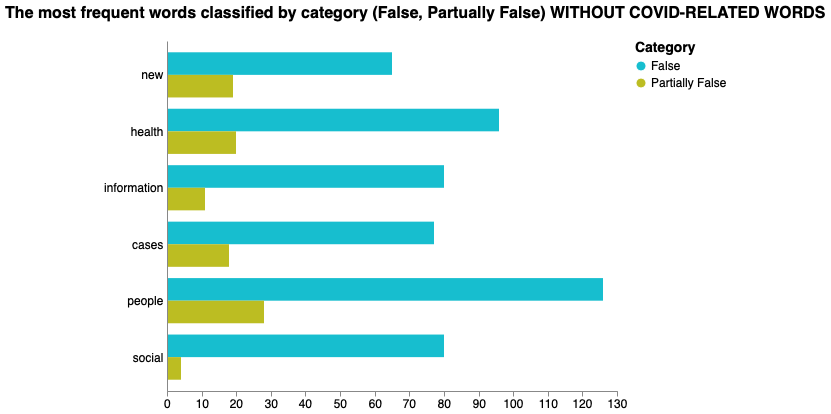

### [Open the Chart in the Vega Editor](https://vega.github.io/editor/#/url/vega/N4IgJAzgxgFgpgWwIYgFwhgF0wBwqgegIDc4BzJAOjIEtMYBXAI0poHsDp5kTykSArJQBWENgDsQAGhAATONABONHJnaT0AFXgACBGwiYdAM0VwAjgzjijAdzaLZEHVAA2SCBBrGacWTqYATxckTHIHYIAKADEkVwg4KR0ABSRFTAY412DY+LgASh0AdQBJTQAJAHkAVU0dAGFKgDUSgBEAWgAlAFEAGQBBTW7W4srO1oBlaRBbGll6NAAWAQAGGXgaMiw0AGZVmRwkWVkacTI0ARk1TFc4NFAwgA9MNBBtOD0DI1MLKxsdeyOZxuDxeHx+ALBKChcKKKK5BJJVLpTKubI6BEFYplKq1BrNNpdPqDYajcZTGTGCSYCY0ABed1QAEYAGwyNjGYwJF6oABMKwAvjJZKEUKgANqgcRIBCMkCYJBMW7TYhxKwQNCSkBFBxOV4URRkVync4yepsBg2XYyTFoXkyZFqLI5OIJNBMoWgHVA176Bj0WweGDTc2WnmLG2uxkRkCOmjOjFRtCCqRe3Ua9A4RRsMJQF5mi1W1CLJmRvK7NmxtJOtEu8uoASe7Xp16nYxwPPqEOFnm8gCcZbdzIHVfS8drifrTJTaZ96DgxDm1igdwLYbtAA5B4ymVvRzX0bbmTPm3OQAwvGdu+vmZWj0yY3GE0feU3vXr0OI4LZr0WNzGjxZS593HQ8k2HN8W3QEUaGyX8eV3bd3R2B1q1Aush0bVNTw-EBZROFA1yLFlSxAI8BGAp8J0AyCzyYZQ4B8K8iIQ+0yPAplSKosCp1o3D6LgJAAGsTXgtAAHYkNQStuIwnc+IzEBpVlMTmQAjiUJA58OIU14TgSDxVxAUMi15dSpxHWTJ0w3T0Fg1xVOAo9HzQ7TeOw99FIgHA4DRVTSPvVCxzcocT0814YECHB4EkFj3SkrjXOo8CwqgkAJCMkyeRZPdyMopKeKHJkdlspTTkyns7SktirKPVKzwXOA4Qy1TeQCji91q8CSo8tK3EE2LjMqvkEqCg85PdUqYCQcQ9Ti28Es0rr6x62dcJ+SxrBuQJWuqsb0Osxl6twwNHF29j6xqgqJtQY7FLbDs1AkDV5ty8D8uC5KVtKo0jnOl99pCo7SoSCqb32C6hx2TrrsO91X16s9ptm-y2PvRLPsK+TEdwiAZroekmpeoab3aqdAa+0LSvobMGC2C18xJotJMhxkWeWqmccUoS4DgHBWqc8CzIprHJq514L1U8TNPIq7MZutqQaQdt-Leqd2dh+9SuMVwGH8ln7w+8a4b5UqoDYBB9EGrKLikpbNaFs22FcWR-qFkWbru144EeGUcGVeaDfAjX5ZNr3MzMQ4zFkL9PFUmX3a0ynsbWrzkD8+bOKklzQ6PcSQehAOmfDO2PZNj1xfQPH6JofzRqT0XbtKpgLSEo4LQQOvWfihvPe1hw4E2a3hqz7vUEsh3LtKhBThoQwmvjtWoaNg6j1WnDFP0qALwSV35sF+sc+NrXK5AZXlGhYebxHI8J9zlLqeRnm9+LnvAt7sOnctuhZStebzKhmXE+qcIqCVcPQXwih46lw-nVJW7YoHzTRhxIBOlT6Ahdo5O84FFgyUnkVcOIAzArj-q-VAS9GR4PvlPU+hwfKILIUHesK8gZ2jNu4GgCBiY2wWmPYqqDvqn28saRmPDkHk1gWgkB6AHKvRgRzRkWFpEgEMIoJApxuEjykmsSR7llG3COKJea2DmECKKiDRqZhVImKHHLY+ODSrGh5nBYx2czGMgRsowwoQ55qELm7CRCixbKLQsYJAeYu51XccEjeekrD+TJgQ6JzJSqnDCOIN0SDtHJM8bE+caQXFkJvjg5JSi8kqL9saZiZCE6XWSRXZRZBab80zgfJJuibLoIYMjVqxSLL1MIWYCADBwFGLIeIoq9SpqbHgAwnhADGT22oeY0+SAcBRy2pElKUzT5QFMFs+sOigkpNPsVVSfShxUPsYIkJngFCXlNGQxJO5kmEIZgJYS-lalDhDtcy5pU0iFhfjwpkFydwsOTksdhbAoBCQOZMjpwNT7yD5oUkF9djmEPNuIFcigvzAuGgspYryAXuEUDPapPDvmLJJafW4pB4iqSJcWWlXisyCQJeDalSwrmr2DhY0gyhMA7Uzhi-BSLlGnHCU9K+pk9qIuTKVH2lSFDwpeQqpup8mmCVEcNfkCVeWsOLErKAygfArk0aTMVyyJXlMwGYHxlLhpMMwjkpWi4nVWr4ay8pxpSCWqLPwvhGM-keNKv7QSmSyECGZcsZJfZHFwF1TeXkEydxHz5fWDc4bqzWKkhCxuDTymBggMGQO+a3W7LYIKxybiNVFvCugc2dMYABt7PKzFAKIDP38jo2+OzlHtl8rWseBa+7oN8rI8ZNiPFLNDbsUqthBJzJHsyoNxyG1pWQN21qzL9UasWFNMB9ARVkIoWgGGNrFWnxgK2tVPdO2nw5Oa8c1i2mULnZm2x1NJ1tttmPDNRrN1nlZCyFYKx73Mh9Y2kApAbCwVCA4P9DYK0asIaomEtAoCQZDV+21MHpQyriPHF1izcNGpZCDTAMKhI4FgmDOVY87F4evco34Khf7JuZlJX5LHNXKOIVtNFw1z3kOg2lUtKgfKcsDda+d-HyneLCMh1NCVeNGrKQRhgCAmAL3mjsblfJDWQtQPnOl9zzk8crYOhwsoV03ljeJs8eNAjIZ2M8u05GTPTlKvILwZB8UBIRRu7WUqp1Uo7eKmJMGwkZ0YXW4568YNMHCXCzOa7P1AfDcoZAcIgvqpC0Ii0igVz+TXUcqLxqhEKjCEymduxL3yezXSmFrp8tVTQ6VIZS54PEayWPCrV7TanyYAwWCJwzjIffcS+tzdfLVr8JBwb8ngO4WhHRhU4XhrTZZbN1Zo32u3Ws+U2Q00mC1361EjVuSYORwcJgZDiE+HLb4815RhH1B9bIX27ZnXVk2G4NApjA7ymHE8EgMgDGELZL214sIyhjR0h8RIQ7L2jU3bSjgZ2NBSv6dI5ueNZs0gqZh8cjHZ4o5+JUI6x5EXvXXey2wJpMoR3ORBzB+gM00vjMM0ydTJnKOn0YlSdIj211ecbkltKPgthcZ5AZu2aOTNS7PPIGaebgcHtKpkKHaAwXWg1YLtl6jZUIVEw+ZJh7kUwuo-ZwNa7mPo+brTWXGu2cM61WNhUdvof08fcomABgNtfZ4RRbOgHvOrcUhA8QIlPVFkc395R9gRkyfDMynYxnG5vcU2MunANYflLUXPXXu336JZBnRoVj25N8fQxbJNMA88ias4XmDlofY+TzIt0VfvKuEOmus6wPfo2of94p73YQ0964S5VzTEmTTN4c5Fob5O1tN7RDXvvQ3CEPU7BaZDon+eFqVY8ehcuDdryc7hWQPuliGcz8kszAm4C6agNCHD1-FJY6XXFsRK-5NCFAQ49ac9U013Q755MVdcYMhZBT0xEfspxMsTNn8i8FBl1YAl9ZNt9ACAV4MW4ThVV-5Z8d9+5LRp8+QPNeFjl58kZtN1dWkEpHdldp5YJud89uov9vZfYKUsDfdy9+9F14B6A9Mz0pIs8FZHETQmo+C34UEk9ykUtzsiCnla8jVCF6FB8SdNdx8YNGpTc7RedIC+MrcQlZARkHtP8FCYNppRl49+D5DdDpdyDZDpJxCuD0B4A4gFhM5WQpI+wJCTZ+QzZlAvAVN9c+Qx0TZTCTsZpIdaYxcEoJcbpoCvIgVkNE8nCzxgCmUH9kDC10NXA2BZh7C5DAlBDqs2Ah8KDwCRprC0pI53BcdVCcC69Sovw-BHtED2ksjcJLFe13CtctVwkm8W5bBjQgcr96jnMsdRdWcSk280pqMl0786iC9ejo8GA8VD9W9CtlEHxDAIgR90VWj1CqNDFtMmUSDcDzNjAL83DR12c0pLQLxjitFTiTNCF5BoR5ArCNjXhsVVEGBu8KCqDkjP5T5+QVhxI-iKjlEZ4RE0h4CR5ujGRjCsthjZQt8BDSDT4ETYTcT4SaBeQWQCSbjGkxtxBY5sTHC4S0DzYzp5oIjAi14j1jRzZVBRD-8dC6SYNb8qi6NSioMPjG5CFU1STe8cTyTQc0hQhswqiiYyS2jT4gJwNO5JTaTCTylm1MFM4IiLcNVaD+I2A4CvkpJGs+MjTFIPl2DCV5FKso9Xgvw0griAMPCQBjB-QtjS8dsoi4FaFsxlN4dtD1jeS+o1k6BnZDtmDRSzZkY1AhSwT3SdYIcEkkj3Ssc0lXCkzpjcYkBAhsydsmQYyUjfM55mdmiTipTlSQk7MccGCxCx5j8bpHT0AdZfAaTyitSYMvBfj9MAC+NWyQBRtxtXDMiwyzw1Faxsy1DPjtZshXDaiSyITlFqMRRkSbxxJmS-SOIYi9CPB7iH93TZhoBnpTglSzjT5xB7sy1R83TFiKdiiZ5CIWjqzLyvEGZbyeEIiLSMTB0ijbADC1jE5-iq5rAYRJjODcyvJ7kuxLsQKJyToFB7ilz3TQREAlQNyiwjzoLXgpzhMbx6sUMHzcJpU4KnlajR49jylry1BjAsL20eTuy0o+YlwZ5sMkFecdys1tYzAcUvznVBjqKYM1l-YGL-13dhK0pFwpz-Iiz8jJDdlppzz94x9ELFJGjwk3iU0Bz3zFNscRQhVxLx4hLKtUjfR8z44lyWTwIjdylOJUZ-DklzKq5gSLUptrjByutkLLN7yaCAV-RA8jL5jTFcKm0aBFwRFjKczQKQAyAFs8VONrEIiY16krTWxxARdkAZVzkqCNwldC0hycBmB2T4491fyBdSpVRlAD83d3onizw55hkVCOCVp3SzB3AEzQCdKmLpSYsZl7jUTkxjyZop9fLAJnKAVjghkPKx4FKgipooocx4AwjIKuz5M19v9-QysEoCqbo9zpcHBToKDRMbKaFlEhIHBdNViqC9ry4lVDzZzG5NrXgQ89UnqWzp5-RkcgLai7qXxK8aAeYlsGrcIswcxB5fqPr7rkUSJFhursCrspKzxoRXiMjdKTMXq7IcUHUo0eFTrjsOc1EMkZ5PAaBzsoqQaSLFImJQTedlzgFQd3ALxyai4qzftkb1oXT0t0yNUXKQBwa4M1rgtKssaQBOIJTXyOaHSiczBPSttwY1LmLJyOxB5SBVYEpuKoYhDQg8Z1l44IidhmyFrT46A4hjL917x5q84yzTzBVtLsL7Tla1tvTxrwJ0S5zdkkBXjHLntCa0oUtu9lBLiNT1qazylXQ2ASNqpjb7wNDsxRi6AHbspPKndVl-QqivAWrhocLYrThZA2AHALzPblFsVBUxr4K6kwqPSRlsh2Nqji7YyJ00RqTG7x1S6touSR4wT-qpE7UHV7iIjY7HZaEfEtoMiiKdhe6pw7KYNoQzBaBBUQyELnavITcUKMam7lE6MmorFK7bF3SMg8VhaPFQa0jopfAT6DdYrZhXAuE26VzFDfJaAGzWrAFq6sxOFS8j8z6JZrzOQcdX1Q6RbV7XhFwvB7imQiyGbupSpWQ6r6wzrOZlF+R+QmVaip76kxaEBhBmA2AmQEAyAmA+wH7-SA8-BIdSGH4b0JAi7VK-KZb0FYIsSqHDk4HDBVICaPc4dXTJL1LfReZB7TKht+b4woaBt-akZ8yC7xGkbRaqrnYwxeZViM9f70B9B5A8UPAqbObo9lA3rSZaikHKELFEBk6yjQo1GQAnFS8405qI9CrSo2AmBFxargGjorHAwLahrmQtbFEnZU9VIfHp7kHyl4BXAWkakqDeQ-G0BZ6JN04FaixgnD6v7F5qoPbG4E1dlQi54gnSd+H0AMgvxDtwTGaOcJABqBix5MnPrT4YTM5ecQnFlw11SecEoKrG50qq4u8gH4sx5jHosGi+Z7tWowTYnpJp40geZLD+zeqvLT4j79BYIdHGHlE+xwNwNoz3TsUfByVzHUAja7YynbKicEhkM+wdtxJh6pwc857qRypSE36aVq69hNnWHQnbsOwEqOyr7Dn3TeQNwNwBAPn8M0o1d6AVMdteRraR7lFFxvxeGV6NqAmbA8tjFmUw8NVsnB1NhvTkMiLBmFMvnaAUdy0mz3SRRS0W5ubxlN727ykfY3AWb1b6HyJ3S0kmoEWfw5EBnJHcJI5tnq64hlVZp9GhXYrWsvAYV7s4A6QJXCn5RhJbGiLFhmm4mc1ZpEAccCXU7MbUkEBDgIlM4fHamYaQlTB6zlIZDL5QXWNfVHUo73GH1FXzZLZLQCZs7NzdjFX5AUtas5mpjYrpokdGSpaw69KYNDhoqqCbmhwDqzwZQbXtH97T7q7iARkvw1ElRS8iKJmhz7kto+mEC1NJr0EHAeZFAVMiL91jl4mzxqNxAqn5oUnq7rALQthOGfWhshyZHS8g10Z+XFJwnImeFW3Yrut5AbBZr2Xq7xBAgOKnkfHOnFLlEW4Xc71nXhTg3BJIroroayHylOEjWK7w2QG+qF9MAC7AK7XiWli2ATRtgt2Tm2G6UBrOzz3w6eyYVfBhUEHLl3Sm9DiL5nRb3CFyCmpDg5gFXQH0AIPFBiEmcm2GQaj6XH728tXFBVRdYDnUK23sULZoqMsrHFRF32aI2S6aLvxkMtzxC42dwxbFwXyxFoWHG6nJVsx52wPqYop6zaxSmrH4PDiTSYOL2zxmdFw-3U2XWe3WDvFgbn2MyvgxynaVtm5UsRRT3yPP3I3pKlwnWyEWR8cGw2Py5+a3WkrFOP6DACZWWyFFhjPH960hzbBZlI1uOrz+jOKOnSkf154ajoWJmgC0hAs2WFjdG9JVabACLEbNSxO1saASsRkILyW853TLRBVvBfBUP5ndOUbqRNkwvQrYqlBeYMlA8N7cvKORLsARiDnfS0LjgCYyX7PVOFmA8LYIdbG9Wt67ULRYA-mYG9Fc9bgcVS9jOJmxbRt9GknGLQzYOQAzHDRlwLa90X3tava96akfHhZDcnZ4NxArAKDc7FWxAXZIEkXD53SKV-Rc3hH4uvJEvrBLv433ThlZpLLiC5qSO7impryWueE82rGzI0yamh3Xgsd2TS9x3FXn0cdFTpO6jYqoOTru21PaE2mx2CmFvdZoRl6q7YqRXfYxX+2D3qH9FB4A26Wqveu+TsuNa+FTPnILEsP4f9ZS253m2nke6rH7VlZzVROv20pwkoAetKu3zvN+40RiiGBR33qaeGWez8zkMYeFuh1GVEf1uU4+vNsYuU7HjqanTbMDG-x7u+MxaFQQD-IiKDSydfMDAvXHaFfzWj2m2awXu027ehElx8mJG23ORHp8edPJeb0ZkfLUvbKrGC68b5eJeT9TacVdZ5Acu5HV9tYvPGy0vDfPxvaDJVnZPT5AgFAl1ppYUPOQltVHeHCKPafMczAZ5tMP2CtfW55zZBVjLjP6P7WYMM3XAs3FRYI6ALa0PD2RK-Qnm7SGGFvQjuvvvs+QAoSINA2oLYq4AtiDBBe8u1shU+OQrXVq6UzbAm+ZOHuJYKAPuPeT++NzPqRlBRstOc6yfzr7KQWkEbezWba8T7JyKxEa3YWblykdMR4Pn3R7KIBAktZ5h1gi7oAKaxoAHtth67sc0C3kZ6N+FJ5+9oB8oJnI3i7oppjOqmQ0uGgMQx8bwqvU-mBWh7Y9yBsGfTr71T7UCsSeMShvpkNpM93ocZNIAjWr6WN5+IoTkOoiGQgD2u2pGAKET+bqtDmpUISGok5CQMqBwg9vCr3kFb8vIsvWYihQiIwtkk9bAVkmi2Khdqe83agYHm8hm1EcP1cvhHQQ4RUDmxnIlkOT5wCUvUcfRXuCz5jVhXamvKxoh0cAHNR4cdKxmDgSBnBcBTvIwQoOlzGhXcvLI8Cu3Q7gtlANaKzrFW9zIAyO7xFwfEMTaJd1B-7aMOD3QDxV44O3LXnrmphqIGU1TPhkNh0GKRoQhrdRAFiqHgQ4hANKtBkiXBqIcqW7CQUOWEBrIZo6BPITNi96NIEq4gSzt9mUHVcJMagBAMlyp7acPGvAhvIYBxyo4ChcgRADNAoITdNhswGPL7Sz7+VT4-Qw4EBSHqbC2+oQnkGQKF6Pkxw8A5wdLQL5sYz81gc5hsO4bFpQgA3TODbzYHP8o2Y9CfqTCLISDumHpZhsfyOzz8gq2YG6tMPj7wkkA00NRKWj56DcrGJg4PLN2GoYDfWHKLtlP3kwJtjShBGdsi2v6Lo6Agebavpj3RDcioYtfQnQJeHUDbAaiBuojwkFi0qQ5BNkYcndILkhSdg7wYXXvrL8CeazGUmoHHqCieBhPd-BbA0YwhQSSIpAXySTTqINe-TaoVAWphf1HsTTMtu9mKIwjehAKRQB3mHQ9CrGgdISE0iBQCd5+paYokBTFHz81ECANuCKEx4ZD2REQinCVXWEtsNRWQ3QeymCE1YbBbmEfn3REo7p-hTBS3FNV4IYZuh3PNHiYQBTv5Xix3eMcNyjZwAqibNEeKlT4QkkckdzCTNCGwBNRcOT-FZLWQkBcD3QNvUoQ2FJRiAFRyw2KvoFkpSjg+z1KjHxTIA+FWuzvNoe9i2KfCmSZvI1PzUQD+w2ARfKvjPgN7HIyRXkBUJyDkq7VfOE6T5EOOb5p9T4QnBUCjBiGR9vhNhZ2BNjbHAUa+mo5wv3zxH-M5+yPbMO5XUAwjOxhCWUAOOMoncceXwKWAuJD7KJzClAgkdPw7BCRbgngVuskMVYdEKCJYO2P-yHA1jVc2wq8VMNgnUDYA8Ev8QCxhY7BLBMWIosoAIgZJKJaUVYMWQaZntTx1AtqCsA3BQNeQ9Es8B3kNZFEi+6okUq4LPDZV4cWI+fvML+HjJ8BWE6MOUOiqUVOxQ5IeAPDdr1gP+5PcpGElWJ3CVBrwMIH-lXQpjbxaUeKsQE34zDcJeMeDKROFbGssxwad0kJGvI8t7OVBI5kMW3qghhhxFTARvnwZCC-y5SeKkzjLGEVEBJtLxB2DMDbQvhow13t4jRCLlwx04iOusnZIWCiu79BKTBn0AU1+2eVU0aDkDyxw-mnYsWjsOzDQcTxUAmUTBgVJdCUpwkl3j2VcxhB-RpME0XzVSSZVbMzUzIeU2eIJAq2l-D8ZgPNitQfGoKKxo8HSHPDnxEYxSJDlLx4dYqesbKYondLnZHx04JyvPwgFgEOeJwqCUgHsAidap40xVuTTURN5OpjGcIfpOgi-NNp-6ZHjcPhgHjTJzmH9ibx5D-hzSEg7ca9U7B2clhV-J6YtzmmToVuPE3CNRgHHZg3JIKB3JsNwYlNrxV3LyeUj7ATjwZ27RVlGJ94oSFusyNgOuI-FBtXWvkV-E1OeiWTa+SMA-P2xt5EtCEndJgLpjhk00k06AwaVpOSzZgjgePcXlSMhmYBiAEANRCcA34kzqB3iMcEKSB7z8+wLOS6UyO14c4O8vY-Ef2L8DxgdZsI2KjXEYiuE9JVk3CJDmwCuFVWmwooihUooTNUCNXdJJmLESGZa2ZlEIjqlcIgSiJEgT0tKyAo7ZARzYn4aCOwqiYdgGsjVqfEsA44EJxlHbHJLYRCI0RpeTBnNQkHgdMO3ifCVj0In3DjS2AC2NzNeBVJv6kU5nnHPVBuyR4tRVoQ4gT7tgQSZVaqBMxxag4SxEaQ2dnJpH0AGYvct7oEENYIyVMRhVMabUNb3ZRqrUGtjHKqxrtw+RSc0lYzIDqgg+nvRVkXx2JjxG5r7VcqIKJGZxjOtvL2acm4lII90QM8NCGNLR+DmUmk5hCDG0y5ZjKhLQ+sTQgCk0g5DPe8AvNqEZU3AEkzARABHmqBOufiP5inLvYU4hk4ChGT4nmkPSxZFsxSB4AQWQLQxK8sHh-S67gSKW1dN1uyhiheAwZAYxaaP1mEMAKRBC2drlLSipo6F9Vb6bhHzoRU5gqIOMVOITHgtvA5qCwr5NDlhp2h5hByfjP-EApVQCGHNvuKcnYz7mNgaVNb01q881EovIUmtMVZ3Z0guHNbsVLykYUPpT4g+tXWGRkBIchgTeXVIW4YLR5WCwuCKJbkP8Fpw4kSbhBsZ698R9AouXoxmjfy6A0Cylo1CKJy9FaJIoMaRSa5EZ3xyszAZmWnZ78XmDC1XKKFainyu+x4A1qoDLkwCHUQka9kBRiqKt7UIyYfjwoPnlJJZQS6ugiVkBeLhS-MypQRghrNCs0mw5CpwjVFjThF3fYXnmFRANLiy+0ivELjozyB2KQ86uuYAtGeNhCsyKZTfUHl2jXRmCyUQRJ8WQzvIDqCgubMZk34S8hkRZa6x36OLylmy-VlPPUGzywxhcyGZ6Q+6cZQOKyzAfIHhwUoKZt1KxpYFlIHcZydyyCYoUMgUFmSBiligH1Bn9tDMT8+NtrFGoHlsF+My0f9mvKWgNFu0psWCwbZfyEExI44fVIaJpA+ZcXXxQCQtgRpFhsfVBfss2JaNaY+cihW4qWkZUCYf07xYGMhnbohIKmMEjCpEXKJLQX4dykiQZnuLN4viGaOirkX3helJyRpEmySUjCCVibSHkznpD-KmlnzNKJFH5KPAF2MAaiWwHjkYyKKSteTM7L6gSBmWfmXJbBgPK2rkAwgBwEPxAXKqwaENXrLEqrlwtXezi0VcyvUbf96Z6sqxkUVhSNiKlWqpmSpH-g+MFcGqC1WeCdVMBdWm4t1YpC-AUA1ADKfdi1KoWJsIVLiwNEpMCEzUppx08+aXQDkNixuoPAIbwPxi2jDB1KsVa8AQTE1KVri1iaSsKGKgGI744pQt39ZqB54aIZjoyu7WQzDgyXf1fmtwh0gTQlTW1czTUQujMB7gHTLarbC2Y8VN4lJS7QQ6Fcnk5uCQThNxh0BMgdcm8JnJfALyz1dQl1UgnGbaD2i1HZAMALlk9r5QFk+cbguNn5LrFSPRVp1WXkoyvpW49hOonWUFyLlNKiyn2RqT4DMlPmU+DotmYbKOVaC14EujgAFLletq8SDgHuncDJ1WG+cINVSkCzMcsvWCHZJK40BngTefxJ+s5X6zEMo0ljWRrPiyKr51UTsfzU4HxJEeC8whAIOxQnAZUfgzFX0uyGKB-Ygw21XRiYBhI8wxE2FBAh7Gca4NmYWcUJpYkQyuNnedwB9ieFhCW1rUhotpiQx-yOoGZd8eOQW5QMWQqaJfvpoJm2LAqzqhkIBpE29TXG7gCmo+rc2SKAyEVFLneSplnioJFsQBuFNi6UKqNzmWXlyxLy2qfa-8ZOXytjmDplWUsKgiyCJaQj3AyM4aBESy2wLcIaK56NcH9CfYB10mirRpTGkwKhyXgfiecvM1zrv87gAskKT9lfrTUCcpNLavogdsn2GGoUXOxzBs9fCZqvjIAqrgN4WoPNSsVcMS7bwQNoJWNpPJy0KcJtio66cgGYE4KJqPU0+CLkhxCTYNL41XDbjob7a+xp3IeKEE8FubkVcOTjkaGAmFiw5dPTwL9OUxBTAVPZXyMYFdWvDykjArripiXLKTncO8XyD5p2YBzEu0G4aHEvTWvABAj4hrtXVzAwBryRRMgEnLm2Qy3lOWLaGysaUkrIZ1gGShIEmGQCrpC3NfuDtAHalCwovd8f1vFnKtuFkW6gVjjJo8ank+pWVZCP56PQspwWw+h2AJ3Ow1VnyhrYQhSyKBVdc8YjRY1I3ab5Qcu68utjMEa6HVM0YCY507ELaQAIIThNmVqLlb+aFAd-KMWKITEtNrazwoECu006uNKmzAGpttJdqDNOu-2PK2E1vcyu0qjiBCLmx4yJ1get3ZboPzbwQ9MuvHQ2MvDjqA97m6gdRitkLLbl12gNQLUnZHrAemLWVShtXIVCaZnuhLc0ulzSoIgiq5nSi3O3hJB+co-nSv23khdl1y6ICqo14F8wY9PVR6d7rRUyoNVXunXTVX6E9KOWs0C8PalzWaqsVMBMcSISAq85NhuNYNZOIF2RK167YKTqar3k7aTsHYJcKj0IWgKLwPkBlSPs62Ja1sooXLB-ld2F7ghuw7MZDLrEyg0gL0lPbFV-25ZodtqxgI+J51cb9Il4ysiiXA2KtA8PkdST8k2FiBTNCEZdtvr0F4oBpj+uvWeGvLkoqdey+PfoA9QQG2uvOq3vnsw1B7iE3tGVEjuro2NjlOPDPcRG9VAi6+JpYErgdr2-aliT8Vg9QPMl-d7toeSg5coDyiVnur03bJgOLxFLKNRYvqKcqN1yHOxwMoppGik0ArkRsRWCMZRIOF6fdu6BKOVshHxUUK00u9Y4jYCv0qV-BzWdqriBg7XEn4ytSFMyAdreYKfWg6uwnzhaYN-hwvTHn92BpTWaipAKqCNDsAgd+hmDKFNBLgjDxkqTbEYeUNRrdBK4GwcIa-VWw4AMbeAxDsUWdr4tB2ko5arRCB82dB+16q4C8aJF5Foy7esXl3jxGbtls4bf-AzwWGc06QEnWmoW5rCjJKaNdES3vV6RlAseGpXnT6nM4L6yCublPs6OKRZemnDOVHJgUS738NMumbIxWMWapGs0KpI+IH2YD86GULwOwZLgeHKjSa7WTQcm2xUHwdaloWCrPCoNXNwR544q2LJbM5DMCsWrMCYBrrMdVcF7cVslXVo5goKDo0cZvx8x-Q78zg9+hGxqIF1xoBwxFL5Z4LFAWJxnY4dMVAGJAHqFcH4elELdTguDBiOjTuPs6eyag40Acw9lWNhk6yWVhxr33hdTu6idCR5MyVaGQAqwAEzUkkNB6QRFGvQ-HpODgMf+RJreQt3EjvMvBg+kEPsbn3V0hkgi39adpaPakjleOO2AvMhFT1vjCpuPQiZ3Evauiq81hRpR2GlyQ18-HefDnXI2aZ6mwvZuNwgkJGWK1ozkhSeJOw96E0upnTAsIQiE5SxKpwzJtwjzDRkwHQo7apGmLgLUO1PhC1scSoi1J7+rrQCXW0LDfZD+BeUOV0ynRZ++ogbbfxFV5mn9GlRANWip2DrqBxgEUMwuK7yMhcZ+HYXRpKUD1CTKaaFlHpvQe7sweq2ANRPKizr6z9RgCr7PFOkH9ZGiqFbzX3UNnVEOOItSRstP5mI4MJ5Pm0p6KEyhkg23TEGcVOtmGIs0TvW1SIUqiPWdY1aT9tX3iqIc15do3WfwNrYxtzWqxoNrnHNrKTrZjPj8YqPyygqmAZCYAcVYfJh9Zmu88GyDyG6UOTe8vafhlB9mFuOAL8FZqbY3HkIi0d0q8aePgWv1usTRS+bjN1DyV2YUmroZX3UX6jOyi2mCX3kbd4Sy57pV+ayOKRLEFtaFgvP5qWtrAX+6-SUumjob5ki5q006R1GKbscpaMA8eicHJNMjr514EpklikXHtC3PHhTOMN7mz4-20XtxYi14GOL9lEhrxqYxZnT4l1RcBed3O8LPjiwPI5DJA0cMdLuswkQyiqKcZbzwZ+47jF5gLnI1zhx8lYpnPfn7ohrGavKcz0hbk8y6MK-vp-1pA4QrhTvsjrG4isnLQGhbt9VUvLHgLA2inU3qBOM5E6V68o9rvj3em0gmu6nbGca3exbgeYBwFTq0V6Wk2q6y6RGaVjRUiy6FoRMRPMJxb5cMloy-FV9nRNBT2sEZD4GqP5XfNnnYVeiz1F7rwTNdVwEtffHdXs9OYZ5Q9p8ugSsMVOtdB8cROqglMDFkI0NJRpN5Y4q06aUSyFPYpmcGQEDbapF5bEgj9ctc9tbmG+RBj9CxVj7D566gpUG18M2hUr5iX8VC3AzF8eiu8XXqBdVQFhdbMDwRZgV5JeDYySvb8avpgI1qNMFlGeQERcXY-AHodmAO8-Gmfvjon9WAWKwNqKjY0tNoMr9PQE16drrlq+EmS-mjZLNow24Dp++0-qG8OjVeYeN6+qhOcYmkOtpVyGTsreNTh3t6U8Gp-X+vL56TdR+cM8FtWL1+2+pdixFctmF1dl6lpi22XUTwXJr+tyGfz1R0c3bbAtB3lja-VC7cAy2mCwt3kC3AKbcTEm4XvjnB2HiaVlgk+g5MQNnzealy2DWzBC6KZlFUtfoWzU+ncTmA2UB4HxbpLqoEgxNaRS-orX3S6835WEEhoYqE7MVgEjTPohhnY9We8i4ZERG120b6AESKMYQs5TUJa-Tjl7chktwk+Kbf29QMMolFl1C2ZA1tIUVpRXTTUd095aNmKsZoqKsbnLZbtp1VyyrIpdAyus0W0WUZFbfWog2nx8qY0-jYugcC6kTrq97C1USLPoH3QB9s7Wxg8CGGwTwV1QUwFwZZq7rvxn+3JYQ4+JyFD+oBy3reG+It7FUssr-F-kvLtrauL1UMYZNboZ5uopFVYy-BJD77fc1ZBjbkHSnZL6ARUMMjDbckC9aUqNoGRlbvjHOZ+gjL4YObnGgboGvVKJjahP4nGTABUOVALHhWhmSW3Y3HBXsEPyGy++64nZosxqom1UWVcXcUi3AKA740Fe-cUyHAmradyScJAM7YP5+xCoOyDaEWbCC6FKMywY9eUKANsME6h7OfnCchRmvNyW3ZDO6WPH+QjuVcgKlP2O676AJkMICWNa7nL-js+AIEUAlbEr13KJ7VdCed3hysEe1DGbIvBTaHFmcRzs3gBNQDEmjeEw9dwgOBz+hMGvak+B2qHiipT3S+g8evKNZlg+0IMVd2A7cYFSjiWDgA2OPYG5TDy1Zxw8BNsy+SD4B-OBnhdCldJDgp2vSPrL2xTHd-lfZQ3C1G0naUXBg0pDlWNkAe2qlFHM7FtP0AuCFU29pweItMnbbHglKhqslWmVkz7gucMQdAXrnMjiHsZtTVR3Jc3lBkg+L-Pz9AW1lo5-P2pNbEADYF6p9Wb6cUOhU+Tp51XFgLAvhohlhxyokDyxPWIxRqB4y0LU2DoLgPKa7A1HO6r9Vhq41XY+kdhO3W-rPg485UMU5c0pz2Kkx3ctcbP6OKFQBNYkpd6ot5SXUMYpibty7NWlFRZmcPt4UFAFhJo4Ow0eJGzAKLy-By+oHRGmo+Cr7m89WMSxRegGuHeifsN5OeLnN6xoqE6u25oqhmTJRbq-CYBgC4RGOpsOQDShLtaFqxshUVDGglLoe4VvRFl7EPGLrVptFsXAcoKVbXGp0bYAdszYVXpD6xru37aYHXHiTse1Q4st6vOWyUyHBHKueXmBtaycZ966AIVtGXOuhUCLqZ1wOE+8OTpUKWTlXCazXlh53VYjeQ8ccKJiJTvch2Rp87dLxVizSFIIuwnVIbeJ+fMuIWuzXiRfSbkn2QODbIAU4G6x9KomLbNNGUIPwpmiZZVQpgewqVnsSQbX69Md5RbmfCPcIyapQRM8RfanwEx7vxwk4VK-V8BJp53L4DcP-PMBNMY+fg8pZPcOrN1IqZK4kwl6R45uCZjfyKI6YxGW90s97PY31PMB8HTpdlUAdlO-TvEzDrB5pxQvqXpFKAPHIgYJWA3VLgQ4m2VGOBCyJk-UzBk5ZaMYlR5ueydNbcnAQ6tb06+i-ubAfzsBFtSGi5zHIoOUDS1k-P3eT5L838e+hIJ8L0G6FQ39mp6RXrHwYX7sIy93q6ZYZOn321hkNmDGkLypuGJlZsq7leTvtUMIVYrx+sc9aJPk78j+wGUBI5LnITh+5J74v0p2NaH-DzfjSUduFuFjqD9tfiLqJPPwzs+HfTAkmtQ71cuHAUkpeguW3wI9IJfOU9+fB8OAb7fu+Gwv5iBlc8S359pomgNXbJmQhTLYd+eLXgjSkYG-ecjZl0Tn+d76HzrlS+bPd24TbZ9dYDHgOOBXcToq8HuGzOR0gKCVPmyrhLYWET0ZZEKN6eRVw9ezmG+cTSUd+za2ye7Cfh2SXE7rZUTfR2k7ynKtDwLvpBeMfM36Wt99XQhabt9vxsxLnNG5MtX+alOCiUM7s-lzI0kDWopkshFQlTHsbhWacd8+3fnpBzHtwk+nDmnSYp8mBUKdlDJP2v3jnssk991NOTFdbm5+gCFnoSGt-NAgn4D+7g+hyGQBQDM+ktO31vuEacKG+asIfVX0EVWjpmMWMP57nxlYHCaC94-G4ezlRGoDq-sqlvXGuILkbkMjWBV0oIt5P1H0jjztDSnRwob+v7WGtQ5QbXI+2+2ev1YQNWSdq2siMAU0UNj18vn6hB0kh5nT0O78+HcKfukhr4MkbPdfd19YZDXgTUDnZptUAV58r+oHC5HoXP47yeYzsqcvHjHRLmjTpuUJ7R0qGQmx4Otfr+QoKHFCsB-Xj35fbnEXFnarOLjtcA73-tVBgX81c7zNpXxb82Hso4M1n5kCWsMec+Rc+F2Y66yyBdORlnhjDqUsNY-W6yb+pdnafXMGTrRtfo00xmQ3oZ56EawXzKdb47xfxtq5cdNDCLju8PerkaewG0tPIbeqfxnEoR4+4uwnb+BvL5PzbTxC6Xrw40ZbdY26OPkXtKDhu5Xq3sJwr+cGcC65l37zHQnVwx4KvZ7MrSs4L4i4N-XVjRTfufFMy2fwvjfP0YfIOMckJXF4wOMSvePWIAwlXDwzcPLawAuwo-VW2cZo4fR2bskrIvEadjFFsy-VQYNHVJgfGN62ywLPAmFQtdXd22PZbgJ5Tz8MAn-QfM3eIawSgefGilNRbVN5R1EL3UlwScHUUvypMM-BN1ADC9S101MkLWcQzMz7SrCFN6dInRgdbVP5xBRppCRztRZkfQFF5w1LkwkV3SNVl98lVFX1Pg3LJ9QNRUjbUkb4KuIew58EAYsgQAWQIjWLJFfVQLOc+ePMGMCddVNyTREVC03v98jAz2LZkA5Mmdh5zRMg7F9ApXn4kKZSAx11z4PkyWd8fTeF8gm8B10Mcm8RiE4CORQPDZcxMdLy+8PScr119Xuaun+9BvRF2jZwvGxWoFpQQMGT0bA2KjQZdTd40MdV-Nz2oFdMc-lM9lnM8FVB38C5xw8dzbey416hKDiaE6gr9V8hNGBpWytq6MDAEDt5ZdEex-AwgQDIOQWCgkA2sFx2b87bLnTNoI7YPzJ14wALBs57fTsz89LwWA1JgbeBeSFM2tBDFWIP5A7z-1jtcoMVY0hJ61TsqLRryGQscDoX58bwH+nn52UKOFStdPKdR8l+gjywM83bRrwIhtgtYWCdYfIoO9tvxJTxBQqCCZgt1JdewJBD0MHyHg84ffIOzAxFPP3y90g9lHVcOgmzxQDGTD7gyM5vBJzWQEcD0yKhV3OBhi9ZfOQJEochZx1d8FuRqR+pdg-fmsdKcQc2LVAbPz3cA8gsJ29oERdXwa8hyGQyJUqneJz1cYIZkwcDSDOeEsAIaGUK6CddBICjhdbSANlCOvbDTSAzvW4Pc8LwY0GwDe7fG1Jl86af1hstTEZnSBhQhJ1iwSBYiFOoiWKbkMhEJOk178opDnS1YEAEAKCtBdbMHbB-tC4LndU5RpBh9KArjS6FA8NUJJCJMLYkhxZPaMJ11ReSKnGDbFPGEidxQpL1E0YAfCEVA-oYgMa915foS6FEg6Py5xHsc3DdCqMEbxP09TSrAt1ASKvHCRQbHkwK94AZ1WCCGtPkSTBAQjnzzE8YRgwx9eHaAG9I1QzW3bxRkODxF9JfRNEEdvXC3iPldaMcNWR1kYhHjAI7W2VjcBSe7A9Zj9JnXA8hEbo0Hc+7Tly+ZPnB0In8+eLnh4Dx-PUJgFh8F9H-1s3bf0Rcp2TnR79E3d2xSxY8X4L19HfeDA70mA1vh7At7Aa1OQ1WUUwfCoArjTNNYIgX07DBdBQFlk4ArjUYBbXUWzEZUQgFDmBII7aWrDKwn-TRFaAPd29CjLOPAoJLg5Hhs5cQpf2c8NzYrEOCdQtwMhlhAY4GNtYxDQIeJ11fMnQDldXiklVS8dR1I9McTqiypFNZOwd4kfZtw58MpeO0ojEXUKSNBFvEnw-1qMHADb4apO-1WsQkfWiqD2lL0RsdUBYQI4gNPaFEAsjQoiQMQv3D-y0CoJU2Td4XfGyMwDZeeviUjfwxrws46AKuyOFI9MxzngDyYxRCDSDGaC64+QnkD2FY3HQ0VDC9IZHtQtzQfyWDh3SHQWwoo9lz2D5Xd8V+89XdEVtVpQbwDwiuPQkNk8HNf2RYZ3DMGz88iVeNwQEGfUmzShVPJANIFf-OlHtV9MHbllULdC11ajA0U+Um5yhUSxIiuNQFkWAUbEsMjMcNB7wFD0gy3lkM2QjkVpEVKJaK-U6RQz0Yi9XH4BZlVFEyMK8zwm0JSEjRG8PdtPIw30Fd-5HpxRosgVqF5wiWJnyXQw+KcN54kAHsyL4VAzx3Dcd-dknCMeQXHVioqkP6I3FYhUtRi1rIrwNtCHlfK01dt6IDiesKDRqML0odSxVOjGvaMTRisUc7EhDUw+PQkAK5EqNxYPvW1Q6oPHMERI8q-MyRrc4I6EMhlwmIonN8UDTX30AGxXmDZj3wlq0IRNoNYS29VveSKF9VyZCihYK1IbEmMAnaQJ-8KQvVzYA24RL2+jEXC7UOivo7yKl9noHU3O9sgndiOBBIvMN6kdYP4FYjOghMLPAKIQmPP0lAFQDz8NgwzQgQqiXCKyD8haunWNtQ+rylj3bHSNkBQUegFti6MIPyeDCEcAUxjSURoyDjUNGxxqMpoo9AgYblDCJ10VNCwmVtAwmEPQJElB2NpipDRTFF4i2AXhPk9Avj3fxP7cqPDCfIg1WdUTVGmPYioDdgGa8ENCuP0iuXOkFoYRCLkSkdOYixDY8wovgOBD6fGqPkwJdcBD+4wHFJ0xCwnZuIjJHgrxwHwfZRMiEiyvJcL+CuNajCEhAgfqPTd04nXSZYk+MfxHj2A3yDeim7aJ1T0tWHFFbjHwxr3whd+FgTtgJmU4PalEAUOJfx45QQTTjm9Sd2QBOWaUFrU3XCdj5ghkSnUztWA9nw3jHgZcTJRT4neL1co4Ak0p0xbQ+KVFs1ILQkM0HaswO49NEFH1IiWfmnkB2wUIBTNX5Hl39i7DZ0Mdt5YsJ28h8YA0KYMgDGjm-0OfbtEIjq6VZ3JD5Pd229p15amIaj4-SILJUzgMtWqiHfeX2tE0BJgOS14w1Jhl9JYlhMa9TDQcLTD4AZQPiijLCABldifCBL-CucFYBgBQTSOP+wV48uPFsmwobCFMXJYogfiTsZ1VzCc3J2GqNxFZWKAiBtUuOzBiXE-zRJs-NETSE4XOBMJlvaBmO-jtFMxloU-E7CwFcgk4CKag2vUJIGCezDoVk88o923k0ilVGVjcjgVUE3st1OKxnsdEqtVmhmubgIMTg4M-yL0YTe5zcjNg4hFtwzEmDCKIqEtexCFEJY2wm9ZE+PTOlPuTPgESD-BtifhAEjSJ38sgD31ISmIsBjng6ABhKQtybRYOPUiLGYNLom8YhEDtxPLJMUx16HekPUHVBvDTd3QGN2WC8IQRiy8wIuICZw0E1wPrjaHCGiZtivbkLuDKdCX0njm4LYinYRtLtzhDOEj8MPgPnBKmMo8QydyYhJVQoMriNQ5gGEBHoKj00D5MC3X0gf5DEN1DGvOUy6omg7hJhd+eSpKWJ9BA5lojYLVLBqSerMMP5imouiGfoaAej1KTMIsPg4S2ot2J8iIyBZLWiydHVBh84kxr2oxWfKEP+T6rHUShT1Q+PSMdeZBpQZTIzEsQNBTLcgEEgSY34CFizYuen9BRkkM0WjGQ9qlfwxsO+2JS6DFOMNisoy5L0syULLjrEiQyO3aSuNDRAsJt46FIHwZkRmL99Y3cjxM1pQXKPaiq1b+DJoMoHFK4SBY7UjmBGAEmPfY1-KxiKd8Yb+VFTaAeeGjhMw6gUtAQ0lBKFVtzDrGUiyXNEQD9PorxLgkLOUS2y9NfDgJ7jqg7ZIod4UxDz6JsOS9S8igEvFPdVhddvXASdvZoNwgNmAHzYjeRH9GeB6MHNNJ8PSBvVgS1LClNzdFAStm6SIvMaJrTXYqRMIQ9gXiKGiw44ZHARkUhqG5tJsdcK8RwgppORikAeOSFDRvWN2xQEydUFe9tk60SpI-kutIDJ3ff1wHS2AvV1902AJvGEAiGBgHMBbADNlnTABZbg2TTMNb1dS8pUEFcjXA-dP0RWsKNLLwF43NMUhc7a9k+9J3XTAYNvAEZHik0onvnshLEk9KfC8IfMnENBKXFJNhhbWhj6tYvdIOlk4jVU0wFxIV-jv8v0zR1phRZFqyKpC6LHCF170jDn6haWKx22sU8JVMkT4Mxr3i9ZUljKLTC9E3S8YIggDLbUinJWPJTB07XBUSNfTAUacg7FwOvUGvJcVz9ANYjL5IFNVdO2Tm0GwA74toqFFoRjNSdPjM3omjMYVVgKDMvDMcImFk8tBPhAmYxY6xmt17iSekKSGYAums0bvMz1mhC6BNLYjYYsJjphKzFCPl975aYxrsrEq8lFBryRTUYAcY2eJHcOTe0IXSjLNqB0DY4mU15lW5OQyC4pBawECA2PMrUPoZoJHBL9Fk5LG5cVGJ4LFpdwBkMhjYqWPyHgEePSPdI0JXTOUdMkmlK40zuOYH-0jwzjJ6TT3b5ntoEbf9P2pfMEJSqJGslvx1QArAzIag7kT1VGyyHGfibSI3JMKExy0uX0rTutDwGQBJs5-WSlu3O1PKQOJJCMz1pwxhSYUXMtbNeBafWny2y1jcQHi8Vs42LBpRBQ0zqzq6QEHnj7ErZQcA20teNZTC9LCLLTbVF7zizEXBEjgEgKPlOdwkATE1A8JUtKGfRRLDlIez0FVVVoAGQBbPh8VEBgAD5As8NPSsffYHLCcoOJQ11iw4zqh4jIk4eyBcWTTTMa8ReclRN08E0RwgB5aWHIag5pZGBuCXk7KOrNLYFNKH8nHOYgJyEnfzH71i4rFBR0p2GsEQTKs11mZpiE4kO8DyUZ+2Jzgs0uiqRL4xv2ztRA8cK5ZOQlMy0izDJjGvs6UXrUfEIc7s0kChchT1ND2gmeJJyZkwSAgCjYtCgC8yU9tJEyhcTFzgxnk4TNYzRNEnnqjE06gTbhXAZQOkiFdEITESP6bEOBJewpGKMtIoLHGa8-Y25NHpPoW1TYA9VVN1GiddbBMAYyMpOM5UjgGiRBTjwcuwVcKrVA2SczgIn3NzefaXIgdC873VR0dY1XN9CJlPJKDz8jQ1yhzbVfzWXAM5GnMGQJRc1IvQ3uZJyTQLmByPSD15XenCQazXyA9i6fJLML1lwKVD7BEs5VPj1vIQSGP80s90j8BgSA+PND145tMPyDQ1eOjTXkwZMzAk0alK3yP9bExPzX4+5WJp1XSaQpzWs2AELoGHF9OLTFIIvnoyAbZo22sSIXkBgAo846KKFCstKEWdGCSzOR0jWS-NUSTUuBkIy5UohTJRkC3GML1LYyPwfyjLehDEAbU0vL2kD+ACnRzoXc8CbYl6NgD7BlTBL1ZzSKcBDpFO2FmzbYCkZhL9zm4IogulDOP-Ijc6o2bJUQZCA-GGDaEnXRzZ9ZO3LbzSjE3Fbzr828MVBzzMA0CUX4uy158TEm9n4Tuc87PQBnGIFNsSu8umNfdibNIMndUaJPxQzEbYwUCBaAGAMiz7c0HCfsyc2JL2zmPALUNdC0pvNzyYpHQ2N0PuI129TdHNJBNxeIzJUIQqQaXhUSLMw2GSRrMxDl5zAilKJXyjLc6OuphC1-Rh8b1IWFac-OXx24LveD9X4Ktc9z1OBbuKfL-UTlKHM+Sxc3qVNQ4onPPqteYU4yb10spShljjUzlML0p6Td1SDQFHyGPFzwx2OsdS882wjCuXJUE2A9cmApVoUBN4IByM0jSW8Ew09gvo0AsergEKjLCHDMAzGVOJeyf4o+iAoo5AIJRTt4f0NtVNsYGJZSvMmwl8RnVZjQOLrpcQH9RMATKJQLuioy04hDnOuPfdykhpS+S9CkAB+VKaNYuA1vAVaTXQ+jRZjpEbJQ0OQiPshFIT0Mkj1BhzZi3CDMgVgAQEmjUixFxQEeYb+Sfyfsk5LcEm2CmQBjCZImF8Q-3RvPgjQgwjy+crc9229wrZRRMRdVJYNOdN4lbHBXBf4JgvQVwcI1JkLFC921tdLojiHX8ryW3z8AW4InxwKE8-AplzhjW-QRyaI5-zCdOEC+JdjZXREo3jC1JosL0K5ODLbiuPXkOuSh-cQCfj7s90mKzNi5BNIjOBBQGyct-E0uiksOTomBIowqLMAE+pFEEIxh41AtWQUQl+NlVd8HJOgBWXac3RKvIWwnq0nCipluAxnSAs7c3ePwW-dxIggxmKNYkYplTxAIZW9KRKIh0RyD8gjkmVMZJmPiVZSE4DIAmreUvyDscPxCp1PRfyXoIaA3iPsE7DGWPZ4hXanzYUjtPLxpyhyL8CNtkxEAqGxIRE+1xKwnIFKrZkzaMs0temYg3cK0oZUzlKCy4Xl3Sl6WsynKEnUqWcydyif04QLCQYTELE4ukvj0NEGrUo88MoGxwyrYwhPaEwiKS2OSMyaZi6KkcsBjgAmNepLBKceU4GoMni4Yye5O8uJ0+KsQg8xesRYg0XaEEyAfOUs1PT-LjjJ0SgvQ9N4ZEwNKjLeWj2t3iusrJd3MibBhA2S5fxw4wIzcyMKE8UrNSR3HCOwqiv1L8BmR12QPD4Lfig7xSyGI1DMwqYUa0K5yNU-2SUVSWTfSHzyhBV1tSO0zsoAqWKwnkTKUKaJmOyUaQs021hChQHWxiyvHUUMMK091RFjSs+MIQ7XJABTD1yxNmIAH2GojYtCkh1FBLNrLPyIV5E64r5w9o7ZNBBrAhEp8L-8iyiDSmA8gF2KwDe8QULXSn0psEq2BvNMhppcrSHInAroWQzaS0-ML1jgTbPnKYXC+HuJaK6ANUdhCjbU-pny4wq4112TRi9DvIsWjUyko1O00FOxazNEpk7fRgjs68xlnGVtWVrw1yK424tUMk6GqhVzWMgtneFUs2Z2XDw0B9ifTmy7a1NR7DJ0GuzNLIojgwDZM7KRLc+JKO0re0-jMKEmoW1zPLoUijOM0XowxwZBpJCuMUzhmYqimLIQ3cO2TGAC-2+ybPOSuYL-wqaqwy9PXYrVSPiy6r4scUYrCVcSigZJaZFmYrHUNsymKpodenBYO3UoAILI6q5seoUHz48xF0vgTgDYxG0dUWIMwEUsaXhdKdK5uEzz+So3lIALohKoqQXI1Tw0riKzqMArjBeGt-LqBBOlnhbVHWBXi8HAgsRdZSm4G8Lzy0Twys5YgbMNK-IlIM7ijLTvAd4UKm-Mt1CzBAFz9VKwGNsysyumuIqrAajGWot1dCKOj-E9+JArbjD6oQz8dAZyp0KSgO18hAqn8N4DMKxLjdzwwZOXL1WtPwu9xoqHxh6ipoZC02we0itO6D1cu3zGqEfPwu1LHq45xHKWsjeLEVj849K4zprcYSir3cwornTTc4Qq4Af84QtixRKj3MlRxAcVhxqfk-jnLKLU1TJNIIa3qv+x+SXSIwLYqBdSdyFc6unI9uWYQvkBiqTrN9yA6kHI0VqMV1yIzNheyGEKDogourqwnJvC2AohLAFTTMBP2zzqJLbMioJytSqW7QfvZcrPB8qH4s-TNhLXxGibyvzwoAJEquu6yyXP2GMymPQlQ+5mUv6lQNI0WTyM9trIXS8B3gkOrbrd4o4vSqfA4VJq83vdQXtrVs7oI5zySmnMqlXAFi0yLtY4QoXoDQvfz9pY3L8CP5hChmCDsQMoEsBJOhQCLPi+RAeCHhm676qit569INhSzZcesKdscv5OaqCDVpSZKfI2QBxjT5DsuF9nVdszJqv1PnGc1bVAQF3B0CpUrYlafaOVp84Cg8viTRCigi1rqBPsF3BbVc2GncesB6tF9trQAuyKhKjcP9h6yPPxqraHDhRUcAysCtHi7+R42YbQQj9yCKca+vmazJKw7S1LDJDTNKL8Q0qQMtUGuoTb1H3SWoSdwaDe3JMMa9RnxgQwmMXMyHypyMsbfMrGS-EOQRtNIb7lLShbguyiPmsrYqLeGqTRa31i4r3i9hq-UKqi-XdrJG-pSKqXE90A-Km0agPEaUipqqsYmqI7nFKpwSUpmT17RHTNIeykk2PtY60Op9KCQtHxsA9a1ysL1iyYFkOzQKxJuFNEI21SNp6m53OLqMkXXlYdBygKkQVGylOqUaNCAxr6LytL4l8Rp3FGrUTGUhGMewh6jpTPwDAFb2yqddWim1S-aq-P1rEXCMhTMhM0+pXqEnbBJ8TJmwMs4sB5eEuirfsoyylRIVFMyTot06DIDoMrGaGXTEy+Wtoav1OWj28zGyBPUU-EWd3tKcq2unDrEK+PQwp30jmP2bKvQoQLT04DuL7CrRVNwTI2PaFkKTMCFIIEa-PJdHOxpQVYgxb0goqvOq5PUpqjYPVd3hwbIzeBuOaH6xaq2E1ha1Jdr5QHFWN4KAiUOphiiShMm9trQg3ThgqzoKeq21b0W-A83RBr08iiJGtLyhbEGAvV1molrPqJ-dEJ2q7Ei8OoFcGQwGxRrVYJoW56W7nxI5pqH3L2aFqvGL4d5C2bzjrykaiIBK6i5FDnhv6yh3ebIZKrUyoW85MvZDlAciNQ8ca9MSX0xmcw02FkYepQhapmr4ndrK3WN21NR5XVOtiNQ7-OdgaE8wshlrU2YFriXy6uiL5IGOZstS+pAKI1sq3XnJKxPA8JRdTm09sllwuQi0OgrWjXhp7lyWxnDlNeYi5r2rE2aIr6LMlMWnDamatarLJykgpqACHmmYjCKa29OnYTW6yFpIDKmlNzgqQW7jNTcs4i5Oo9FWQMEqbTW4lucJaATO1tVZgFWFTqQ7ZJNkAZ4esTVK9GiJvJQOw1xu2tRtZuM5baojoixTqBG6VRFOEVzmwLDKn82Kbb2r9Twb6crjhxr4ODBBdbqBDkNHDB23Fk-jyTGAMDaTmxQmUoqaqMqsqKy07mmgeYJtW+b3bMJARJoqAD0KTl0Zk1WJwmyGTbh1FGIJxqxALYnTMkEJckbbcIeisvb98sxTARNW+Vz3bZ4DMV1SYmuBQhpgOUBqRLlqWrLERr5a6Ko6+AddrkMhLLrBGRM6lWL1jnfNwrEqgy7eDGdhCoOyUqz8DhFFzPfH6DEZHqLxyHJLQLQuVqLq3nnLdHxKsT4RytJnyXy+wbMLtoKso7PSaGhYMtuqgSlaubqZmsuv787kZdrlb3bFRMGrBQj9PJjVtH92xV-FH+VY6jGqY0vrrBAug8z2m-Or7qlW8tq-UK7DqTiA2PNjuyM1aMetk7bka4vS61jR9JHbDWwvWigcwN5uvhp8iwuKxlMNmpaspuBwADCpmlSRySkAfoTN8canVRkIiKhJ3YUiSz6Qltz7EJE-cfrEy23Csus1rykYTCTs2bUK14BSwiwhDkBzwMCWIubMGkK1pNhCoFPXtL6HGtFDbVXBlwZFu4skO7mJBWrglUvYQunck+Aco4rEXJ6xOAmA70XmrIO-qjvor29IJEhrGs+GGTLinz1gCUO6Zv-Kuu-KL4AiPXbOy6j2MgDEdBm1gmSlAazkuh7FmXelZpZGxpoLpP3NzD3QWtIcjtim2ettAr+W9AH5BxIGzvx6fuJa1G7Nqyspnh1683jNheWtn1HbGvUbHbZYHGeqe5WesNvYx4enhBijtkq1JwrWW7QNwQGWzRhsEYYsGMcteO5uwJ6ikskzS9DEjes+MoGBluL0n0vdDG8UsfmqhaRC90rkiY0tE23pNe6appanlSys0bbFfds+7S0VEQJqEnFcFuBG7OFKnajLJ1VWrLmnrLIMxuldrPAwcz7vk6DmUTHGLGvOhGMU8uzS2RdhC5Qqe65GykM5lnGIHtYTXAeIntieq9mqMtA7ITt1TuaxFwd6ZoIuMhqZuzMCaJumgvoFq4gZPrhbS+yBJH8puqBtKhrvGpFYFTiyck2Bg6vlsCFlGG+u3SFwXwBUSV3ATpuzcUfh0EqkvFkQAYs4k+IZa8YI-S4KvO2nN2NVAAfjN7peqxlaCVzSot7jOPATDng7Kt+wzLcYCfoerjOPrxBhILbeCyrSe+fkBAifGtgH7uCZyouaSSxqmordUgdg0h5Urr36S-MqdTUQPosttBTaesOMMQhSLhizTLEKnR-Io+VvmqSlmhpp2YtU+ilxzughwAWDWgz7sO5Zy++qZDZhN6rSb5+IMhQbwexk3dKau6poxz6EFcFUBI2hcIT55AYovN7-ZBDk9dX+l9uUdvafimpyq+9236FDubcrMLN+hP0hIG+nFwBaaW2evgwj0jZrIG8StEULqPa3gWCih8YnAZbEW9Foa8pub5iXqDWh2p100ReuoYzao6IrTKKuwQa8R6ML+O9quUs8k0YOUmXuKZbB0NVbF0AyIy+C2jDtpj7te9thbQI65Cq5LtrEjvv0KK9TotyjanUukHC+mzPl6WFffvWzqMBlvYoO6nYSl7lmoT2zAhaYDtBxaYK-1X43M2cp+sqSb8MrzY3J1VnhhS-yvuZYAAQX1yZqBjpQSN0m2Rpz+aRIt-hD2gQaRKCWzxO0HqWqwaUVTgd4sBKkSz+mdVK6osHWd5+Wmmbr1FWvsS6qAp1vJR4mkyljdpwO6MLtCksEI-MIOjwfiS-4pdtHzn0+fhbgrDNop2ZqwLrmlBbevV0Lg-u+1u6Dz+6PtR6DATaEd7NhxpuwikcH8oR73sNWnuHruNHxbokBtMIV0QPNLvC7XaurnyrdS5tJ2BN8hLvlsFuQEGCERtYFXSqtiPijilGmCmL89yaDyLmDg5LYsRckOogouGSA9sHiria+Xw4y9bIttCNZkkYdi7TuJbX0Tl6orsIL30iiO8j0MSfHbKrGIzKMj4OkzOyJfhWZAT7GvNCS965+4Lmh9hCxYCI1VAQjVB9bVFeK9IuZZ3pf8mASEKjb49LwnbtZCiTDOluR10V5hri7PrCdLqa4ZSGTDOeC9L4yxMO-gC8xrvT5tE1Pum6BasNQKV3Rd9vw6mqWoa2VEOykbgHq6ewz4zm0nAGIBFSi0aUSasawGNB-2j5qi5CunQaVDTyBfXIr6RnHg5RkhoIepHIx4vFlx-RtMcF1QgKOHP5hAQqL-0ygm4dCD78ysfj1RsVwDsrWBqY3dEfR1rIijayxsYhNBtF9DKHUa5ulcBdMd8ptLm4rAYzIzMm1PzKbRhqBeq-rTnOZHEx7jP4FDagEYvLfSs0JVq0+qgpeDEuSD3CK0KTDzGxuelNuR5ZSCuyyz2q8ofBYFgvP3RS4JYfpbHARp1ugAyYgMZSEke1RvJGf9PBpFGTfZNOSLZPUNtUz7ZGHzxbvkkJJn86Aqt0y4Z0kMoPyd80ywGb+BgpNdEh4NZqfTcKu3uSbhUFLCsKIxqGvAy3GD8cwiIaeIESi-rfYv+6TfJWpbarhIJrppK-IxMNFmU3zvSCoGInxAmgSu7QyLVR0ePgamrMPufDmTSQfz9MR8mqs0hAnQt4qLCsiJcblWyrodSg5b8dtppueXI+LGmtrMMprSjppndL6ljzRLLBjmvINiRxr23UiDZftwnl-F8JGTjh6PKZxvRT0ZjCue8UcZ6VdJ5LuR-+viP7N-FNQs+Gu5RQCyo-kp-sjFi+gXsnGYCfMkgbma8gcigvAR4tx9sxrZuQAF1PrSeDWtI8tcKR+-Xu16TgbHMnbnR2SdpS79RksInJCr8oryca5mn4oDR9dXtG-qqGuMq-eg819SBnRSa1R7iKnwG6j2FEqqbIpxFz54JNOrWXGEogJNqKbuvCunkcJrMe-6OfXRVJobqhgYia2-ODrTrtrWFooAwFIyYAllzAbxxqEki-oLGv1ThEwz5pyGUvKL1COxGDCeDKR5tip+PT-i0gRVqOCIJ2KOnG1EciJBqLxlGmzAPOofzmkCYHsaDaC4XwFsk9psfKPaOkwp0eARcPXqmm0wpqGH7F-bTpCJ3RXyTZk5sciKbYhSAYZpbNQjqS4mfJqpP86uh7Afy5UEwgfG60oXJ2CKFDDbv6qHB-AdmQs3WrWdqRWoEuJpzHEpwZaaG0mDF1m+pO2cYyAqme2sKq+wwemODUQebS3AWeEhCTR4XJVQu+vto8VHS7NuZFkyX5uoGkvIqi3CEgecI1mX5OCapbGmiKsIqUzSpDJnve3QRdsZvBpK6tHG8pGVNNmftKLqb6I0b2G6woXGezi3TYTMgNo0VM+czZiUa-gWh+8fj0dcS+t6G1O+KcJzAyaTuOKJC5tMAk3-BYbIKFDZxjhmNp0qCBSMkfMadmSlSBANnVZ-xUuLNS5asLnPW3mRi6pBh0aAHEcdwcCnkcwYqwcax4rsBRTSbiYSdQ-Jhp56454rtWAdgOkBwA9VDcHPHex+EitUiiH4deyvszof2n7lHGyJrjpoiekwN2ithL7VaiH2eJfS4phhAEZtefjoOwfCeHmAZrj3bAs5waaUS78gKYPzngOeuGKABoEt3A1y0KZjL-9RMiLJ2igTG1dkAOQZRagu3QWvcz5-IJr77J3QauNkqyiphL-ypSurAYfY-sKTwaAgeSmuB6RK0poZs9tsU1dOgDURCW9CZ+bz08mm8mKJ3qSM16yE+pnnWs36Rdd85vHQgBhAdsafmMqJ8oAWwnLeAkBI0lgfoXMwNCFF5DgCOwPr9g-ngApMxshen07Q4Mk+7YU4OcL0a4EdWAmaBtdmdUWp5RCdUCdYgvTmw464UPG5x7odwKW6fVv14FeikYnmUhX-u4bZeYBb78cptCdt1CkhUZ1aFB++QZRJFhPKqGcavHlRBuGoCbjzd5-bh8BJclMwRIUe2XUCHhF5pMr4tehDP6FBnG6ctGq2BMe0WlEv10JmSEjcbCcfYDsFu5FNF5wjrEl7DiYXhcvnjCAIkvKZmGDUypsSj-Z5yfDQPhVJqbmeaneTe7J3d7h5hD557stV3WJtlCHVJrJwd4WlrYeUagSTpc1HC9I5PMmDmvCSKnCFlrF67ZWypbHTt4WuflT15MlDUWUGRYGBt9cmEBwqeefAc2ATFtub1dgWIoe2TlUCxwkbQRkAGWAVljnSqQjF11gPMvYpvDtjblhbn6F3WW1TbhS0UZ3DygyPJcuGYoRUEuKIbDxv0mjLUHMUWqldgFG4qF2Kjbh6ATIEU18yd4plmJ-VLvW7iO7yBTNlKUblvxnlhgStGjpnivnaFuE2yKVecEtyJJmUnBfdthkcfqBmtOzKYQzoCkFfZLxAGk26napjUqlkkAZDthH4lvFyci-LPAHCX15xNnwIlbJvU0NX1f0CnJCYLjrEGdMJyui7hVyUIAZyUHupWmuLe8t1nR6V2TpmLjFyPdrxM5B18QFG9irXmXOW+1kAk22RrsGhE+OGiZCtdhBUBeIk-tPD2rYTvxnMcfqriXiZtbHITelxpqpAjrWcc8yNnVaMmXt6XKcQnjI-sT50XV1FvUUGxjhcW5R5S2von0gq4xRny7BgDd66516hTVFGHRqqntrSNAu59l922ZotgcFZ7JGAEGZZS819AFSSrlvkncyGloEuMBZgMTI7Gz4AZWbNu1p1QkreVqCN59x5iZdqX6azPOXdu5jHKcyK5+tfap7w-9yemOpjnDc4wPKxjCREuT7tHWnF9kogAn0oZYSWLFIzt+XthzOm4aCuL2tO75ZcgBCndRs8AIyp60Zb1derK1nf9Au6x2LDmVwnKQN1CwIRDFReOkbDcYZ7fOKYwF0aYSdXOO5r8b6bUBXNq+BrrJZG8SsDerWt0OYADbT19GL54QhYMYjdS0TSaQsl0WmpbxxZtDO8p1BCzttViyGEefX3bAQEuZAcpkHuaBRxExXBkRl+MsiYS7iqpGQN0IyOt9rSiiD6hTMyBB4ca-7yobbVCaM7nx1sJxfon0-iYwB6uyfK3VbsgfkvE61w9a2a-UdSKQ2RQzAkah3i9iZmr52XjIyG56BuwU6YJ17MktQLI8YVsY8R8V56FZ6PEXc4y+9ao6jgDaU9XVcH0V71tYkrKQWza1wFVB3l+gh1GRSxrxEhw1WMaBDW56JdBXHzanDMm2IhtdgxFXU1AYAKx2jfRiE5EdNQNb9QBgInjw-83uW+wBAHoG7NvSwUqgCx-uPJPtBYeHqpFEyt3X5GwKgj1sm+fRkMYtrjVp8uZl8f8TtUWrkwpPutDSHmTnbzZOgrRrNbOcoxcxdE8JAAulG4yOibaay2u36vkM7ggENvmX8jOJ7IGimAMQWGVkVdwgR2BobBnWsjqSLnk27LfQxcV9aJUtu-dTw6V34xudq2zFJkxjiF5gt30ydumdoI2EDQuiTX3NncTARMNrFGjgi2CZIjW0CbmPuJA+nK18XIdtzYi32ZF7d3HWKw7hZcZWqlZ8jyaNPQVA8YVDbPB7xPYaD6AJTn1F4ityrbvbKmtCe7XW-YrD7yZCRAZg22YN7nZRgB3aSSTtkpUcmwxF43pDGshicakShyZILHWtF31b0YWvIoi2IGWwDcJh9O5kHppHXHTHUUuimXv0Bm4jaoZbubXJZZmkSsQHgm3OvOSlUzNvUbxrsdwXpy0HqhTa5URxsxXiCXYddYZsF9HHIF2I3LpVRizd0SSaos+lKaqokhhlqYA40+lck68SHjpupaiWVWsyeu9rdpDDO4zXP47tyGUXov+yEYjcRIcDcjnHQ4OkCWD+TpT12VtiKCtDRUwOQwbvBP-WlBVQanva6ZoVsr278yUanNH+twqwoB7u8qdarjrPAfXVGIH1fdIWQPsEOAQ19vq+CetHxuuKsZ5tI5KnJ3Tavdx+0SOnWfVOeiyAA+-EYAF0nDZBjg9Fhntn2X1keytG9VlacqZbcNPfynBh6OC3NlVs2HpF1tzjfhYZtYpY5WBax1WQpXMDPKKjwtj6dIoUc09sknxZa0XoAJqwcZsn+RE4yihpjbhduButnXRnhv-N7aAMOEbR15xTXSDWt0we8mZNi1fFSZ3qw2z+bWQoFlSYU3EopKpqWJd90h2Aj-GnvBnv8WEKh7+62xQKG0VPYqvYL9EpJX6Dhj0O32Zl3fepXWsZayv3aELYnUE-AYXdBr0ESSz1o5BhTYAbDAIDhF6OwMlAnijtwhGKhDpeA7uWlFVTWpBpUIndxgVS7qq7nSN-6qRh6O7IbXsjBzztmXS6f2E-2R5k7E2AzBPbuKwbU3xAEP4661WzIyVoKM5AWaBxtTz3Dq7ubWzJMZxZzy1pnqbqli-kYraI6Ztu934ZZcUVcj6PPcJ4MkFYjy3Y3YyoosLaz7sFo5gM7baGaWy0GdcdN+caMtjQFUNsOj5uHAHg42mwswCkouQZx3ydzfDB3SoPrf9qrDgwMOI7MObfT6i2BBqL3PwK42jEC25-JPCO6NFip1PgiTMcLgd8Ppv3DDuo85ULQZjJu3E0NAMqPWl8TittndnvfnnEN0o-ZKjtWDu73trB5XYSREhzuh2qJWfs6OaufQG8g3OC0vhxgDn+NMFIqwlox1BQjlAqWeD8+Ja62+ndrXmsExvatSfqOIBRQDEawAQQ7Mf7fZCYs4pnp7uDw47Cc5TQLSA2ul20PNgAsXJI3aTBaYbhHWzcgiTYlFbnX92b0HYVaK4jo+xxC0U4uIt48sihMV3NN5hfjBdMQHTCP46fmcQAIR8IYN67USdFcIAJ5zYlhLYOE7va6QBAB8A6QQIFcAYmY22aQI67u12tIM9rpJ2JJ5aeGN5gxXaaP9ub3OgPksq2BY68e4kozI0h3hr7Xk1sTyh2ZNg5upAe29-ttCu9keF5xh1iOlMbbTvV39a1B-w9QCOTwY5AA+wIM43BhBz0-dsgzy5jUOW9jhqDPFgGjejOv1CM4EATusM8a8IzoCCkCgz4nszP6C9o5zn3PfMhVHH993oiHeCntE5PF0VpPoOORFrfMb8YHGJcHEagA8tO5jsEaZsre84Sm2rN2KniplCPFBNJbM8U6-UPWVRZxr6KrYEYqdjn6wqFwkZPa40GYPOXF2EzjyycGjfIgfDJqjQqKsAst5c5yq4gGliRHrBZ9uTW8YDdUlU5znXV-xtJjU7vndttKEO45WP1n3OgxnGs2xkjxVkXBVQGxwvP49J1UcAmToI7ZyVxG1WI7B8BZeYNWxB05zbf5mCnbOcalM7IODvcwHMB1EcwBTMyuy-pztqSzY75WIhomUlzJ-Knds75+fzQlrp62Nywjplog69TqT1sE2wU+z2dii5pL5pcqSlsQfZI5p9g8wFFXRuNF5TsLzYMH0gjuvpTzl3yMdSs2L+vfYRcBlvXdBi64wZaYUAaE4viLxGoApeTnMs1S+a0cqtpCkm3LrXkV923LrEhd85Z1Sy6ebCGepiIf0gAzaFZPMeDB6pSqOfWijz0nkbnZFOq4SC1wHXA1bsUgYItpvzPDrHU+7XTyTRd3OAUg0E8q+Ll4be5mAXskJgFTi0CFXIjncEl2RXTbz58Ug3U649BVh+SmTMBWgDuJWjqtAaEyS3o-yCuF6nBZarTqlKXL1zlWnUEhTtfeFz4Nqqt0P0FDOmvIEAIc82Dkx+oYxOsr+EhXiX6CTTPHGnY2xNmhJyAa+Cxx4QvgXnfJ-yMOqCrHEBO9UxBnfccTjE5ZOEnAcVquMDwpymKs1dhdbO5AWrSUOORu5IhiZMpBfZlokpc5CWam0M8QuSTQ9VTGLLp-e174ONDUP2uwwoyEmjNmlqd9IVUQ7n6hyZU7tLs97XpSxZAeIgZag1zACRrkdkG5trw1FbJl7sJmZgRup+hq-+mUTgWts2nr7RTyONtIi8wvtrBKgdRRZkfZzsIcLHJGRm9+66ojMsrXxTzlDwOaSG51ga9bddmjo7+OTfM7iEnObommBI98gM+QACKz7tywZmeNZguIoD3UVcobz7vYyMZx8VAH3Lqd2lB5AH5QjtBb2YU2AyRr7ZDnMOD5QvWVqI65R2j0Z+OLPxjiOlSOmoAyopShyLIvSq1xgzpMjUvK-QKPSyT3HayLBkQc9uI3UmN-SFN7DeZzQ+85eSdnx6KKav5nLTCCqcb3C4FrA8LQZ5vcbifzUF7sNq9epLWBv2-J01j9utFIettfaGfAg1w1M-1+fl-aqzwldvOaW06YyB-T644wdAtNHJxrO8OGdS0capqfVV47xpvI8bLy4oOFxJPkdcSOm1Vr+bPu0wG9ozD9zwyhbj3m+zMZTy4qih+2SilS2UYko4Tu9XZnCdHG7inAq5kCxy6D0GywBlLn4tqGsQPI+07AbF0kry4JvhjOsTLdLD+e6rQ0VWCBWudb0SXLmHVNty25FjpCZK54VTDmN0V4tc72u6hZmgIgFLUB0zuubVQEnCUzOQa2u5Qxs06aPjmB4FoXbzE6KaN0km4ZvPwjbOmWP73CCEgGAQMAIXUz9DCEP5szxqHD+3GVqQf3bOfOrG1j73gCwbZ30-uZD1eYunv5ZEhDOuXRl9a3XM4WsM2Eri0-bYuJZhKlvvJp9PYxyRK4zT8Afz3AtXH7d2Kh2AiNBlrXIq7u+4YEFt7R+4xztk3v0eU7ze-dsYmSoMc6kSxTyoG-D71yHIYIqg7vPGqb+C-A6dh2+yUtLyx5pbqMTbDDmmIZg6OW1b4gs6sAiZbtJu-PCzkfNsdxs8PrVeqADd7KO4xvxMML-6OLjWtR00L3BL1zJOAnzdVb898LpHbl2HmB8+jqHAB6v77eyxSEoPaLopiPk3RVY7Cv49LSOkzn8t07+1+3Ng5YfefIfvXpSBiR-m2s5zaDST9d7x+Wqt1NEEX0xndB55hf9olfld9ZkbcPyj+6O4mLGTFNXU30IBB4fZEyvvLVATL+V1AdI8xZ4bmmAw7kobU0HEt3u2FMpdz8-d666qp4eA7hNmWnvB6jmL9XB4Cvu8ibIrOaGBrvev3bBkFS7glz59p1c-Iq5CQ6YTFdZC4p3jbSKjgaaHeXQiAnSUfQVnYSEeAz6wFd7azw8qCD0d+l2FTvcBi+p38jUHZ2mgXbhtvRnYfZ4-akAFs-Nuw4u+vcajd93YxyJaeM6pvD6+iKSWd91O-dsDsjcAsesnoEo3ANmU2JZeqC8AXAF2X124ky7kOtaNW-PX5xWBpX+QcwE9gDcAQvwn-FoQHzLymRSXhc5F0auIN7XtOgA1jMgA2ZWgy-Rj0l4KngKromW9cp3S2DN9viX4ewHPDGuq7Bp5sAnfXS1EGVj6cZKbjcafiumGQewOb7tYjug785YHW4-aIbVuOJUVJ4ev1GFHk7Qr5JdkfepmcvQeReIfXZWSz7a8aPu1wTW+ez75hb8KZJ-p4xzt0bv1U30HvAFkB6IOt4WODj0x6w2rjXmBU2aTbq5jCB-aZeFOWN4dge2iVTIuY7vWmp7iosXL+vIAFhBsKFeZqzcKbNf8xa64MUaJ2t2vzZqXZtOcTI7aFMnK9WINvkY5w9eOF2k44oe4VGjuLO2n4Xlq4olmF4zeIh4VB8hpUvSxywwsZ97va4rLg6Ie-FDJH8n2RgR-iTj75mdLeEnRu0xNZrjqjQOENhtsbqXizpUOuTTyuc7bRFYEijfPX9q4Hkd+CmTEjKY1d8yDv1hJx76p2G3fOXKLmwHPT69m8523SvM0UqE7XjiElXTaSXKy5vr9IJngnAWy-TGv16s8wDD+je9SvoIBYIaf03s-YLdW-JK+2335sJjvjE6kD71cQE68hK7WPXDYxycE8lFXPy9q-qQxQ9+94ScjQZxnXeA51ZGwBTV2wUX3R4jsEJ0sMY8+OurYeHDMBu3wEfaWUmmTrAegFXGn4+Th5lNt3hk1cex23Lgd7-p4eD0-K6qiqk08ARlmR9E-m0lJLngew9B8qGapvpclD1kOt8C9XLvK+2tnYhu5beBP+UBUB33r9Uy5wQfrLWvNfZUTDBbTML-SCsWuOyyaioHJt9Qf0mfd5fng9QC8qbP+l5CQvCd7L5PtemNHBfzE-0sAuMSh2aLuaWzPY37M07a3+8n1lLeIs5vkT8suBaua5ubUowL9corJn568RHd85qJmYrnfJvML1zprOmBpkZ+Lbdi8xwRqS1s-HitbH869WR0gbM9cXqtUiu1t7sT7G1ui3pnMFm-PJbJG+6hWyoin-n47c3g7tOdYU2iidA43eIoYrFUfni9JDIV3Bny4BJh38d-AbNGYo8U1u5D4dOO-OhlBoAmKvb9eeMJwZdtmtRHrWPfiVgejDv0P-UHw+736L492DVj1YPfMKmOA3b0q-E5U+qC5YfHeyzyPvgwGSVAe985V5tNvw6YeH61bVQtw5lIxwbheibzlqSREu6fmAVRF1K8V4iHtxvEaQW+RN-M8-hWCxXisBb4K4VBoqWf0KThkbxAEcAfkVxxDdUyfYjcV-KqLk-3bD1ikidu4aroPrCuN42+iEHfuELRsOzA7AfKwyWsmf4xxXQfIoewqZH5v6-wVBTl9WdZvTw8TWonY3EU1+-0gqEiB2uv8pF5Ac-r-ejwFAhvH52Azghit7AwFNR+m7Aqq+OuRTAv7sPEjCauu6Ib+JOrAs2STDkGrXr4ivHor20OZMQv0YbSeFrYF71fdPhT2vmtWXr8rfEXQMGH2QX73RvJd-Hu-n0PD6H6M+lF5w858Bjxn+W+Y74Zh1m7H5uE2AlKhDn3K53mlqP8pfkQwvn1-u44Do784xVExAPAuBihs8nGvAYUXllapBL6vNuZeCP4Hqw7TgbeLIXDr8QYoZTMPZmEQr7iyGmR1tCAHj-VhKf0Epob-AwJNSE37JrO6YlYYUbh-EpTqtaUA4AAQDEAPnAkxcTpc-cbDTbd6TkoX3b71ERrwsEXgXOal4nTfiTXTK55H2DGJ+DP74vVDJA-idAHHXEupFsRD5YPRVhaFKA7z-eda1KXZILXf24Y5SOAAbSPo-ERAC5rDMjRTE+5BXZNbGgQq441AujMADTbk-YXgjdeh56A0VZJsA06F6fcIqTb96RcGrZizAxb4dLaDC3Rz5CeIlTkTIdYZkLcywDVFx-1E6r2GCrbesQx4hjZS7BvTCpd1OtYKbDDBT-T7oJUAyDQAplzCQCVQdLHI4XwPv4pCI+RRDNBakiU-CYic74B3JZ7AAyAGZDDOxlXMhJm-Kuw4oDwCV9EAEv4EXLYvM6ItdA8g9Ibb7lIYQC2EFpI4XNSYbYT7o4aS4pUvSzYBnelSmA1kb6qeCTh5ZnB8Tc5bOkfEx9PQk5fqN5gjaINTg5c5btgNI40PDeL8SVcSy2COqbtJL6pbEdh5vVLZPjbRxGAn8yOWafoEnaj5NPCGw4Ahbh2Ba4oMPRrxhqS160AtAhiUWX4c4CGyOKIfxF8UVLNmc3DbGCxBHfcu4KGQeA6YWcSMAqAwWgPhzFrCJ7VuPvYf0adzWjY650YTaBpaPMpcHR35yPCL76-bdbsKJdC2qOkAjIAS5nva1qqILg53AwhDM4J9InFaZLlIEEreAYFoBnUSiZSIDqu-Z4KzA9rq+DS94jUFwF+A2wFIlVYAN-Ko7FoTACD-U04O7EbKNAkHQ7ZYzpHA2RyASQ1zcvIQF6WfqoxAgtzmwcSBMgGOAqAPsDEASwA-TftwG-Erjp3Cab6LfVIiLThDKTAJ5qNfWTdtHaZ+9C-Y6fJn69JO1pXXSoGg4dwGW3P26+-dIJnSNCKg+VgrjaVgH6gcmRFAq9wHXZIFr2eX4pBKa6YCCWgk9UUFFNNYT13B349NVZBkoWsqyBYJRdeMEFphQgIfCRTq6vbv79wErAUyY6pq3aOCx5EMGXDSqASgtKCtNfy6Kg4wSuGWa5+AepRU-eWTMuaUHarfRBQ5NIBBvEn5b3SXR55AwSBgshxtBSXLOnLp6KYZFwLA1X5bCNDrsaRwG4FO4i0vNoFoUaTw6+AAHuxJqzq9N7z50BEG5-KNiGRAM7-hY2wbHPZI1g3CS8lPGY8fSGR84R+bHXN0TpAQ-4PfKCSnADv4UvcqCEHc5ZgtTwBKAg7y+ILYjYtTsHJ-fRA0AeOTi9VwZpIT7pgZeV7drc7ChsX+5EgwWJrCK2C6vSwFVwcwZWNTu6+CN3bvVbyLvWcmTFg7hofCDwEL-UIKeaIVD-6P1J0LB8EULH6ojgxJwPJbdoeTP36cibBqcg5gyP-G6gBfRXpc0PIDiFeNre6b2ii8cb7i-Ul6bgxlLqnTXJLHaOy5NHDas7Hdr+SNTboPYvANGfDQrA7fKxXPI6XXIIGIuZM62-O2yIQ9Q7T8af7TA-4LTZeIjuTVGanCZw5zlBkHHAdB6AsdI7bJddix-H7Io-MhzdoVwiXCPcJutcNZ8xaQGbjHWqksPsFkQrlJoiTqh59bBbdrVsLbjeJ4udEsRorCSGRFQVR-g1fiT-Tj5ESGn5XA8mrOMbhqjUDqiI3Rv7DMDLatVEbSribN5rtRzxJ1W4BdrZNbf8a8h5Mbs4IdBVQXg3CBxnPM4NguoY6HV2ZemHwLFEPIEAfUH6aWb5gfcaKEYAw1bplXD64QZV6dQ9CGKbV4hi7T7rTgOaHdrGABQAQBo41FkAMNfKHQ+NsFfqH5JY7d8T9vXiGAZaZjKbcd536Tp5x-Z2ZogaGI1ArDb1bDSFDTNQC7FBL4S5KNauvJlxcvDKADAnPqtiaaCqnPoGMQd1Zm3Qv6RcchLovBiEtwQ7i7HIWbWCISZ4dPc4zGZ6E7+TuhzrJGHT6OzLqlba5HACHAeAeeiK3JqBV-K0EGQLAGM7Hbpk0TpaFgsdIYEGAC4gnGqnATI5rbXf413ZpI2pVzBNQq27YiYmGYrIlQqg0DazvXL5oUQIAXgfcHgw9ABgYesFkgubBfgHwBO9BkGiw3XovPMKGF6X0QIvNqGbwYmgCgrY6CdQ65CTW3YjIFy4MQjqg6GJ+6tfSIpFOLFxfvenbfMHE7eaIfxn-VcH-glASnnR5LQ3bm5IffN4-NDOwrDUzp39Thby-ZLiTAz7rxUNyFew1LbqmJE7zQkO4bISfqvnc2CucXmB2+TYC2AWY4HgtwQyMMLLEdcwbbAtChUkWugPQwhAsgNiYyg72B1VGeANVWKbCw+yQIJUCIKQvyRq3JtgV9Qb4trQCijrHKHe2Hkpz3C2FSES3qXQ5Oz4wrVYgQrwyV2Dt6etAmAAOT7qalQ8K6NGSE66WPbo-JjQQ4ZAo0w97D1KdB6WgXTCCTLH4cA9IKeuZAoyw7sxd4expqA464i4c7DHAbOZdQ2nTQyPYFoUKmEKwtn69TU27oPDcBq6KkiLAO4gIAR666Q5fyF0I3oBnS8pf-QmoowgM7UYejB5wziHmw1t7gcQ0D7Q1WxwAQwpQIqrLkEOGGChPg57DS3xaocYQlvGQLmfSywxYNHwABfBH9dNW6XwWiiR9CL7J3VWFGWX+EmPPL6zVGVYVA-V6CPGiEZw5zBhACT7Pwiz7WCE-b8PPr6GXC-TXbVp7iJc8EsgjQg-bBkHraGQQOgmf4ihWQDgMQaGOgz8KdcfyGTgq8JIcEvB-QsJzw5F14aItpY+Qfg7ZAqt6c+HE4r-MxRRwQdYGI0VbNeJNBpQsvwtobGHLvRO6NJPCFlffsQqw8QEBNHWpQTRGKug2hytwpu7ArG8Ec+RREP7P+4eI7ayxSGaKXzViqUDTOzPgoaHsyCTT3wxhJb-ShbX-L9QiQXnJFQwUH3MfCCLgnmoSaT7pgtaB4PIH6xKDXDorPLDaX+RZ6kALd43Qtewo5XV5HwpyKcFXZ44cOdpswiNzWsbpHnAn0Ic4W6Kt3R4DBCCzwUvR0rvQsdTrsHcYd7WPB5vDyFFJEMJiAcN7JrJiAw3TWECZSco8IhJw0wCJFfQgtxDaFBGbbUIo2-Yjqk1CRFdYUxKuLarY5fUmBroUMpECJIbPkBSxQ8MUo41VXSpYMAw7wAdoBnAz763H37pA6kTHw1XqZQ9yJM5d+7drb4gOAIlJIQ8-QkIeKHEdKh7aIp7ZveaGp0vCWFyAYKI5sFSH6ETdJaApEz1wgM60UFr6wIobJ8wBqZjcY+ibIshwDxNN4Rw67gOAaKBFwjgRHPGlFQiFIInQwAa4sZ2FzGV4rTFL74nnSVTMghiFpLc-oKgsYagKJKLWI0RFmKb-JkoTv6FRQeATnc-4HI1IYpxIRguI+SSj0TpbMTSdzyaQIDj7ZTquHdH52RHeb5At9JdpFlGLMXeHJQ-biuydB7yAQVZZIumKrCPF4IGLYjHI4YwT5ZxHAnB56dgTB4XTa6RcPV4LH1LmrknUuivvEgrNQwqwribWJJvSGSh+KM79gv8KE-awFLfMyGtZXmBNWH+YxDCHiz1alEBnEkFDFaGFxEdwB+YcWHFQycg6iUzZ3+RZFOo+bBEaGko2A2F5L7NKCgoDZiXPOFF6EECJQHHn4RDOdZ8LFiaL8R2Y3wrjSeFWXY7dRg5jcfoZWtMYTEAX1Feg75JqIGhTidNx7HXWr5J0dB5dXINJT+dB4JABopyIzNElTO7rOQtW6BvbtDr8c4bsoiQLVwnR5fqWHZhdWcGSYKfrYbMQFhApkyWgrx7NpMeI+QJmYuo5vKy4YH4DIxm6sUCxHGLbTBSHc5Yi5BTKbCChoqZNW5JRWHp-PVt5TcCI52o87RSoI6GR9XOqAov-ZOPQ9x17aD77fIhSojZtEMI+rImApvQjmXezuAXBKa-Z-ZKXeO4y9YZB-2YFLjvByjjvKUJYgy6QSCfmjWsZuqpdJL6JPARifbby4+pGHySos45hYXlLnLIcG4nPeGVdMbhosLxEKvdILAI4xEYYgyJQY2cFutAME1w42QSAUKHInMlHdmRH53PI7ZDkXkZaY81rbg8Bbx1eeDcfAKGtold4E+cDBCQdhFI3cPYC3K2ovqU5DWYvH5INRRiVNGQjMY3VqpJBUBiA+zIOvGzLzImBF5fDTHpTIp6oPdegyXWkShReFojYbmx+VRnrhVZCjtub9E5AhZ4mIqgqlKTpalgv34-ASqbjvaADD4KEEZrZJxNvKYr6DVi49I0FZxQlIJ6ooEoigFlzgY3OZfWQh5QokSKvAuvhxfCOYFVXzAiRdB7uYa76KvWnxhPCjHCsQKhFsSEKH3WsY5OdRFNIxzT2zUdHzQvPLWoj8jwTaAy-JPrFwSJ+LMHdB4lDD0Q05U4Lp3XRQJorjRfgBYILqS4rdhUIiwQtZEHY8-TGONho1IveauMYzFDoydw+eDWEBndlDa+V7HeVcd6IGA0Fu+MF7Q4gaHEbe9HiyNdYR1WCBI4rV6gZQuFJfRZH6Ad4oKbEcjncaCY2YqpLkAdr5jqK3p3xTB5tI31Bk41hYCCcMHa1Ki7nLehBZUd6EZINsKNQ9OGYoyXopPLdyCQyQqQrNVSdLeaGqDPCSipKMTkY9VIaXfFpkAc2BMAJjY7Td0Gw47Cx3yeADxY7aQ78FrHI4rjQXxO9EkY2KhOqfQQYo3LFfwDZB5PdILZTBBBS4kzGMI0GSesADE66RcB0gRuLWyRx6vpHAYdSeUSAg7awOcUOFxARdqdI24BFI8+5BgRIGF0EUHAbBAHDQovos3CLZS+POzeENCHdrCTgCIquYfkc7hCLBlHV0MG4a4myZ-XMuF5KBVzoPGWrXFG8bUCYdLo-Zt464xwJjYHrEkfWcFiSE2YsXGxECsCMimQ72EIZYWaZPAzGKsMJCdLNbHDLQmwpqM8zZg0FrzwAJIIPHREYTaow03MfF8BZ2DGAc-jvTKtEnQE0icCT7pXFSsF-hS76FRVASnzRTFAlWS4q41sx72ajjYg6IRLTRSFnHTjj3EXNHTQ2Rz+sLBElbGcYliYzHzQoXS5JBBE5VTqwZ5QVDXnDiHGyLXwpBHcHp1V-HLqakqxzfwGDIy1Qnfeu5fYvQjvCQXLSQ6b5+-KMRqAMQE04t4GwAAZx6TBiEisZAmiouzAztAsERojnRQ2bVqAE11jQgLxasI1DqDxNzK3NC4quLMYGzgmhSnYaIwjYuiCpdPGDwAHe5cXIGyl8StjGPL2GLIo4C34WChhYwxy0TQX7ONPBECEvzytBY2YMY7XodSAjrxDc9JZAaPoa7DwDCAXDEqXZBytiZQAq9Uwq94hbiiwqkiDY5Na5HfREG4lqFuZU7FESNESP3aCHGYwfGgrPR49w0zHKIaOQS3cgEcbXeq7WOL5k5RwlFffTi7MGtQOXOdGg4fxF0E0sIbHOk5aohDLgxa6EpopnojIZArl4j9oKAPfBgoh1rgICoSQrT2FjolZqgg7hpiA+aFeAYiHpAX5FIJVv4x44cjY44QqbQQlr-XZtIj+LACpkKdHm0PxCbwpAC8gcSATRejZs2OMG0IxFyZAAYlDEztGK4jF4qdCKIio7tFboeF5ZZAyFF6bWLa4qL4y4-Iwd4q96iSUdxhIUOEjIMwA7neMEIdewzk0CW4tdXwz65DKBGIp+GLExqi5DcC4pCIsZa+em5jE5fzCQWwgpmdwDciS5G0IMcbuTRr4uyVLDf43PL0g69Z0VPGBrJaaCWwJzEuguIlDpZNFvXTvENEx1T6Ev+G7Ir+T7tX9LuE27rMydshp4kH7sydvgEEEPGpLAXKwg5HjF9dS5tYkHJFWd4nEUQKGmjCHAMw9xGwbVCTgnV7aYkvVwNBTbEZo1Em9sE1bYjXEnREkSjonckkJOc1w5EBuGENZRCDEhbEfE3ZGwlHYQLDeayrIBdQ0wQjgaKXyRz+G1E5sXQEcPBiRqkFfH5ItKAbMTV5pEwhAwRQhhU1K2zmRZYrUgv7RJRe-hPotz4yIAaG4tQvELQhIBi7dB6KuUioukjJaH4pEpCqWChEohiGzrNcitrdlE4rbQp1o3ngzRZRHyI9gKLtEhr-E+VTAjH6wRMUHGQk2YYiIq0mV4HZTb44yZq4EskaEf0D3EhEnR4zaYA4Z2AvaTzGr4jNSePPMnznX7hmve8yOWUFB9BUW7ejB7EFuBGLpVRA5pIy6YNVIgIMg4cLAY627JYHrCbwifYpg7TFmAGKDT4vVxnCZnGzguIjjQ467wvULGmk3WE0WEuQdkkriV-aeEc4mOZzAquFTHHGH7-bIiO5f8bD-dBDpo-nHzw+PTXkbeHSReK7lTYEhrJfipklXlEIGSk4IElijwYIyEtoqJELccwAIAN4rEAcQArAWQAoXEmLt44QqWgNrKAbVj6TuJbhvTKfp23ChykAVG5smeFSoowCaykd3FuVV2pUTGrE8wKgb64jl5YjZj70UdXaOudvjCFQ5YcYvn4JkwvxyaRklqY4HH9jOGadfLzFLyaozJSBlqWAYmhcE4h4yERsl-HbHokPbACEggwmChSZFHokDFbNAuEgI8xrGaL1EMCVFaBAwsmpg66h5EmMJ6OOIZqNXWhdKW1wUAO0nwcVYkMGcmRosX+LD4cSbAw4ZA0I23HHkPwCxwHHytY1SkRDFzQqvD-HBhbU4m4s0nE7O-RgkrlIeBUIknTOAm1aQQFrw+yhmmTyrabJKE7IvVzsSXbHdrVZoN490nDkIzE6Q04kLcL4yoMVaHJrewB8lWUkbOa+EJUmDC87RzYEI28I0KG3Ef4scaGQfdHuCJMoOqekBJTG2EnnO25E6fCmGjHk5TvA1EMtcGg5sTB4KbJyqDUxGrwkof66-KZj3gsQ6NITACAsMV6FYjHK+A5-LkrLly0rCcGyomFalbJEZ5418ZUAwnRM4BxHhfeslofXKlu8UpHnOYcEPE+GQMzRgqownrLzFMNGSkifwwBSFEnnRcqULK3omgTlEPk+OrVlLwa0kjbZZhPGBYkM4G7EthRQABABeko0kNQX3Sdw8WQGfZUSrE8Gg4hfpFSfOejIwB6o1UgOiBZfI6mg+PRKjdIACUpsmvACmm2sHGpLoPezbouIFCkaMH+DKMaO4sAKJcBqoi4q3YhSQlJwCTR4ZWKmkyUqZiBFIWE14lcb6xawBI4JvSidYq5WwCOoT9OiheIyH4hKftEC1TPDyA7NSR3UQkbrXWBkAqUESUvRiRfRbEpHPRIn47IlklUr74Yj3GPWKVCOQK2q2GUegiQPOTKzFK7Z+WKQYnImlngEh7R8FMyBART7uJFTY3AC9ZyaBFY6wvpZfEYCEvg30J3jfskXA9qxOmDMnn6M0rybc5bjeJg6gkAvz6reHDmuZ-EV3EaQc0jmoW0qgJKMIgxBpbN6j1eYDwAbH670HvpoCFcnUrC-IDOb5EDiK3r3TDbKFRQn73Ux6BjYXgEcIroxHktey9WLdTSCB-o8k92yEGZuIoYxZHcAOeDMo0Cn6UtjCj-YZRkIhiZCIMRpUkiMGdgDUbektwAO8JJFnxR25CjCKmHvN3hlxM3LjAytGhUwpyNxcOElErUZUvVYlgnG5JH-BPiWKWv4D08VSXgZxRiYwtpLorZRcImKBG0iKCoiGeneCUyI5JaKmlLZBFgw6mnY0XshpAlRHPyd+kcOVvH3QVlbsYgM7ZAM7ikVXImjUNL5jYj57eIgCnzDdlHKJLIADQxunGTTBkGHJ6nf4B9ijnAM5tQAYksgBzgFaS0lKkvVz7tSm5cM0UrKiKkgcg0tGx4fu6MwzpqmEiWk0jJOkMQlnwuufKHZgG5YgMzwieo0+l9HVMzPE07jgUCpKkwliK0EmslTMF3FUvJtirOXDIBnfkSbRRGbC+H2D4LcwSf0zFHEHZKL90zFGT3WUAykknFLESMiB2NvZsAf8AEafKjj0penaSVza6vKakVmCgHAaJnDIFTGHx6ApTz45xb7rIyk66InR84h+ncZTEFAUyKy-pJzasQ1-A5HTBzEQhynuo28ZPcO9Zf016hiA72lg0YzTK3VYlbwAfzQMmA4aNMwkciOIAyowJlz0X6IJfYMkBnOsTcNB3GfdDgltwB1TaYFLCMk6Jks1Lmnf3Zrwf5Kgna1A1TcUuCGDwPQmHbC1F6jYWn7k14AGAYSAaUifwc5aDpvUsabYtEcmKsGFjl-HGp9gXoo41DcCHA5GnxmR4Ym0oE4uY-k7EDejFFoqGEkbUGKMJKHKAIhiGZHJRi0-XKlzVZAH3-GYg24rAkYOHAyvzTL5+-RL5VkiemNeHWrQkg5l6fYmiIYVYndoZe4og0pQaMwqzD4vOROgX9LzQv3QA02vbkoUI6zMoML7IlbpryDtiqM0PHe-dBkjQtcI3o3djiPY9ESzWUhNrZFnA9bE7IcHFkP+fxR31bYRWoj7G2fOeC5OVwjTHc9rKsKtjggYT58M54LpENGk5VBiDU1NZIAJIfwoQj1oN1WNyT3OC7uMx4nOKUlF5fFTSLFTPyn+A4bkPalma+QVDSPU2kIGZVH6Y61kSZevyn3UJFB6HrRZ41V5ctH5kKE-FpVdJRlEIR0ysE3KnQ06toGsy2Tk5CNnDsGZDmooaFlmeMDGgmV4lrLVmCokXb28YD4X-EMberIul0I8SDSUjZnoAWwDdIdcm5UgLT50-K4dqRyG0+AKndrKMSrE6x5nLWcFeEKk4UszAJoXHGoeY4QrWrRZ6fOG0h0sslxkY7kHwsjQiyRMCI2g6NkRQVsq1HABkEYqp5BgW1EMQ7loZM3QQXgRdn0Mi7KV4npne4jF7eIZrHq40SHM-cwibmbf6JM9VE5PLeneomjBBI1yyLfBVkaERRFw1Q0AygA+5ikx5qL0+9nnEMIA9skrERDXCl2Q91maQ49YD4hcn2URYCKk71l+eOMkzg3Kmd4JIaU9fwafkjin4ZDP4qEhDLFUOTSyseOmF6bli4099x0tdeQH7ahmRmPOwkPRW4SAJ1SrE5eKldH6yKIkSLYcwgpq4uJF50ISaVM5sl-NYjlSEEDnGvd2JP1XNm9TVLA+nEeExYI6gGhO7A80jAE61ddk8bIFGsaP+l2Ev8rw4KnRsc2W70IEexxMxFzWACgAVE22Fk5VjlPA27B03f96CI-45xpDEQErSRlDeQSC8M1JmEFL8qZXYK4ygYPYhUwtk2ZYQBfApFEfs9ylOxFnxIcwLFvxOvY+6UiG2clSIejTyo75MZyH0vf7u2S6jppNtmcqM8a5YG9nwyVpHek2LkDQZLk00VHToPOsYuua+mucz+yB5Edm8UB5g5Ym+kNmHWCPQFdkYM49lAsi9ZBBLantMhexxEe27HXdbBt6L2lkEvQjxyJtHDsprmNUJgAR0xppCcBkgac1JaT-VIk8vbwnn6I4AExAlH7bcsm5ieIJOM+Bk9rIqpL9aOEp43YpdUAWGF6ZRbjY2Tk5VIRlqoj-R71aNHJ0mDB84I7pqNWoLxci7Y60m4qBCWCBNIT3ZjclFn2QdZmR06eACAaZ4ANZ+n0XN1nOY3QpWPAEFg4qko7-Ddlk+SWb30olnycwqmNgoEBN4Qt7JrB0T8kZHnHXJGpTYlTaymThQXWN9kzEGWKw0jym4aG+ZpU+JI19TjlhxASr7U-rnrQLipJs7zk-xa9wDs8xpqzLCEbUqgr70r8GzgnbGK03Yo1M8d5Bkfjllvd5Snvaskmc+x4udA-CqkpeEdZHXbSKALQpBaQ7UcIOxD3AM4oU5WBvc4HoNIvJGuc4qqoLZBkC1W6zyEyznvUk+HCFCgBdkiDk8UoEoi2bI7jvLlSR9fUq-sgWpkkwX7KJAFkw-COAaoqd5kwmzlhA-GCnwwNlt6HJ5B7XgonUjQ79TQQFTUvi47BUikwExNiGgSkh7kr7lKUR0qU87yTRbdAaOsluBAuBpnNJRLgVyCGmPIqtBaMHXaPw4bEu87Xrp+YXl29IUYTI4Z49Mq+p0M4yHk1eukqJKal3IHTB9o4jpK07VLq1RqqQ8hPSJ8Xw7MnORaKYZRjYcT6GMshHy4ARgKuLESI98hkGpuKlgqbIEjnJUnbeBT1H5c1PnkMPGHESKmo+IWfIZ5UHrEY2nnf4E3Bg3VZEPgsaziddB684iIl8UU3YBnW+gCzKdGQ4XXm78yHS7LOHmfs+yy8wbhFD8s9LWAcwA4AGU5bAOAC1s5NbRGEyoR1I1jP1Lxz80WXjL-WInxs6mADCFuB48ePnGHPTJtMqbl24hYkycw3na9B5C-HXuEdRFtB7pMbz4mbQlWMDiQDEwV5+s4HFMrEFDQqAOH6ubwZochokVI8d714kulcaW55JYrgWdVFOwXdTKjzXFPky9XyJvFG3EKbEyYhsr3nM+dfTAMgeHu+Vz6KC8VmLuaWYGc+86icr6msJJtjpweWZ+-EjpEQgeFdKQlqQ-WzJmfJBZCmFN6ojRik1BTQ6hA85byCmVpyC8QUb8peHwSY5lAVBEgdZS6ntgoFzEM+aEaIOGboI9TH0Ukab1E3Spt8WWmW-ZQYNw11ZrsV5mRI4gVaZF-BK1ZjkIGCKiHsuR47M92zCXT3koApTKFuD2ZD8hIbZgG3wDUhpJ2YAoXnxAQFj825lRBUbBgIhiHfBaYw44zxh0Aaki+C+oJoqWRbNCgEjoiQcnsowYorgcllk82nLrgtlmQ0oMIcgZTIXcvhRSycOJ5gSYVD84aq2ADcHFbefjSgF7GvncT4eVF76ZUW-HVcvCht6f1JV8hDLCcDPkc6Mok+4-YK+Qf1BPsskrt03OQNTMulEw+VmrXDkkMHIekz3awRMM9oXTMaCGMMrXkkBBjn01YQA4ARYCB2Ijqi3dwDZvCszYuVwHV0RoIfIhqEp8tSaB8hTF-ItjFrfJvkqY+-hEk1EnoYC6Fg4-e4LGY2EfM7yLgpYMHrosplk+JiBJ0S1o8cpnrqjK3r8I9B7ryN-YPC+aKtMyPqak0QTak-kn4CwDgy8ydkwuYanCCqjA0KLwl5fcGq6ktYY5EnslZsiNzEKWUis-JgVAlGSiGfEFl9EHDI6pVrnLU8pDIkxnkIGTDy+SE4IAoIUUIVDnkPvRrnJsvzwL0L+i9LGXoMGIKhi-dUVjzUfm18qsGxUu5GhrL0St9BIjGC06GvUWtGActWFM3RXbjMnMZ0wNSKrE3-SqIKog10nab6MAtlf8qNiiAxnHFBALFD83TC2ESPFj-dIVsZEZlCcmOmlGU1ZJ-ePFFgpqxA423lzCAkF1vVLB2sv-kU8I4ARCydyGSUaHW42wnn8oMGCoQgwQ0jQpM0QHE6Cz+5Woz-mNNWL4jSQNl9TM4VJNcOYs8l9bVGe1wNwiIreUSW4l4kc5EvGfmMtfxTfWdlHTuL7JYM1smhBSe4Yk+1nshFNS65a8r2igWrbdHVnp1YppL8tUWqffqElES+mzgzdYhwmUVf8b4W27AE62vSUVEIXrIZY0fp1iyYbjZWQXnLW+itgrdpAIspbW40SjOA9EZFopvCqgPQmKaRRoMQlkDjEKQKjotokRuYFnP3SVB0FIgE29Mc7LqNZD+klToDwW4V08cpIWYxElmwfQCHnQeAITCoWJbQ4Cv02sWl82YiGAoYV5KaYoFk9sUCnAJliijprr839Lgs5zC5A0VLpTRVHso7vEki1LZ9RG7hpsxkVbCXMCis7SUP86tRP83MUDaQ1FNQS+CBigcVkOOjn8VfgUiLQNJq8yMlqIs+HaS9OBhM9lHxPa6iUbYjrCo9r6MS7gzIIrGnmnEC7cwzXxXiqSWxUKWEqbLKgucrMXC8Dq4WwYhlyS+Mw44bMDLiSODhJL1nzQwG4uC2cG6YOWFWs4rn-YD3mDoicUWzGzlJSxSD-GUdFhA2EmIABzjQjaWBYlC9YJeFcVt-eeCeVNDqtS54Km+bIVanGbjSRHIl+LGrGDFXLrnLQjmB2T8HxCmLHsUO0X+coEqjYS8BcHBTbEAqj7AkpYjLiTqxbkk0VDIs1DFim3lWPOaS6wBSaaPLYgzPKaV5oshwloHflqTBMVoMhTk6UiHn7iwDpnfbBmPPCwFrQweB8JP5GAUAhJdgjnQlXaIVxEocgi4ewZ95UIo6c5NZbwbbnA3VbmkXCyXiSqRosuCNBdioEoEhA+Zn8hGWMKEuHXS8uz-+TnwOwkZHjNYznRc7qXqMvyVhU2eCyeLrHGbc5hbQeAD6C2nLzsBzarEtFQQE2PB4c20L83ZMkg-Ich6Y9CVTC0TS7GRMoPciqW+gDKD28pYXcE7A7j8sjyZUIQUv8pDDginyJfTRbnHwryYrc8rkQ8Hkq6vPEllvPmDXw+aGCYcS6eVF47yg40WYokdTNUIfwYKbhpqGS4WgSsJCK7FTkrBYyVbKF7Rl3ItHwCv0W8c2UhB0cZqZsofmCChcFrJEUAiIZPHQC2QBj3aTmFSyNYUo1xZ0IQFaYWL4XIy1WW72A65yHVxbIwHlb7il9l3-MiUR0BVbg4JVZcYtcWW7ZNbNwwPz-CiCxUMwKXgxRcXpQefbN1dUDeU03lhOMW6SSkLkihVOlns6drIFBTYNFCTT7ov6yljAlF3jV2VQGYVlPmE2UjEQzbekw4iAC8XkkyssyN4W4CA4Ttk99KuUUjMwD-k1XGYcxWTR05JHnEJGnCczHCgGbllnRazmEs7tYDiXx4fIz+y7c9PpPiz0HA8mlrxPfqAKnHVB3SgUlw0o+wfkla5b6NdLGgHTG5UksCjEyDnpBMJC8GL0UY5N7IQ0u-Z2oE8hXy9x5hxPsXP898VUFVNDW83mkxYYSGMkhTYHVdkhRc5D4f2HgUPi7XrqtP7gW4ydxtGRwUSZNMFUKoEov0mGUi08PYQAbmJnokwX6yOxmrc6jAtoMrmucyD4CVac4ArVxbVJXqW2RKDS-8zuW7I0BL1yl4KPQdYX7i7eG+AJejHPZqkRvWzBgs70lLgNjy6yykL7jVLE7TSkVciQYUnyhqDE6HJQxo+oLWAVXTvLVyQPy+moGyxZlcS-cVYmHeXUCX4laRXFEKhRCnquPSWYo8jxfyzGWNUbYI8Y9Xl8Sw+WnwVYBQC465Q-GRjq08hVAjFuApmYwnlTLnBWEtrnSuPJmkKhiExtd6XJrJO44CBmU9-BkCby9KzWCTKUxQq+pz41OUT4Jql9c6XFvSO4LUA5yWYoqWQIYWPAZK7SWlArrjX87SVa+Uz5dU++miyshy23elHSKr05xEKmr8EogVbEkwpmAIIB+9W5E1iyJXb0IQ7TafPmnc7z7jAjKDNeeeAMigJUdSfpH0BESjKiEq4sAofkYc3ISd3bHJhi7lEhSK2zhy2JVA0OAAzEhiFkoD-mAy6PGY+N1qWQoZVdSyRGeAWBWdIzIA4ovBK3ioZ78yofkQ2aF4bC0yXuK+o5gITT6YCQ6HLbBiH2QXFEIIWpVkeOzGBbdAVJiEKUoqsp62SkOZIsyWWsbdYlU1XyDaUr9TsnF46E2OwhYig-K5DHJUFi3gqG+JlVoi5iqlaGpFCmHFEMKpEohnTKnVXTTFRinfwHmRgX7ish5IK464yHEPp9KzFHMuWSXekrHAWELaWYozAjhqMpXN5O4g4y17IhcY5UbrHqGzaLwHIOdAi69OGr1iUB6KCtDohC4K5csY1npcRcBpaESEhk7Gb3fVZVWWXxmd3AtbGOS4qkdFJmGypFXjknYVwbd0p3K6g7ewP5lEYdVWrc2UwZSg5Wrc4Ai-SsxV3M9vbrbEvkCrRtGOq5gyl3YOU1YvvmPS+6UfNHfozU6Vl1rCrHhiuyBmQGQ4MtQ3SlsxQW+vAPzky19qRYvdFY09xLthT7pHAL1poA-lne2C15NC1NU0HLnAeLfG4xyguVduTlXBsA0Jp-RyrzsN3liMlFCQikULiAZryJS70koU4LmVEyj5l-EiwMggrr202XkzM6GF-AFJlTU9nrpVIsIbdIFwQAC9mkHCdWnKwgXFqk6akxFel1s3LZJ1a0QFS1J5JE9GLJaALYxC0-AriNYJwMzWX7meWHoPKIoi3fAnTsYpVzYEYg90-NoqTPRUvrBiA-WHIQKPBxW9ubTACopWXoYd9XJrPYD-GSVWPq5YUWOfEwAqn9A4EsCH4ogM4hbMTacM80VatAai5YfDU8FL5HnytjLMsgM4h5fUY7dCiH9M9H5xAaqjwa1ZDZ3QHn7i17m84ypHQLQeAtq5+Yu-BiFtQCTltc+wGtEmWXSUUSyqo1vm0qnNaVK5NacQN5VD8-oSiiiZXedRVwldTZVGWLFrQ2C7pSnCZFPcBTXnCrYB-WTMWNNNRA8DH7o8wFpK8isxmfi7DVXuf0AC-MTaLwotEeRQtjOaj0kyxOBUdKJ8a-rO7k66EiBMgDR441SJbcqUkz2QdjUb0txFzS4u7H2JeijHSyVxUO-JiawdA0SEQlMkuIli0FQDDNHGqNxBvBRa+UCzJX7ELUtOS5a3lbTk4CnTqykpVsE+FRshiHvqa3Qt3MHE1Ua1UlC4Xh6tNyY0SkmFtJQ7mNwIUz46boHrkbFVuCFKllavP5YlYVXnw-8qL1TmSjUZGALM5NbJqIilq3IFI9Yn6y1ae2UMQsBT6MVpWrct+Ta7BDGsQithkC6bkdMg+nyi5MjEIvUX5yqLxQWL1nESmQGQMjvFdan3rkOC3n9Vb8W5U-SBlI8s5l-fkBmi0IU5JHVLWazTnxAaZYjKu1QxjQ1ZQolB4ZibmWCkwGbZxPjjMK1zl+8vVWSsaikxSxprVUNk5ms9FVtCofmBgd5Qgiz1q1EnymjirTCG+PoVxjJejZakJBjgCEK+zAegrKo+k5oQ1gDQeoUaEVTqqFTuoDUeuWq84oX6immjG8FxWY4oEo5vSxVkKxlb-+O1XIK5RDw5cbUq6iWC+ckbViqnrJHAL5Wli4GU-a+IBRjIp7TIs2UwcxtVvg3OXlQqBkmCNfmRY70QZ5W8XGy44WuUgzXHXEiEegoAVfyOOFdCwfSCrE3kvq7oKAQq3pP0gTWYfUDUay1zkesGgH3PRZiloRdoC6u4WxZUCWwAUjqU6gHaHqFdI66holrk56yzXFQGteDbUg6DJBly2VXuymnXukAQCBABVWrcmXZOAEaX8K2KX5cBeVka8HXrBb0nYdDsg9yoyyWgCyr+ypgIejB3VWggSoJfZQCKRUVJwAnLnc41bnNDUSziKpLrUSQIXrRKl7tUx0UlilMkvresSjycRac+CCETSWUgYcvPU9olwnsopUA0YeuWHhHNVfiDVHey0UYjMr1kx8oqpf6whAGIA2Es4nYY3UxQVpmElU4comC0CuILDAmrHIohnkKbfNIevMtkda1uUYTTKij8pSqllL7X57bZWzg6ORYKg3U23XgY1zBDmPC1P7jvH5S6KQDWsZIUw5+dtXjvBjb-iqtRjqPADI-CBkaLXA3BsWNncG2CyneAA1dYQKqmAe05iM-XTT8ofXwydlo+gB3kR7COpPWHfUmFBVzaqjUIbA8hkNFJOWuLWNXgay3QhcMLQRKkzkq6B9rS6tGrxABYKzSoflJ3VMXOMHHC4OPvWGzSrXzQnaJk6-vWImSnCZLRYWio1oIFpbdaWgQu6XSHan9UGuBNay+C4oHZqbQdwD36rdD3JFNWVitKBtwYmXEkqQQWEsgCucOPGeqxAnyaDRCnav34iEQIDAG2cEKgWFCts0VHQyGx7jjffUeWawUR85UrG6v7VpQcjyDyj8EuwPih5CqgoUoHTWSGm7J5VS8R3XYJV9EbeDtwY+VxGmlxIvIfzTi90iCoD-lT8rHaepVRWe-bpmhq-wYB0-khuUoHVUFXXZ6M0sUm+K3Vc-PJpvi6FWS9XrE9argLw4c2BJSIuZRGuBT3IYLmoa5kpBUKRH4EkEHGafhrekzaDdeT7mNNaVVtGiIYeirzRXGsKZ+a9FUolFFFiM8dJN67SUUImdRJ1THXekuCxpi5Dlk3cQCqeTDmEa9NnomOlKQG8VVKKU5aE6wI19QaYqe0m1ar9NZC-U9E1eIfQAElEwmS4tOk-i1tKBsyhbXwsIEZSqfpi3WfQsG8-TOq8hnCETa7eknFqN7a9Hkq4djWidcipdFYkfIrTkHJLznzQqe6mMkFBvzLJwCCd5FIShkj-FevXDMMRRYmnrKPoqQn6rHHnmERpHXigDpZzKlruij8wvIjk2SgnwDUVYk3z8apKXsm9YH4xE37BWUCUrbBVLEq1E4XGXqIih03VmWXggE0Dk2ETFmWmvqCOJI1SUkLU1kuDtnPitW6ylNzjkGy3HCI9-Ut8SQVqKaeLQ6xQUOoDmGrUEM1IwMcyZ5fVQK6JxIRmlQYMGWKQ67UhbhSuy6S9bJa0rWCUbkqH7uDETFNoMM3EuKHK0iOiwLsMzX7S1+UWwbFpCSt+mtGX+JQQ9H4Z1dKoliHI6dq+rk4k1eZPMvVzFQFYDMEgM7R8FA2KCiX6PiStX3Knsihoi+n85c1BdqgI2N1RGmwmv6UwYISANAwlXRIxiAa-IU2vUah6F608WvXZjU5RdwCSYkGm54M4B2RTMUa7WhgkIByXai4u6QWBlpw0MalfAHtUtK5LHMsSbmPcpwV7MBQUTahqDj9A82gSgQSuQ-tVF5U4AuG1HrJ2EBqrEo2bKq4SUqIDogEy5c2+fP1TkMrYgqaNSUjUUtDWiGZVdGgyT9cUYW3m56SEECxlZ1ATD6Vfd68rfE1ngKIoUFcd6-K9Cma66JRukjQURfSM2OhPFhecgBXd9DQ1NswFn6CQQ0Ak4sE2S6BVUFTv6x64rULgNUDaswbUQAfw09MxA4mgAYQF63JW5goChfHfEJfAEXDHUFEHFfbLhOhAE2q6nMIyGxLXrYqH4nG7PTOuGZBHa466vLWl4T6vCZuU4O7WiW94nchPLsEg41SaiABnnBW6etY8oqG9VEjEKjVf8APWgSvmAb4KTB8wdzWZg3c3lTNVS70wi27McqD44kA06W7TwsWsCXnY7tWKItObYQ4pwjhXVJcoyNX7majDmwUiXkC1oyKXcwgyWzLGRrGqjE-KPEmcwqq38HwKzC+BV3FLYAoi-cX3yIGgl65UrgILpWYo7FowkmUD4QbMkoXM4J8wxQD9CN81-qwhAOWMKXPmgYKGsEfyyrPfHDK70mcYXyUT3SdDXIjNVvcAaipW+RYKrdU3E7TkCPg5y2bMyq0MQuVmg6kjjLYoX6469QELYIhWkiqVqX41mG+U5-aBc6VDwPchlSQ3JURQrY2n6ita+Aa8HiY2A2k0Md5VW6oUXUwNnTQaqhNahgAKUhi1zZRKLg3Oc0IZAKR+bW-wW6jUrbwHI1Vq-VwJkBJVd411l7G+SGgSlARmWgC29m-iQc6xSnegzcJRNOFm0Uy3H8KHHBGpEkWLI8GjaoabW5mvTJ2uTYYsY3o3M2rc3cGdq2xtRPWOKZM1q8cebi2-o1VPIbQIqzlTa-dMk3ayLHJ9NHXt1K0Ku07CEOHc7lLG2qIUQ1YmxSJ7jB0yDjlmm9FA0F63OFIzmh+MBUxwi+C0YJAAEZU8Hwyk-XsswvS8gNE3aS+6Fm2xeJ+AL6afdUPxbqWQBdopRWf2M5S7PNoJlScd600ew02lbHK-c4oj+2mDBES70n2oNgBeanbrrINCXg2xZH2ATDgV27VTLoO-F-YgFA3vGDWoikrg12qk1TokeS5mF-k24u40+RDQF7S7tYt2+m0+Uya1mSOvE61Au0823pj7m7hU6GrLLz5cMbk2mzKYASU7LW1bm5cyTBBWhRHbCvu0plFgyxkxiCk88+1UmGWT+Kh7WLGjYVRo-GXfW6CAygFwgQnPeKnnGhSXFQZWHm2Nz8gBa0MCFmgb6nQ3-ha-XbWCErIAfHYkxbVyB-DKzZyne3+tMW7oW0pY12+35p61w1r0N3juClnFjjL8BLvXkEC2+YRsUHdkCyn6BB1KZ4IrRgnYQ9fjpJa5XOm70ESDbcYGG9PGu8eHAIIWTxWW3ikHEq4UNE3kD0WgUlg6l2i+s-+kvytlIdWUEV+oPAkVCzVZiWhC38QLYinGRtg67RKZvavL4nay6HjWxI2oYp5E5UzM2OTUpmCU5wotHJW1VPBn7NM72wJahm2s8s5K+mrZRA0yS16uQEC2m-K6WO9A1b3WWppatNHpq9oWesldUYTZ6Xmy1blMw+D4QmzFF6E6aD6QDdpxAXLAn24XIAayW7FEolmJXQQGVEzB5xixFxMgWARga1zlFECY1tsOjBiAMSV-pebXb5BVwG8uZWYRbjxi8rbHFBKAB4NQqLGa-cUVyu7XoPf8rVeTtmuScBkkXHYQRRIuanQPy3aS3hpDSqq2Vkp8nma+4Hki6G2Zqn0oXgdxat3EKLDGjI3DMSrlPmyonq2geGVarJ1tyv-SipY6ht23iRiNO4hHO9qExK7SWqQ9I2GGgFD6AXxJ-Ih8TXOkmWDIQxB9y78G+1LSWYokwQyq-SXTudRXQCsIDimlyl8NN+0gAAjpOK5NbiQGUAbgDuWpOrtz5DRthymjYUFIc9WuCm5699VbUEedbmJqnQ1GzbknFa+UiTUuTFXjB9Xw8uipT0IR3G2iHjBc52V4QVvjxBKe2Qym1og9M+2zWhgBCQEh5J2uOJt6ZLZGmr9TKmdm0NEujBJ9HLDoPYrKYugVgoU1YklEYDKhwvGU0VfHnK2lQALCceU66BrW5WuVE1HaobSEeOFN88abQbUW7TMTeGYcObmjakWaZ2Ga072wi4XgS13Fa5RLeAAHUMsne2kBZg5nOxSBApTaFVWkB7zktkVohX-r7o+KmlSs6EvcxZWUwhIDd80F3g4y4FkvcsCkw-rU5qTyqv6CJ2rcqBjVS85bbwjV1zGXOmVQi+AWEcXwXrKH7vWvMhKKC7pI4d8n00oVDpIQNnyaYUG2YKDVn4o-gEEhJ3cMnYSBgH6zDhfW0qtHzxxO4u0H8bt0BaOanFa8GgrgaQqGW-AlKDNh1JGmCrlFVc2KOncQ0aQJ0orDgZ0geeDdmqFHejRP6Z6gJGPNT+IsI-Rm7ID4RIYJHkjbXt4u6ud0GSGmSjAnI6bAfhz4uql2eEUSh8G2xQZSXPhnA3i0nbUVKIM2k25UqU4LsbMnQgUNh7dTIBJW3ArWiR4DOwcSDSbKTWGUTAAbgJHXdraiISuxSDGVY-VEs5GCEOzLn0-IB5cakklbmeuWd4SqrbhPJ3YO2H5TqxZ5futFUFinNZTkvWkQ4bdHDOjVVfAE9VD86dwX7Ss1lOzWIK2PqQuEW20YG944UJBh2zw-Ibm0c3Use2nbr21zlRwkr6zYtj7SMsT1S0mbKvnWJG8elx1N4GQUrOm53tCT6zK5OiX29KFbvLGMUfC8Nm2O7aJ+RIJVTOy2HH62l2+vEUlkm7SV5S81zNu92L05MPWeO8M4bgN+qlU8+F95OqHHXXkB0gJz2UpUF3KaKKVq6rC3CiPg63Wb+5Ou4R2eMCtgi4B6rzQuHiUe-cUrUFmWzhbeZPupIKBq4K4N4RdXEojdwEo5kUKWxQU+PTnyEvA+24u3BFbQKDY2ckO2GIZ9XFa74jDJBN2ds2YVzOxIyJQzAnekq6UmgVR04ewObkOrG3clZYGPWsxRaRQUgHyzT0oidHnbSzOHiNXnX-BEeRDe2ZV0kwnLVMxb0TykzzjvJca98oGYpe513H2TU1NawWj1yqbHaMnplOcmiQQy465OBFMzyoyZ0tU-837iqkBHC8BHmwOVguMJgBrLMgCUchOE5gT0i2AQMApw+D31Q+YwmKlWnp0oWWJHBR0m67Gh9seS7jvEEyB-aA0DYxdpeSvdVpu2cGFKUdbZvQFDE6Ew2nhDIC2yke2M62iSOo90Q7rJrVG4rRgks0CUmMt0WBCJ5ryHKd6oKtx3RInxJT9VLqAe8x0iuEkFY4eIYRRLCm8+pJpW8jq19mvSlOi70EGhaqhDcwDgqWbkXVe0k6h0wSWNe+90C0JqDRS-sXq+8fjD9PE7D4DHHrjcp1DTCnWxG8jK3yQ6pkXXTW06MpY-GgWqciA10UOoRDG4tymVEo0aKGrjSvERRX1OuMbXAaux-2nwIZ5Zryg+Xt0pHa3zirS6FZuEqVZ6ziw5PSaVuqiWaAQt10iuBAB+YDhRcu26aRkKvbvM-cWmwiLHh48kwFY88UymOECA6tLmYi1YkwQj+pnuuH0qIDbBG2llLNmk64ey9oW-9YxT34xyKKEfJT94qPUKGP-QXagb3naKc78OlziXGXz3aS4Nwe+wEZO6vtVOHFRarExAxx4YvmH0JO5Fc4rWjaStjhZHYnj5GaBQzTD2G2FcTSmiN4DmLaDa2SKBNEKBQvfQW1-m+710WlQrnI8TTL+sxRVSNjybm1q0gAMDCZuxVjxUOX2cy14I1G6gSrAL-2OaRc3HfLqiwyK-2vBf53HXD1hblezSBmiTACW81mMgIPpS+GAZec3Z2s83DTvLa7kYvJrWXlabFcNBfmXgHL0TQlcA3AkvFeEUv4MQ4nSYPINW3u3tmi6oT7PHOGYm4Yx2H2+kBvw1LXHgrboqe7zo3kMOaIM3CEme92LL5G7Wb0hv0f44vXlC1b1zCgYKpCiK35BaQOsq632tZRAxP+-u1oQPOVdWg0xjcT-ky9Rmxai4W2NLJbKpU-m3NpXTCdLBTbLiDE4E4zohKimLHfBNH4V61rT-fEX3ygXji52rjFe-ZS1mDHE77m6LhlqvzyOqFa74KqoVv80CWo4wS2MQfMTLzA9abq8QBOB8ZWpOzA0M8wKmNSSIEInEc7ABrKGfyj27-3M1Wi8x6mLynmVKoF4pc0iYTmldlFy0HdQjIqC02CcL2BjZ9n3anQ2xwrSnJunQ32Cw9SN8wbVC+tB10GP50DMmUAge1kaCtHJ4CqmloiG6Lh1Osl0-9UVwbWnaZEwKCy1ydEQh3STU72xL64ourjb+6zbkyQ30okn+WaWSfBIe30DbehkFNsCXGcmUOGneNEShws8YMew+0AUEYPgVBq4hOnQ248buxFu9BRCoAsLOBMB2uc5MKg+EDjq67S0LNVx7jQQ-lmGjs6kZKBYN+hsVIlOPDVu6OZXHRQNhOBkCjcS6hDykfF38ZP1d2A5KsrRklY60GCLu5kqRoZa7PB9uqz3TJYaBiSzWiIfzwrG9GcanpmtmiM06qccyEuFAbOJCU35S--5k+hb2+Brlz+gJ6JsFPoE79Ot5MAFoOSegfh50gIlMXWbb4eyf59G6O19LGrXwW2v0Q2bfXaB97XhkI5kOO4yl6E7e0S2vTze0MR0a6pEpLWZx3xJLxGwLGLEUOKi1Na9j5UhX61D88uoCSWeWEW0gBKcyUMkez8Dv4QqIxe9X0PKLwWEi8dJB8subzATjheIrHVByi72RklUXeh3u5wfNYSHXFZn7u0GkufIdUjGk7agkvgPoxXOwZ+v7LMySnBfBzZnoNLUN5fWb53siz1o1MMCVGxeLCimIpzyh9qUukhl6WSi3jbPLW9mljxM4P2BaVMakTOjdQJGuAgh5b6iea-niCm9BVWXYUkoh4wNAlWRmR9XGj5g37j5WJv0IyL7IPWkQONeJkBWB85ZmAY9hjs9wNTsC5VueylKFLB4o08nX2NC3EPq3eTFFrMRkzuLpmSYN4Ouc8CjserHVGOKYEw2lt2BFfoNKhTUFQ21ENXucQDHUQLVJuIIKcYTb2hBdw3so2y2zq8d7muWZAbVfdG24Dg1fBdCgkh4Pq75Ifx1VUF3KoUPJf2-JXHXDaLynON3bjWMMse8SnjvZRUbyry0ftNgClK96FyaAqkok993WmLPkCamWT0e0f4KbewXnCB+0sK3nzWiFw0sYwYOyGyFkZm891wcBOpnc6OVGh9tb2knb1HKkd4QAQsWVOis2xB9wN-miyqaaFwNHysA2SRjX1VsaPlwS17UX+GYW6mqB2J8Murg-WQ4Ac8wMB3ewwUoVM1ppZ0QI40dRB7RVIPicGgMtKemzIGv31G6tGwQSMVWOxx10tQn3vYJNiNBnxG6ShqY2JHKWhshVppeoxXoiVV2vk6jjyq8PLHe1YmdWM4DfUFDGpbXr2YzBANngBrV+9ICbCFbDjHWog6aDFoazXXCyoQkdRjUqoU9YWjmlIpo3sogeScCqq350fWXHxXv1DVWyqh+xVhOqVCPxKTX2aKprXcYk4PPhRBm4onsIHcWiPD2XwKLR2IHhqfiPk64k4ae553hoHHD7Mqq0yMB7nzQ4YnbayE0FhoyxDXcKNVKIMBWjZh4bBwfDPejYPN8owNjHErbcAvdG2u9X2FK5YgUhhJwiIRVwghqs3DGLHAHtBk25aURXMAOGqzexVUthmU0bgEsNk+HJ56WofkPKRVzaGyT0l3dg0IO4sFQ-J51Tu1g15ABRmXRoZHzIzvU6G18PRW5B3pfE2HXmzYCJHeuXl1eiKBs0bCfhw4ONrbTVnRxFxd3Jq3qCgyPDuw-Jec-BWsNAUNVinR0SR2v09Y+IjEMhTbs2cd5OQmrFJsYKMwfTNq0SSHVDirS2Axtvm-anQO0OASJ1G7WMbnO90nWlPYJEgAMHQ2-GZFe5mWh0UZr8BCR98BlpJUnb3IAG5lSJMWgvnFC2LTTcOSIp8FBBtj59B02NbKI1i0K9hxnUw6Pum643ZUb0jCRkjiV8d0MuxqRQ67K2YAO7ZIJe2d21+6VVBxx4XWsPZAMtDQGSBsOPnqaqrnLXTo9Oi3niAGGP5xxSDJe8cD9Iyqxp5EwE6sYQobAACMnhr4iXukG18A2hl5x6AXbw+ehm-ImMbzaP5AzVTFDYpxFDR9zzXJKKMplPdkOctZH0gfuN0QdcOeu3JW0uAM6slZVl2StJiyh7ZKvET0IqDRe0Jm1zIvHb80lbJgaBmIPYSiz2NstQCVjS4olhAn1HCxtKCPAaM2Thx8WJBqVKBs8urVgdWOthx3wPUsv3FWn0Wsune1vKZaozBjWPkWMnFzCduMT+nNYPxhqBn-J7EmheGNF6DOyQR8KEr7bm2Rk6Yx4C-YbMk55lboRvB59Qp2r8TnCE6EbQGIOr3drCGyeRSePBJQL3D5QylAiofmdWYhPbyQsAbIy83BB0UKFbY2yygE4nq+rhUWJVhNwSbGmx5JrXwS-KG4ieiFD8uCapcwi0nkUF3eILLLpIPHiN7UL1EGEfWnmrdDTMgwAGUf-SfG5MihANt11BofQvS8y1JcLhAwGVKMf6MWFFa9X3npKd468+uVhIC1xr+9X22tDCM3XaVC0J4oJg2i2OB2MAzKG+hNWiIa3VhxZgzcOBOkUDDDIJzaAQukPXmCdk7AOg6aEh70maMHsPvjG7UFbSnYJh4JQQGnI74wISCcSYboUOX8PcZQTUhq2+2hpdVyKdF-Ry7ZZXlhsPS2szq3ah4wHZAJKbORsNUFGstl96Nzrj9BOKBs3OwUOKgVrpAYTy7VW1ryPUOOBZGDzxqjqHJTAjf3AcR2JsJOg03qOS5HxPVmGZM00d6F2WieE-02oOrxlCmnGYPXaSguhjuwCOQJdCjTRj0idUY2zfO5ACRnHyP3TT7l2DX9Bl1VWjsbB81wfMkra+8BWTuGxgHxxsWynUaNA2c2DRyJgDmAKACZ4AQBbCop4KrOUTkfGWO6R1MFHaeUiCQUPxeeub18Wg8L+ldZOIIwSYLI16NBkruOyq7k7LzZU1pC6p00fUx0n3dsCY-YRP1BRLioe22EGgANoBh5ZOMsWN1MOydzrQ5+MhRx7G+Ga8O2swDbIJ-SDhuhgH4BrhBXJuWhDIdJ1FvG96-B+IOEWlRzle5BMJAdIZmMrDGJeqFExaXKNysLdQ0AB4M6GviQriZb04ul8MpRzxOQ5HBPzQhIbTFH6O8kvJpNapQhNuHd5KoelBxJ7SXuAeKjoPb4pV2wi0PgJamYoo2j0I9X1BnUiqVDZbitDWdk0tR4AnRzFGpGkmIcxsJyRwUA1iugPhOmv61t6XR1r3axl009y18BDlA3mk2Enm4dVDJGVYVJqTV9SCZSS+9lOQ+RiACe186DwEBLbjKB6mU5c1uJ2tN9QPvj1kHLl5Ry8T+068hoDDEVnJYRox+xTAjyEewNTOFMaOtCi7W1Yp9AjuVY62UBbAQMD0p1uwDC6xOsjQ4BNasj7UYMj4R1Yi24Rz+yyY2cESAHZNGWxfTHJzFHkABqbJq0mOuc4S4hAyJPf4XXJKhrKV0YLSOgu+RLkR3P3aiIwU41XlMtx3zDYJmdP6qh6N8u52zVGJjhR2ns3NpFZHs+rsJCyFSl8Y84gQkvlO6DMcyhx4g0NSJpNknSCVcePZNMp7DMNGrViFTes25UnZSgZkkx2jfyK8C-HUFLcZO7CsLRx4BDNCXadlf1R9maRyC7eS26QNsr1OHwueW9G4DGsxuv275a8O0AfEzoPcql5grQGD8clPnJwoX3ibkVng3MODIXz4rRnXSbQO+mBJ5lK0u-ENnGRV3cwIsIKgKZU7TasCynE1FVWlNMaooeKBsjl1CQLO3OuoH2Z2tmxxp1bntgaIrKSgM5KjIny0uyvgN+rHXrGNLQdOB7mYB+c3gFfIahylmi4xiG2QkJjVZE52yvTfKMPwo+iJs6CEisf-QBy1QNphCKIaawi2aC0HlO+-YhQeuPU5ZpRQ1wPd3bG9hDOxrMN1CWU5+9UUBQ-GtPvhy-VLbMRibJ7gjJOMW5-WPC0U7ZrPekvnAXOzFFV7Zn1P6jwDIg9lE7AIg3HXRYCXMgM7gc7hozG0ywtNJjWgEtW6oMYZn5tDrMBONmyUNEV44Sy32fO1bn6fBG4sx5yTGZ2l72pxAGneprUF0UxW1ZgRg12iW55lTyqGhnX2nAYYbIJlLU5BruFD+cxxEZtrkLbXEV1E6NPhRK1VvJlMWCSYPn6bLGrkZxQXvxAf1Ip+-Z4wZ3EMtcBiDKH2OTuCZTVaTqnwR-fHc83Kmf-HaKaPZfXqWiIZ7lPWMtJ19oRlCQ1yRpEpAcDJOc6iBnQxPY1ojZ8M+hohAbOmKGxlLTmbphWJKZzypyUhSwrEb312uwtbJg313CRXOmbc6wnZgBW3QW2DO9I1Wjg4SwVyY1ZNT9ZgDrDOPnuBxkGvuxuN6JoE1D8pXX3pjnOFwUSyPemKFCjWXhgRPpPgILL3ZEiA1XJq7GTDEUlWxwA0Da9DPx6E8jMWl+OeDbiPQYwuj+R-WN0Eet5PKzFPwyc2ArAcf0mOqVw7CAFH7iikGyAQ4A-WHSQmzEdQ+6Yj0y9AZxwAFYCg+8k1XRnHU-OmPOJhK6aduhxJk2unM0tcGjLI0IOiXffGTJ5LJeAbNgzx-POGKOP3306wPTyFYjCW8-bKVO-isZ-VFBU8S6Gm8BNVGjvPpu4Alu5qaBwR0CUaAqfOluapYMU1TO5iP80+Gz35+zT83IJ2QF5AEm2MAOkMFW9nONNeGgiJBwkQnLdQrgMYhrpnq6NFYe6gzGMEivJjUymixTAeGH2yp6AW-cfs48xtONSKwWNGRwRnNJhUVPRhUHSHThDPJwTiJ8UF3zCZzlN5tLTQ0mLOpbfRj8Jn+MRNVwCwk8azGgV81ljbdBHZnQ0nAZiVv52z4GWwNlJ6dFluUH-XiJlsAO8nsEloofnSgJ6yBJlJOEWrQlHeBiGxchYJd03vIfIjfCnQbbPIlDRhCaqq2maxW5dOqq36eBvOxVKW0bacQs2axfK3cy+OLMS0BFEMznI9Ewm4qdyVCoQPyFRFgsKZ2nLXUFFDlcT21kvF3ElGmRPmwG4AXxofl4upu26tULqH5gFidQ9EHtGrFoKAXguYAJpC96cw0F0RCmMF0tNFMI-2Ga5LXopnCUBeHFqqpgDUXo9LPxR+HNUsne15NEBIhGq1SUK4QpBFkf3AaqSnQB06M+yOwusVYy7+xplzRzMzVWCxXXEAOkCPAAHOnRzLY0SwrMbChKXRdAxNamMLQigBlxJ1KwBX5mML1Fns4r7b1PlQmfNFZxljTxq0bXhoIQJUOB2iql0PJ2QV1DlcoFtFugwcgSYulQQYkXrMMByJ3wtKQAQQ2Gz7pCQVdNE82pR9m8oGbFwfg+Ad5YtdeMBeF4gPf3ErBu9XHGLtZfGGp1zluCwuOFGxmzJNI0Xeh90XJSHvOFHAnM2qmAVbR4hXlIAQDcB4v0f6Sk0TWsxzXBRjPrqPw3Pp-NGEE4b0rTONbjvXvj98dj0KbcOxc+tQugS9lAui405XZ4yaIS6GFk4zMPm+1ZDMRztOiSDMJqnF2BXp1blu1HAt68pcklph7ONrB9gPVMLMXyzvaaJ1YuRPJti6g9rqZAJ6KJvXgzL54+FVcvIsbxdvgty5B0zIUIi-+oAyO+lj3tLbmnBJnJj6yN8Pek1NwxaVRMV59X2al9ii8F6AymfFsUDyCQJ85sJxQMCTblTQhO8ulEkiOprJLoVTWQmjfDz5xpAlzb9qgSiuzOgg6mKsCaINTPpyGFpvn+l1z0723-A6SHYuaBovhlAslV9Fgmb7K8TOosy21AC+Lr7i0LoilqoF0iaktJp8xqhvKDXMdA9ljC886GUGtMym6Spf1MSYQ-b8GKh5TpV4SEts0h7lASzf1Io07A5+zYlreuvnFBne2AQyr2uc6UC+wGYsymfp04Suu0v8-pwqllESnIgXkoWpPn1yl9wwgDstNe1vge27ItAEtXSZZ474d5GctYrCwvOsmb7YlIbMpu6GAlZu12WIF0v2UAYk-WY6j1ypINml9gLyWF77gjdFkKHJqn4Bg1YAx8ksR5wuiZAWu10gFyQwANzM6G+jaJA8fUkAwOSdI3gsf2tIMxQ0XWScZBNRwAc7-BjnOk0YWY62CT0c5htz0ljnO98A0Ay5xEF59F4FKeorxf1OkD9gFp072-NncRLpONq6SZvJynDBchTbemGXBYAf+NxxlrBeln7JN+twaK04rA3e8PMwULDgEMhlpkfJE5IG4fD4gveLhM64FHyaPOH2rnAkorpndBxFHHgq5M9JnbrsfK3pDs2e2zhpEpak+MkMQhmksFff3+-ShN-Um+2uK8z0f42NrmGjouw8f0BB-Sb0jaJJM-6SNC8F6TAWGpRXnpVx7XUDhMyM1ploJ0TzqjGsz+vEX7WiR1FDCHGrM4Up3zQ91MAF-DmiUb1b1y7-LfFgyMoOa8NoiUa6HEgu6+6sc7dISTbuYENPvlqILqmT4twZ3wzExdwNZqakVaVyYMBl+QujzKcgD5oErxUcUtajTnywoqqtwZ6vLjiUhQ5xhbZf5gKPP6JKu1+r67NVwvS+RmpPnm49iTopHP2HMirSFrZrg4NUP9VxSAkR0CWS3TgvTVgjBzx91gTYeQ6oFvBVK-Ud7K6pavF7W1y3RyvMWBueDGJjat6jIgxNRvBbnYfSPixi3PEZxNjg4DdQMtFnVjWZLGJguKnO2z3PFdZEMle3mMAbPzn2R1T4Va+3Mo4hsSx+FEb8VpI4MtIo4L9QtwVikkvSGX-GHhkZhx2fAMRfKf3oJkCUxlkqGZdK5MPgZV6OZ4rUIAXMk6FjQigJ9aMc5pZ5ckhtkgJcVGUVgyNb6v8ZB5qnPPVaLqQVl6utq8oodB1r6ShNVY67DKSQ1-Ivu+BpNTaW7K21V+0Ap7Sv2AMuoF3KhHEyLlOszFl3FViNxWFsWsahTXmR9DOgzwmHkVxvSCHKMksKbEdhk5gWqwASMNFWwc21VNihC4opa9Bq1WgRsdq-WXoEE1zhF63HxDtJw-m8lDwC927LPx6KkXDxsH3a+GcsDUeWHEpy51+Af61W9bNFA05BNtgHDjImkEazgn2xYRfXXHXKIGLrfcUu0ygOziKUvuQkjjTog70QZnt64-Hi1YGWau412KqNmU1A8axi7bJdCuAMH2s65ycmS1idgXCxavB53CAKfaw3KfGrExiCyMZeY1WgS51TutX9Lwh1+VPWVOuhspkzIJpvZJ19a35qqq0MkEdTJlne0+6WvOzghEYHbDTNOAqYYJ-bZFD8vcO+lXkoZFnnFAzCcMuh8uabu3p2YCfNKyRqX1KYolOw+46tFsszXrGgdFoRAUTuByKBLm33MIZWdYIO0PISAK4s4OZahUZzRlahR4u5U7Ua01jXaBAQNNxq8CJSnWFWB1qRYD0bQsYNr4qAV9MUwoYcm3ZyQsy2mEtFsxIVmMgmGWZ6mO0AEK0gGlWtxhooN4O2cG81MktEs9u5r2m8svrCvk-Ju+MOoBACmuj2t9EOYmFF3cM1R1Uqb4nFQ0lnQ1nAUgOyq9ZDmAfsBQ5ISAjysHEKPMcvSfYGOvwp3lwW0hsC0WrT3189o61BIIfIjdThlwm5NarYCf1dyV2ReuV3df0AMaoy1hc9rp8OhkHfGl75l0mwn71y0Ywoa0RIF5HUaGnmt+evsBHl9X1H2wyuip7VjDfQf1miLgF88fzh-2xfTIR8UGgSvutKfEOut56XDLoK2A22sWPv1xTaxwOaujxMGOgSl4JnkCUmzXOJ1-2tQ1g4z0ku17jVD4RXbtTbXJVoABhOy-q2aOMCaCN7-CQ+xvGzwWaZplpZKsrCKIpYIZ0b5U8HaYaVYuVr1PxgSzwzlhKXDdF47lFzFEsLe4U8B+pTIJtsyz1xQXzwZlEc1vL7TQAnTVliOLXV3CQx6uHMGR0bARp8ytG10ZXONEavYmiMqZ13itkqOEnVF9qveiokVP2koNE6-7ByG0c3lBlvlmhmlqAFCstp10Ih9VnuuFVqHEPmpTX-Vq5q85AiB3hlC3Xkedh+gR1HMARg30a5nYZhlEE-q20tqKQKjy0D6MFVttRRgIn6UNUiuzBrjT0FR-PdrTiD5V+aGcNWlvJrUur8-V-CDCaWUUpYEzrJJSqq7FBaPJoGu1+wDp2e4vNTjEpMQfex3AF9OnRFLHmHhuIh96ljFe4HOPstlFv2axh21VxTBMmHWX2YiOijaQd0sRm1w8SrWOc1yLgpUqRuC1pVDQLJSq9osvOv5ZKLs5ljEHCVTxPas13ONJYsNK5AvO2K+4K5qpVi+xyvIDK3mT3H5OVE2Emi59X1twQ4Bh2kBPTPAYS0YRSz5DLpSGx2S1q3SSz4Hf700SotXFakEAexk+vfMNy3Ux-CugS-Xko+09GC8ySwaaIp62s99FyYlRonp0NlMVALPqDOww0U0fP5F+y5QN4laNWFb1Atn9Fmp1t59CQnk+DGqjGY-uUHzCNVzsoZK0AF40NVg3ZlTB2WubbWupDes7KWAgkeLNNsBnf1rtKgZvJYV5OI23+uF6gxAZpofkLm+flGW0SjCZhdZnAa8PA2V-mRXLpRF51bkesCbOcJ-EIyRU864WnaYgaNnGIU-oSyHLyY1E883qIR5LVJCRuL6L+rLl4QGy61u4j2GLOLI82AUE6qHjO8-iJloDPniZDvdlxCsisAZnMAIDvsoqEiwuxznTOSrVTUmlhsV9X0yGP32Jyk3ONNDM4J+vDY-U6jth6DYxNamlaYlrpsZULKiE6kTN+6DttBhdwSD8Yev7wmgpUlCMnwl4INEF8d7oyCOky9HyA12hxsMQiri4ANVo9h1wDQi9UbmAGACMujHkdp+aFF8eEUMQ2XiOG+na9vT7qKFyND5lqq1g5FGVIlS4ydGsutB6f2ADMmqvh6wVnoN7akz1ZGpyKyGgpxkwnnY3RtAG3jvJxL92Gk1Yvzy3RuKFl-Vy17x6nSuyOodqoHOwFmFwtrZo9fTIoDQKDYt555s58GJSGABWuMw6eT3YxClXt7dsL2dhPXN5NZGcEFtiu6kuOl5ZsqNPytGWAQD5V2l1HaN3hNU6obC3TyqV8BL6I6QlJiuqVL0NypPR+Qoz+F271ulpgLSV94PgnTm1Wg9K6rEkIlXqlcD1ktIQSyBB47KZiv8SyVD29bcuHeiuqHnOzDut2wPh3KYZNathl557SUBEKdMUqa8MUQf8sCKmmRtUvJk1Ew2PzQ1XQtwaMsFi+635QvQk53DYVN4XgtmF3gt06PDUWNy9Trtm7VFhc1y8FgYnMtvgHjTLjs2lA3xzSI6lJ1H-Kv6-ijVgRXWCQY-laA5Qmq1pEqGlkUmku8jup+nUTIJ0gBWyYo5XJkSCoswHITRZzQhNklsUCbusmtruwDwdgvPalm0xvC2uqE1XO5SntVjx6xWhJjwXmYlmu1+6W1KVHrlLzfksk8BIt4oFLQhVw-kMAPQnOcu4sc5q35XQsXXbR88SJzdlHMAM33TerlyhmBv1hArHAElIgoQdqkxpmEbQLK4lvzQ73JiVnTLRNzOJ0rKhs31lKnoDFxgIVjzUMwMBOet76F82nBuz-NICMV6gNG54XH9NNZKw5j1tY6xgDD4V31ZU6Iyt68b0C1xCt0wHUuM9tYvw11IumlAST1dnPqihLZsGRx1mmm-8wb4CQl7N5lWu9DOOS2wRlempil71wNnbKQLvD2ATyD1-MivF0s0YVr40n04rvXGth59tjzUxFoutafBDjgNiu7HAIm0udVLCKuRds9FRYBFJhfl9OIYPUsewxkdv3s66bL6pVudZEh4apumq05IyJwC6MhIufNx6t5Nv5khYxju2hJZZW+ne0+CB8Tbo4-YMSwysi4RvhD+YgkQBjK0NpHFDDw5ktgS7eG+9dlHsfJCMS40A0p9xpp88LDADSzfafdKWH1gyonUGt919QtA0hllsHXh4BrFE98NvO2cEjyHOMOu7nsIZLtIMtYQDlx3muVx2OwKluLta2IWT+88YE6WlDs9t+txs86vuTuXLsnNjxRvSpNCP+DpP+DUbmgWsOUtto2Ntt6qzMDoEovFJqN95-BaCdt+JbTZe0atomgXIuQe1g+fvB2iN5A0JeKb4qoist+bMM9pL1XQmDpYOxpp2uDDndqu5CPCPEtYoIBUJfZSjElg3swYWbPzF2hBfAAXsRNRRE-pa8PfMfvF+Kk2Zb7NlNRVgwDdd0L1LNzfV7xLfNiNt5ulZrlJe9s06bx0CWHTBtUGRwDsV9jpqVRqLtwZjnZKh+ivD+lC1jqFX65U-lW1lvzz8WDev2dpdt-9Cpsu0-tPQ4vI5SDucOm2qfr7beAES81-6H5CmPFawrzqZApmpZ1G0x2pRI4aKGOrc4X7mDtGq+NKq0z281sc534np9mOF8wKok41CiBndzFECAHQdrQmgDCAVJUbt8gjRwfAcNElOJKwkvuuiBAcVR3voa1uR4tlkoeHvNhV0axQecI7blNywtHXDqJTgMOzu6l8YTXh9KWU0tGNq9x7Y5w0T2UD-GkrxwbVIN7Bvel0mS4ay1O7IU0K499jvQQT4fgD3eiBAFYCZ4PsAqD0geo-CpX3N-PszIrkWN9-6kczJONq3dwTxDN8FoRM6vP11GUfZ-QM+pPyF-Vv4eMKebFCqatCBsnDSRUbYdS+Ujp03Whg6KjXOs4hdtB7QRgV195sY5XeMO87-hAhgofqY6rFsDwd4YLYyqhi9wOU4aW3LLbPv-kCmFSjzZkN1sGtUFVXTB4oPbd+-Y60jlGgNiEfO-J23l4tjPvGVBV14qyEhgKqakIw21uGaUm3odjXN2jVn1ke8d7wcFgWajiIbmSQpvsBO-mX1T1EKAWfvnzXay+8lCMEacDBAl5GNJ5jXMdUTHNzhiPVud84dGWVXSwY2Ny8KmgfY+ndLNLW3vrun+lil7+412hL6Ht+mOrJ-dF8fbCZXloD7OgTXZhaB9s6G4ITazXqlER64muLJp3CapxFwC5AfJjxxXkRYQp9IhcNdXSYaCstCVANNkmANnYdzEygkPD9BQsOkhFJdw5kKBg0fXPTh123JIdSVFxszj14CCO5CmIG85ZVENX0mjg6VZGxXbWBg02OALAc-u9v56pw8Pz0pB1UtlZrTaC3uVRH4JMJ-cVT0IIe4F7jzBjxFy8gT8cvhixVOgIYenhVvwL+1Lqb4vPnfA4iS6N+vgm4XRvmMlH3kRXRvNoEUNbjzhbZGw8PYJ1kc-QTgQmF5cfzsshlqjiEwTpZUcQrTNSTOr+t43G3JRNoiczADcMn1ozso8qpA+D7N6gN5IIjNbNbzCdIAWcn31k6Pw1Uqs716tjEcsk63rGAI2iWlotHNhv-ROIAIgw9kZ1JhqOuYo2YD-+UztNsBCSzwW4F701hbnkq0sD967hU5fsvcZYLZEqPxt1stWaSaLMunpFY7MyW2XjNPPpwOm1JnFqq0h3D34bt4ibWdqvMHhNKpO9ueiKAJjVY6uyLzl9X0lWs6leNoywotsrH1jnsuYAFYD9CabPaSmZ6kdprWLAEgfbkpnIqFpFGl53Rvp+dZbs6krC8F+81oTxbjt8JOEjdzLtyAEDNnAA0CxGXvt5kEiegSj1Ag9F3Owoa8NhIWUcUD2ItC62mtqTVsToPag1N7IKdVa431VvGw22M4j2NNFtnvQq3k2OKlXkNhTsKkKTO75ZwdTqdZUqTKesxfayVap6AXqfZINVKnJPCsThD+ktFh1hkBb45dklzPF+urB68Nj3OkFQvThuMPSY7Bt7tbzRu2p4JVnjPCymFq+eqcMQiPYKJ4Okx5NBUVCjpXDM2ADTQI-gJmWEqKJpHkZd+xk5gAHWWTs6ILnM9LEAewD-j03M4dxodo22nLsfGrsDDt7MZ9taYJN+JuqVk53IJ8JgteTkhzrce1+uyrWYDk-unl05JD7JGP7i8SC8wdzCB4W7sc5gnYB1zqcLBkpv7zPfsY8qjnYjD7gXBnbpcPbqftUAE5nZg7xM4EgFru5Nb9zUVIUoJrWNdhlvdrIOzfE0iczk8HNpasbBbT4676QbjGV82YnKKdQ3cAUF14F53wGD7aRMAHNv7i9lBfZ5V610ynN5fMwDcsemN5HI6uQt84UrHX0d6ucQKFWi8MZ90MZ7PZdQxT8DCUt9X39Tg7j2jheEA808fQYqPrINgSMT84CdVqPFAB00xbgIbdXBXaUCD284OJt1Lvb9ueUlEYFOu2q6u5KlAb4AxSyq97vslBXgtMw+NGKjLi2j-Wl28SzptAzyob3j7PFVZFoq6NxPOR6hL4RRcn22yvIPNg4sHlG4Qp1U72cs9uiej94QrQwQSsy1sg3CFWjs82+egL1riLso8c5aJEVtJqiQ7DdAbv4Tiyjp5SAMZQD1vzQs6c3a5LO1KFKU2G5UsmzGGcHl-4xD+aNUsStAWzBHEKkF9Z4mzvSufSp1NxAbFA-jruXyaGhTXhilA5c6dLjiZ8cHTQyfhTibsbR6bipTlyWcD3gs9fa8M4rTQG0T-gtr2zPMd9GkcMDjHKAsZzRLdBOP7DtV4kke2PYlOtWeCp6AjtuvNvR08oKXQUhv1n2c2NJtjFUeWUTjociIj0FBk19X30ITjjaTm4mjcY2z5NT9tLpP4DOhh2enmfvPZvZ3mgS8wDqN2WXw4HvE5yhDiRQegDPkK5PDIK+Hpz2jxXJ+S25zk87LxPI0jaSKtUJ3hLG2foc6G8TSofGusJ5QiOep5621T9BSeWxBmYrZ1b4jv34o18XVCID+09zjPtv4GZgqL8FghiW+czqwdPLTrjQ-KROuhK68PkeMiiwL2nSOieRkEQKIfWcTljU+71ab4sigCD+r0c4rDnG6F45BL1J2vNprUGAGACYh-1txxJMehN16ZhTl-yZLoAmsN7tZtgMwCQq-KEa3PcVWu0QpIJrb4YS6ULrx+qx7h5uNWu9q20YATtNL3tyb+JQCMTkPULNAPtWu03sepy+uO9cafBKSHMKnHxCwERROg6T0K4pxeLJNl23pBRCJwDiN7Bzt30213-vqtI6VsLuefydJYGzXH6Hrj7xIgLg5qK-Ag2RzlXrt4qOOuiLSFxbdoUJUXk2EW6hNmMbH6xLB84YYcIHIUR7q2qWHZo58tHW6OvtfBfRvCFVDmz5onuCDjUJm-btkiFpdlJoSrlozuEfWCYzFLp++c+DIMDHc2ReNScG2pbB4Fhy+6elhWEJmB-cXk97UTqlwi0wQWEeMo8+l-F2LMhIeDAF0GDNFvD-MgRxIG8yKBkzL7a6ZAOEkIz+InHAZWB1z-SenOssbZo2J3iRsV26YNDNPSvamGx6qNRCPdFHLwEZW8-jxYRv+sXgCB2rE4qD7lnQ25YWu3WV4YxN4ZcNdU3gvnYWYD5Q-bU8V+xnX11p3K57MJf2QAcZc7k1XB9nU9aRH0vtydwLmxjYkQP-H-RmKs54nABylk5lmi9aeCFdcUbt+4q893KlW1ypiQhBTZxnDvVI23NtDOx5L3DsT00mDsgIm6GHZgOA4rLrLUsdnEVzi7WfcGYP04VyE2A7cTPUrjZY5scuphLinA+m9Judr7+R-Bt6fxETmEKr8kFxEdBdB4Y3QRrmtMKbZgIyLohe8-XkBRjwUdUFGbGCW4Of9yo6XgZ3WmGjdYc8Lqpb0XGodIlO-txz+PTFQbde0T-i01y+A36zK9fFdMbDAWkM7AW9UFEj9RRK8-cfUj-sdJofgKmo--TSe9H7QV-5pSJSETyW-+WyZcNDGKtZCVViIcs1FwtZmsaQ3yEbCJcInw7YGjFAqUN0825U7iCQpIaIY+eIb8+bpXLewoZlP5AuQ7vY+1igzhsClnxSETlUlsPMoNDfJ4DFWob9gU0E7wBvhc+MfRWRvlTlAVKnRtdB7eroEHXOlc+hCsa7MyUfLl9ZC-UQSu91xX08yWfkFLId-Wy9VjnL4DSyCCuSbdefI2z8HpLE8E7dIzELgYLHPVvgHGAaSMtLu5byTTZd0dd1b1y8N0Qr7yUCp-1U17DCXTGUpOovEjqygWpegbZQUqQxWxdUr34EwNqsbBuvHtwac6JCY1t5fA9E-poMVSosBBcRn+0sd6aDY4AxcTdJnWB9-+H0YCxtheKzfDGRK4MmlB5gysdRe7UW4LBINKqp82r0e6ow4tMPMaqov1Jl1YL4g5AAthnA6OVQtTPr7Yrn9BmfDMfj2M5k+dVwFY10WXrfyVP1cvRzXwLveTtejgWp+O8i4vip7PuBn9ezgoxxWsX4errqy5lLm5tbCQkJYO90X6soqexW+ieDbkAACu3gX0u9Plo4t72dhkqvhDnsdty76iT19pswYU6BhlpmPzYIrsyr-0U-VqO1LruFcOLm2evZO8k2DrXu72ZbgDroKb1bjgP+zt353UwXmCQBABuMk9ehaJGUCjkjcKxYk6m9Wa5TDlPGvrj-5UlFJdBuFVeptFRusFqrpfgeMftDSSw1JhDA-WAsKGIC9ZW87XVVzxyyh+PsCDD6Iyi-c4T7Ou+VSjGbuItbN6gyesss4mvoStwv3zj-cXCqH-urOpNTkyQP4tR7R38D0GubrvC7PIhuM7el6qS6lRMztmlpQkCDlhAsudTvYo3NjgTcqibtv3bhJxbqhE4nDqgpt3OEsnb-5GF92v3gWgxsRPQ9updtlNTUlpHrbi3dJuL8BUDPZeVt2Ex9gb86RLk5QjVXpdDu1cTIJ4iT6lyd3JfAFAC76HNYeYHMLj7rpvxqIsGRvXE394rUwC6odfb0UozQctsYdxprj18VOB-YUegSlhb7Bo8c0tEUxVhvbE61KeXhV+V1vDkMVSx0RuiJg2cjOviiebkHIFcNyu8T3XH4wLhcPc2l2sY64Bo7h8cXlENFlN5be5U6dwYC5+epz7c1rd0Fu5r1gOYWmTfxJVaejbg5R7JjRMKgxXMY5fAFT7nX0j7osxuL14A0+lw7XagsWI+XGwMOk1fb5NZRv91XToiUdd6TrE50UZBOylYnf-qcREyMyTDLL6fehGNhJOsx6PUSK3pqehwfZJLcqoVxpqs4x6D0r18rpACS5jnQ3OzWqMY-s0CUTRKOcZ9h0vQ+ZCgxLnXRQMZYeGagb5jnPd54JJxz1jOB3FGkvfpce3UkHmUz+gaCdiu4mg+r1bnZhRDBWUnbr9jBnIfIwl2WzveJuSjdtNQHJEsHs+mpS+70xQKXRAry5W0HH1uSchWTKb42TSb9t2YAM7ekWiupZp9C7wTPEfha4DlRTjnMHa++Ky83Ybso5nALqPvdkuI9WgS-SvLzUF1tT76pcljbs+OAvtPpZNu5GqvSJlH1PYytLSRpqmod4KcgTBqfblBrvtERQ54vNcCu3AHgb8kCZFTr7yiByZlfi5WffSrqjbkSY76hhgSsvfQgevnThAPdYeeGsWzdAGFTOguhmk5PFNcB2WhhcsjF6TVDuuncW6VrCQHeAxHMDIR-ni6gH7q2L8nX2QZBNetQPyUjySS3x85bFkFOcWtvEiSA3JvsL4yznMMI8fN4fplWtgmYcBaKM+zXxuTT-cINn1KCoUdYiD7Ss0yKzU675tLSk4VpYloKUKtlXYJq2dpl1KEdp763JQfEw9SC1ARDPUuutt3PLCk4kWX1K3mWL1EeJVVsR1ttc38KFvGxFjOj5SEJFieihx-zqmv9GUTv7i+msyoVFWQIQHtIE-b2gu7lYjbxGPwL09xJ616U+eQne55LUv0YK5N+IGZgdOs8lc5+qErdn9odOSI-J9rle21kSjpxq-euUWOwiHGWfqHjxdlR2U1Or6xVhqO2LYAFMwnkDp35dqxPZHoUoF79GLJ5z1oZ1Fv3QnoXCZUVzYsyqlF6+wu1AtC0pDJ1MNND9RbUVsTZEMFporAcY+mH8awQ7wDJkW5loPLxhEl1vfcLuXtZDH6xxN5yN1iw9RNOR2a7wg1I+hYM-cZ9rTl5c8LmwVW7Oq0Keet3PMqOldgM6G8SBqIaEabAMQAkr67gsBBB4dyniN36euUPV4ysPgo0FfphvCoOil7WAIqItNbcMmn-UB+hsE2lKA7dynmzA5hN9PdrZAU6p6Y9zzpvYK-R49smEv4nReUdazExz8-e6Y7894twzG3d-suad3Hsx7gYGFhc+6n1NQRe6d3I-jxgao8AdLAFwr-7vybwwDboPEH2yGPfrB4rW7gdWfJreKjUl9LfC8NcVsnie5AoAc2-9z+gGO1mu6NjZhll9ELYT87TQtoqdiPRo-YWKLewNxQWTfayPj53TFGNxLsnbgzAi9fVsZ9mu1mOt5nWyCtzvmorK7T5NZ44qBeObr-er8dLGuzwDgH4fr1jekkzC4QBhaKwi3dYE3agu1ZrMn4cgRRaUB1N8XLhzdB6HcYqqXz22GMLG5XrIhpIwU8LnPaEw9qTLdEnutul8ixpZZgcKZ4XynC6N0bQyxbIC7n7Ijf8TCzTcCU8q6FAZdRwkv-nu3tm0SBf5Q0PKEpH7OAM5QUN9vLvzCK62EWjaB-AAs+G2HgGguwEiQYhA-l2QonUb2Dk+xYsvbb8CiAt86uCFSMHWn14AXM76tXlC0-pcV4KBskiF7HmlpDgo494bOXfuB1Vs5wjIA57w9eYCBmnbyqae7k1YmAsTWnuB6cDxT0VsYleBjuB5NXCThJwgt3-5qX4SsT5wat5N9gbaXwWo0KKS-PTgSCqijYV03cJACXyMTjztU4huHk8fNZgCY27O13b9X2GAIFNfHhsQ7B-u1Ap+t2yjiVsOl7N7rsQy-CsIOHcL3NuwXv4xxnO1eucvACFm29FJ9+lzJRGrMy7+MyNCzVeTlm7d4bPh7R1M0fH7qgrWm1O3uBtCJq+C47uBmWpYn3RH+gZjtUqu2ednw-kzKd5bobfje1d-Meln3P35u87fvmFsllnoFSwoJ0T7toqfemQDfLm8OLu1sT3iGsa-XA+XG2AAQDmwbUHsuzc+GzhVJxYwNkV2PQk8Tpr2ZZQ7p9gBkf4z6wNbqVJJhwukC3AUyfWEqM++n7MBQ5geGteB5len9vjMy9yU1mC9n1yjpcHkMK1Z91etX1atvY++kXdj3uebbfSD4nzSEuMAncVXqIKKBdRSfhu0uzdcV1vJ40DXUTL2N97WV5XhzZKgVLBo7emkiN5hugwypjGui7Rhadj2N7k+ZtL9QFnSMofpizGvw4J5v2MpEyW+kW8jQwjDPDr09-xjdo9CwtgU+84rm79X3HsazkKpvK+CoC9nf3fGCfmk3dtKqHyZj3Kk3T7vfLNtnXAwqFaV7n6fkD6Xe2D6jT8Uz1LMenOUN2w2lWgjRaK17xf5ptIohKMAfypAhVvrcRYcdRndNQa3OB67TD0x7BNAL89KxtDMssdyfC34Tp1FdsGXXU+uXiACJxQATmeNNJog8z4rXE3jdGNQUzuPpRSvvKjMZVsY91jC2xN4X0bAewtQ+1JNQDnCatP5bpwmsl0F3Il+W5B2Wq8-6LG9ahU8Y+VV3Y6dqpXpH0JN7Y1vgGhPPu6ImRsQLvpvK7510inwu-3mEDzTjgc80M7VCEECi-79z+X+k91ZfTGMRr3-l3iQGABIF98OL8x1Hjb0A+YVTpcGxE6e3TZCj5WgM4EZUB9e2z6yd3vPrq1OvX5DC1B88M691neX7U4b+-HXHx5-23dyiX5I3bM43SVDTENUqs4DESPC-bwXz6gus9zG9mtvCILSixx3-tnpXGRkATkBA+zAB9gUndD8y+ymoulY5cwMjhMDO047yC-jiB1QpYCqv-7xxGCtvJvBCPgCISWw8YTMMBwgIeUInRxcqRKvRZZNfs7XiIZVaNBs1E-W-bbx9HGR2cHmAOT07liJ5mMeHCU7mlrqBUc1MR1OOqP8PSF25hhvJooNdbrZo-fdH6b7t5fwjGtR5Xl3fIU6UBI1p+s4r7fKpzJI+ODwfXr+kKsWdk2GQvJOrEIlrxIjfB96uPYXx5ofclTdeSLXpO9ngewdiRgW8mGdegJVoBcquuGr4p8EdmECA3L3ut7l6oqd64m8+8+TRiKx9HdkJYfDeT4GFK1TSs72xE6RrwbUoDTGn4N0YHx9yGWc7yB1+eMDKxW2Ls721iir3sk+sqDVlpau24zPjJs-SYDwOtpini5iFuPL3qyB5vbMgtktcve2mTeGT8OsRslRsGhnnWeplFeFMh+-vCaNU1XgqJPx+JjYbDy-Q42wLouGr4H+aEMFcYcea+q-L7+4vxPNzcmws8akVbjF4JPNq5TotE-KZDz+n4r3D4XwcRvc43EARQBQMCAALqWu20c5GD2P2-uU8OmMk27lZbBibDB39zO343tPrTemkLbdq8btYg8Vrhx+vtnzx2XruyAHoflMIznyMH6zhK7gV85DeHBx0xI8un8KuF87Mkn3k85RjJY9lshgCPALYjwPqA0lPEZHpLTZ+zEjV8HrjPsx1dwddVMMOkWgy1gd9lHun0AHdoBnfsoux-M9vL5OufdmhngRWFelykffPC+oidOAM1Oa-glOW+0nmdUSaUdPbukqP5kPnyBJ0OVKPuCTvz8w0L19GQJ-C+uwyuICzG0RWXJwytkAVUCcQFEeGzv2DUYOsa73wFoXj-KEjGNp+Dd6AKYznod4lUEuPn4oKggtledl4TtBVWE+9Pg5obu23IUP4kEPF0o-NKkaSqp-GAigBt55Q9kHeEAsImkEvI7dJBsGAYwC+b+bav3Z7tVK5z5PmE72c+zu7uAGs0L8vQMjXrA9VEOsZhv3h788j+pk0Vr0Tkxi+Km3b0YvVlariFMwzMVM-aSq5V+L0HeZDVMWynfJc4SzDlG3oiNqbRZ2ONum9mMyJsKbx6PKYgpbYrmU2LH2N-SN6u9yjotEkIfROhVqK7rNsCLl0UVJ-csRmScZ+9zGGq2L9mWQ1Cqw8L0Z1QCZwi0gGMPcLcW1lD3q99cLYOGRdYKto0MBfOLzFF2YH4js948H930wAe6BZf9K87gkxQ99OxBOrsfndgRMMNsZ9tfcfPiHCZrhiGiw0kcZ974iZdSaNNcPC+Njrl-ygc2ACAFd2SyOwrmAYQBEf5ZsQgm9--FnvgFP8mvXKcG-UCZA2TR9cGB-Wug5vj1nMfxj3hIz2JxXgYcmkaaf+rUOki-az91+CCJzA6oztU0BwyyS89iMqkDB1rLN9L3azjeClD3e96E70Ju8ddq-0ZXywCbwihw8Ldt932otj9XOtngUO3O+1pNALCyO88K72-Xh2XjHPmLfIuQ1V2mvNXYjtlvLk7ZnHry5XnQprWXiAe-kdnAALD7g-hAZouBlqoUvP9nW4WeY1AI8aZhoyN2vL9nHwHgD9UJ5rytD9X1npEeQkPdsCwmRS97nUBulXSpFgLoBPFasmTDr69NgAkNf8zj6myf1b5sPtOs4-Tx8zH0PXN9oNyqb9++RFJANFTl+kf1EVkR1FAaYvsH3Mwr9E3ahvClTio9h46HG9mCOrNr2ed5fco514xuMyGROd0m4ypUb2T+JRTw8w7xrxjDhC8SAjY6C7qK7EPlyXTaLTvaS3BAMNUjXr+4rIStlOy6NpkCV8NY-8RWOA9+nOMctlQYcKCt8whAgImX188ACi2PlN9wOxb7euwcsy4Frxhd9XFx-NpXkAdSQSWfDmXoOMl68bbgWootwtiKejK3p9hTZzZ+88AHYEdZt9GG--IxEjfuJ+TvvIbjvO195cgJ9kuC8emh4rX+obWY4SjpZpPofmlKmR9Z19NN5VRUYPsA1NOqLVJmf+PRkoKHJWqG3+GlWUh0gGwD4zm1MD7-7ujJzK+zgkdGw1tEYAngyNAQf8CF1skdIlcBCsMuR-uB+OThW2RfasKQ8G1O+hedyy95X+ORJoZ-eFh+yuMv1PBeHoN32X9iQ25vsU+PBDfFa+yC9C7N7EAFt-2pK6gCF3JX7r77+AcPXs+F3-thO5MNBXxX+EFL4C5c5BM1f9C6r844UJ-cvduR3ERxf4D-oxtg1mvxpD9AvvKE3gqcKHBX8f4ttM-T-85qf1bmorIl2zg6w-mX6AXXGW28tm+jCygGM+1KPJpfPjnREeT19Kgh5+JLspaxbzXt4x5wrC6dP881VNndDr8NnRXu-bSJVlibcrLv-vBQYepOrSW2T9R6kQXNXsQgUf-bJ0Lnh--BMESz1QrNG4+AFCfYoIc6wbfdKl8q37lLaAJdyQAoRFqgRSvdKl693iGcuYcfyrDeitrnwxldv88SlepS70Nbl4LT-Qhi0acbAR9pxK4XEcK0wwAxrxlmVuyPHdV4yr0Jkc9DXJ-OmIucAtADPJ9VzRxBMwmGwVfHFpl5xx1dn8I3FBybFckDWGSCH9qaz8mM8UZt1UJNA5uB1qiHu0p3nt+PL8AWH-ASADFWAX7Q10VbXlfRtVq53-0DNhOnwYCRkcqIyU2IdtHczl-W7gT-xEoOcd38Vy9O4gxD1+ZUX52qSAvQbUl7XoHId0L9isvA1s9wlsrADRIV2IKLSIZrhR7fdoJ-3SiH49bPjFNHf8pM0YAYV9+zA0-BzdsLiAaM2g98XghcCt4MCr1L21EonQeMDBIPSo2Xwkv-wxTJ69RqXppAUV-vV5AYQB5aG1BISAl8XITa9l5RwzuIgcaFBrKUf8Oc01KH-lBrxSESloYJyQRHSdR7RoLE7dMvGJxdp9sUHnPcbByW3wbD5R9PwOhfs8sD23mGl8dDWg1HZpdrFPMam8g1QD-Wv0bgWvDAyA8Jw2DKAAej1NzRItz-xvWS4D5fDoACF86a0pLPHtPLx76XJ9ChWA9LoCt33WiN4Dl8Rg6cY1G50u2K5lFQFBdEYcGIRWAN6ImQDpARQBJr1MPKIRKg0WAyDMashY7MVIegy+vZ0lRqDAAjUos5hAPdX1SACG6Mc4UrGY+ApcYoSCaMn4tE3klF49kz21ENvh-WAsJT+IuhDIAYqBQ-HhvFyV6+Q-+N8Ikv2TWLmM6Az2nDVpHYRW-U3FztGVRInE1APmiA59mYg+zHXY+LgsAjDhaNVk-TCUXOlO8MQURpEz3Z3dbTz2AvJsi2DjHOXZiQPkA9TgdQNQ0UIB6QKZA+K8NKAjxKwcdHzMPeYRpvwLcAfJFUxYrJyJZbzpjNUCZj2QAUyUI6hjECEI0x2OWa+ZafVfRWJ9bdkwcJE5KJ216EG8TtwpQTL8V9xwGLEDSAOYWCEE9QJQYc5dlW05wG0towMt3Wt83YVUFe9UPVX8XCngkwObqc2AWQA5dET9obhydEwlr+z-FKNdWZiI3bNM3uE58dS9Vi22-euUxKXiHIaskVUCbZkDrek0POscYgN8nGVhs-QV7YjoEpRBlbwgRWBlOZPgiPUqfQgpdij2VBv12S2kSTqhllHC1fR926kV1M6RhkG2vIq8-9FCrMW8NRxO3LMAoAErHVIcpAKFKBmsuM0-NBvAQwIF-E15X8Dq+bR1iZxQtMcFzm1r9J8Z590UFPcCVBlb3AgttJTxgLsZ4eAsbE5dA5Q2VSv8qlAhoEudCLU3MetdtfxAgvBJRbXStd5UiGEwAQDNCn2aSe3FcZx0NFrxd-0QyKe8qAMbYb8BhkXV5T+gHkBcrCKh+NiH8WkF2QNiVPgBx7xvrI7RCrRRBasom2BA3MHE0IBskLFkpf14-eaFH01cXICCYMBZAC59vhRe7Tjhj9SDAhDIPsFaPYaMrxgvNYEtprFrkaZ4CIkP5Fdcs2yq6KP5OJVbEPQlTMxjNXI0pVxSdbbcMmnV-SDZOuHgA-O5J3ncDcjwEkV7PS2szUW33aRJiVUPAmdYJi2E1aH8Amn5sJK9kglk-GOo1l35A3JpbfF9Azm9AWXNgZ4AoLAgARYBIUzu-XZ9SKBwpY+txHRtpW39S7gL-SIluwISEUsRtIOTWCBAY-1iLIs58CWoRORVN-AQeREUko1mJYQcJwK2aDDcBqH6Pe+d8bUdrCoVKGXynH6YV7yo2GNd8G2LFIosGr2YAgfA0gGJtOXY56QEHAnEHaysg1uNmd2UAhDIKoMH5E7dXt2cDIqcPlXbPB2UIOFsg9o129BIA6qMywKdAuedYAwZaNNpu2VZfQyCW+xNwQqNhQO5TAH8jvzTCJGRPQPIRA-s9IJcdFmhOoK05ZrwGWma8Na9BoIaJcwBH2Fw7Wid8YHTgZCdubFFA9dRAdmynSbolKgeAw7csk3wXXYVesjZ3OXY4nX+XEK8aV1agqahfgGgTY0CIeHOPHH9gm3wPdrcCR3qWXgVpmFzHX48z4FdZLaCuNAd9HV8THwFqS6hqQDAfJtsD0kZvbACK1kB2TnwIIND-KvN97ngnRrMO10xRFUJFJ24Pd0CI+x29CZ5lD1u9ExUp+gK-assL5zJaWidg3FryOvMGhAgvMKDkPVF+fb8551fweskr1WzAGFgoQPAHYtd491S2cJAflFCKJ6crTm0OQICCDzngK74zb3UZErcvU1BdTnAOlWpgxrwqF0LtXJlx3mKyQ6CQ5i7PR1wyAg9vRv0vTG1hSGCsvlRBT3cA8z9BZ2CP9E-IZWC0tyd3PJtA8EeNU78foBeA0UYER0P-AJoEABs-I1NRpVnBVWQbX2IsPYAVq2R3ZCEMKxl6W1dWKVonDfJOZ0VbUwRKdgYXWcEcoA1zJnJ5aB9gqDlr7QiBEyCUdXhgzyCZSB3DDclwkTPPIasU3wzyPMRHAP0BLACDs0IVPqD7eBKoQADp7w9LNmYmoz+dUKCBN2-VKj9W4IJmOxpWr1cWI1JVQA5g3F0S5jreLRIpMw8AOhBkeyqtVkAJ3y+KfkAjQJTdCaI5J0xRTiBA4nguBr80IIcJHIkUgONCa3oKcTSVdH0D4Nr-JjFuIJK7ExcZYIvdTO8ebUK3KiMmQyKnQxUNIJZtcGg5i1HNUZ1aczePNKNhQWNABODNGVm7QetcxggPX3d4kn3RQPAWp0YfQeA3u2NsDzlmGWTgyT0hEljgwZBxOkv7VfhBjWi6SPcGlwj2bN4KlTMNKBhlTHVBK7JzkV2sMuheGjwvY-UeI3cAYR8UywlUAud8CTHUUKc1knXAHOFcz0phE-ZcgJE9BKDnMB8QZnIyZ3cnCVtHLCDg-O9uHnGHb014-VoneelEj3jSB+9tfyohBH940znbIqcKQTjA8pAjaBHeZDFxxwegocho-0TkdK8-Ig8vZtJSmyavWvdm0haJEeCOohbDYO5jw0vA5IlqRylAukdlehLleKgfgytAqwZWeGc-ZPUgqDnjfoDDtAjQB19TcwngmRkOrXZdPih2AH7ASHFP5XuggRDKtz6ZErBNPwT3EFFJCW-gn3Yvfg5AfqMuE30Xa8NXOC9XcqBGajo+BkEqkXEzawASzWI6YUFFJWQ-O4IjWyZXbdEf7mvvILUHsGSg7cl+KH3nToMfRDM3L8CMgD3Ec5EFGQupTYBykItmE4B0QIwNW54hPjWQrhs5jzEFblIfXw-Od5Yt2zC0HLkQ9msjbK8ZjwzHA399xREIHZ9ulTCtEfxjdBqJSJC1YTmACnd7ry32TA8NgyJUeWgwtSrnXSYn4MY6VJJAZxTLI1IQNHQA9f0EMCU5MhDRxEwwKHcdDQctc6DnPTg+Wco64MTNVoV4dUO3eoQd8hlZbH4xFRolAYUxx0GnYmDtenLCcyDtehIeUtB3wXcDC9pi-zgQvbkqlxFrSPVloLy+GGo+2ykFdbQXwIMjNxsi2wUghmDJHnZdWaC8LmDCdcCcYM6jOEpdG0IIQP58lDUQ+moj8mwFNtE+LTfyIDhvL1MRE3MXk3wNXKk2IR4A5AYAZTRxEC9azzy+QR18fyGqN79XoK8hbVDgEiyBQvUbBCz2Og0pmAHdAVcm-UmqcMCJj1LoCKI7T0MJHMkMJ1onN0QvxX7Hd2VZQLNHaqNuQA8jQ8kRej5wPQC6E044P7M1Lya1OAFA2TCdSw9zg3xBLul0jB8qTmRJAKFHZxhcNxzgrlwfpUcg31g5nwt5Hd96f3DHKgsVbTVQ7oUCS2jg0+B40KR9A1Vm6gV1Y1CFn2pVYJCCDFGQ8qc2GSD2eYENolRQ-VF50h5tT9UHzXIA3oM3xw2DdAM5EOepWmw2+zhrYGDKyhbpKiNqPQtQ7fJPLl8g8A04AMFgp4VxR0aWF-0gGk4PPKM9oKBKXaDPvw75c5YGtUJGTRCIGUGKKfA+0KPxKH54hgvAaTs2TAV8Y4CMEKZ6PmABfQOvZmcYYM84WwBXIW7QhUcWILxAqwxxwPoApo9FIix3MzNCHzi-ZdCJC2NfAjlAVlitGA0gQVUPFxDGB3suFR8Zj1S6QsIZLk5TUBCJZ0RQkuIIvwK9QEU5dXphCz9VuShIdN9ypzukMU1kMKP2MMA4JyIHIF4OCVRXbkoJnkTvP4422lyBG2CKySGbFBcEYIwhcZc30N3wb+BzELqTNQBSlWSLBx4Ma0-xCxDLuQEACWDemyWfTnYXlwQwx2MZ4HMQttCfzBdHTSMKdG0w6PA9dFJ1TNDOeVz4GKUtEMy3H9C4YlK6Ij5YEI8QgO5hZEntR09Dqh-fO115iSZLJa8NKGlaaFCKTjqPYT93zFcLEZBZh1XjQRgCpz-0dKta9l5QsT9AYXLRaZDBMKDZTBM7EKuRKpD-wJV3AWp+hA2qNEQ7DTYwqB1jjg-PQFlD51vAnr86MhywrEZm4JgAuzoT2EbQxf8AINkAIZkp0XvbOdDGMk8pbHxiOzRdXOkRj2fRXRldGxcwYQpLqDpAJvBLqDiAgTc1kGejay8T9zC9MfsQr0rdJk1zlm02QVCy+iT3GrFB4B93PlCnfi6JWicEyBMwqcNjX1BNWidZOzGpdCgQhALQ64FfDzQwuyDihzWwj8Vg1lk-dbAkjgMwp0g-3UXQrgd5UNcxM6F-YI3-TgD3vyjAtGC-fgKzDvEKNyrUfUcAkIaJUbQ11XHNGwBlXxeXZ2tYbl8Aa+NZwT06PrCNb1ypFGNQj0D+IpxHf1ZGdwBDGTHnbKhnVFC3YrUFsDAwgs5IcPdXVrwoH2CnDfBX0LpQobxaYEsfSC9fPnhwcHFUqyXsHyotkIvlJREmtWDTBN5qgI9bBTZeDGjqa6MFgnpwv+D0AFM1W5D4sOKoNjU-vR9Q0KxYMLKORACRMMDmKJ5DxympcJEW10iDT7suMXK4IGFc0PxpKog0byuwqgoEqCThRP8FsJIFCrgLYxwMT0dK00VcZ5C+jh4IQhNiCkgLAMCqfwMjblpd11EuCHY9YPiAmECEVysAD4QXWwYhYqAW2UNPYbluPUbg2idVhU2ef5s2FnPXRmDRqBJfcbClrntkB7DPCAkZKzCfSmv6SKBaFx+3MxMa0JfwGk0YxFF7PJsxJCJUV+CfUIMoUs1ARS+gm-FfDCTwmnDPwjrrcW8R3kqQ7BcipycbfbC5ywoXbaxc8z7wu+DXUO1IOEAIFFTeD-s9cNDNbK1zcIQyD5RK0NdEGA8y23HhWidcnF0bSnAqULOPZcxMMLnnZGt0vzOAtSYIPxqoEOVq9Bg6JmxrgOHsWmc55XCYImD13WYlPC9BtnnPTOgST1CrGSV4v3lcd-AL7jMzC-gMRQ3g1zkUsB0wQuhYnXalYjpXTXZwnyI2AGow69NbCwwglAQQYxV-UWd4iDJQ6fDl6w9QvzwO0RLgiBk7Qy0oNPDdDXZIavEQcMx8ZGZ3AwWVTfxzsI0tY9hiCnLHfmEMNWlg7SUO0TPg+1dHt23Q00dAr1Vw6DFBICDWKfC0SQYI3jD7UTNnEpt-QD+VdwNYAxE7bxCiSGGqYaDM2yNwiIZaZEVwyQiBakDuX8QkeSwIhmAdYGO3PAjvKA+pDKcebWYAHEkSCO9Hdtgyyleg7M0uYSKnLXMczX5nJxMxqWVxXRsr+QRrVXZJ0BkQq90zKXg7DCDPSDSgtocv6AEbSwsqHSGA2WsP6mRwxQVi3m6A90VfVVu4ZlC4bDvPAvC-Tjq0FVCNLVrWb-D+2yGySHNdCLxuMy55YMALOYZ1-1ypVPFkJzh4QH88hzo9Mali+m4I2hBfe2JQoaDJ1h6w+utxiAQIhokDcngjbbCVvipjSIiMOGojVUBUS3TdIks8kMzwt9IosLKIhokDEAxQ+bdyEWm8bKgmsKxGCZ5cTTRzfRMK4Ng5W31BLSs0E7D6gn0Q8zDPGGB3X3k6YXr-Bosu4LybU15CMJV0JZkZULCcKEgoQJl6cuotzGQnaRpDD3SfDYlitSP8W9D8tTZ9VLtDfF0bOFYq2BD-FMCA53YhUBDRLWYDaIMB-mjqNBEASObQ9TFUknqw2icn2kFncqcoNhfPAyNIZ10bUaFCOD7cDSNNsP9rYtCZbA4In5VtYkluMcIAAF0rgCZaeYYJQAeATFk2yCkhf60MwHFAbuBokBxIpsBH3jlAJaw1eQI9PSAGyUoALKAdAAAAPgAAXh0AfKgdAAAAMj5InQBNOG0wVkiewB0AAAAebkioGDcsAUAaSLxIlRAzcwpIqUAFVHQAVzAzc2mAOkjZuglFcxwwilQAUABNODFAJVgRdFjrdABwoCFABLDKGHTwrnht0y+cW6BKAFyQATF0AFGRdUirgBJI2LF8Ph1I88g9SLkANJQimFtRE0jsdXiQc0jODzlAJNoJxCn-VABsWRkAFqI0ACjIsqBSsEjIoRImwEdIhPQoD1dIpAx9ClP5KdBPSI0AfUjfSKNIouAAyLOlYMj5W3uABUiLZ1R+M8M4QGWGYMjLECHAbFlZSJkAN6JVUCJI9KBrzB5ASNxsF2fAuUA1SKw7K4AE5FpANHJYRAC0XyBUgCk-c4BdsCSmOgYe4BHI1wBogGpAQciGOCbAF6cpbxLkNphuyNeAZ0i+yP1cbeF5yJsARcj4YEbIyNwV+SVIjwMMyJUQCdNJykn3OUB6gEwwBsI9rHufe7QrZ3bONmN5fi+wJGQxyNtI4CB0kP9CT8jRIFSCSWYcAHKAYvt8RGvIyoB2yMYtSJgwFD-w1wAJgAHtOABzQCgPdAAAAGJOQEfcaCiR7Dgoutc4ACKAOYAFgGFIWci9yJpAeK5hJny+RmoiKIPItSAjyO3FTUBiSPPI369ImBENTuBvSKotHkA8yPE8P0iRdBTI1ijpgAYoxZVTSJbAAUBzSOXAMc1vSNl-b0idoG9IjcjVSI3IykA4cNdgASifQCEo80iRcjawVsiUyKbjcbRsvjlACB0wyJgASIAAAHJeyNuAAyj8gBAAI8juyNPIlMjqMnTInSiJRRDI0BAueBzIssiDSNJbcgNpgCLI5MwhKPlImij1KJVI-C8uTCYolyj8yJ4o80jNSNdqByQRKN+IMSjbfQkossjpKI9sYmBPKJ2gc0jNKLYohUisO0zAdCJrVxOQEABgBCko9UinSNkoqERBgjAYMOdzSMeAbiQCqMyovKjiqOQNa9AOUQcgaqjlQCSaNMiSqMwQLuwvKKuAH-Jl73io57QmqJAAYABryNQAIUiWSM8gJIADKM0AZe4DKJGo4UiEAEoAGZ4JqKygGai5qMoAZA0BQHMo5Si5SIFAIAA/view)